## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (610, 340)
Hypercube shape: (610, 340, 103)


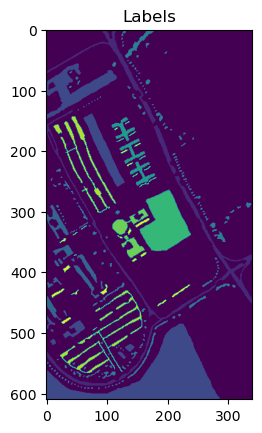

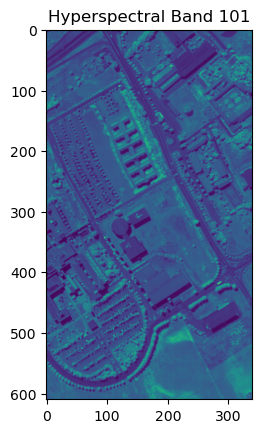

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'PaviaU_gt.mat'
data_files = 'PaviaU.mat'
label_files = 'paviaU_gt'
hypercube_files = 'paviaU'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 42776
Extracted windows shape: (42776, 5, 5, 103)
Corresponding labels shape: (42776,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 6631 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 18649 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 2099 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 3064 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 1345 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 5029 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 1330 samples
Shuffled class indices for class '7'
Selected 5 training sam


All datasets saved to the 'indices' folder.
(45, 5, 5, 103)
(45, 5, 5, 103)
(42686, 5, 5, 103)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 45
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (34220, 5, 5, 103)
Validation data shape: (8556, 5, 5, 103)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

103


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/535], Loss: 0.1201, PSNR: 6.2934


	 Training Batch [200/535], Loss: 0.0616, PSNR: 10.5267


	 Training Batch [400/535], Loss: 0.0301, PSNR: 13.4695


Epoch [1/50] Training Loss: 0.0555, PSNR: 11.2084
	[Val]   Batch [1/134] Loss: 0.0191, PSNR: 15.3762
	[Val]   Batch [10/134] Loss: 0.0168, PSNR: 17.7348
	[Val]   Batch [20/134] Loss: 0.0180, PSNR: 15.5492
	[Val]   Batch [30/134] Loss: 0.0196, PSNR: 14.9993
	[Val]   Batch [40/134] Loss: 0.0178, PSNR: 14.0469
	[Val]   Batch [50/134] Loss: 0.0189, PSNR: 15.2016
	[Val]   Batch [60/134] Loss: 0.0170, PSNR: 15.8855


	[Val]   Batch [70/134] Loss: 0.0162, PSNR: 16.0766
	[Val]   Batch [80/134] Loss: 0.0159, PSNR: 16.0642
	[Val]   Batch [90/134] Loss: 0.0167, PSNR: 16.0453
	[Val]   Batch [100/134] Loss: 0.0189, PSNR: 15.4453
	[Val]   Batch [110/134] Loss: 0.0192, PSNR: 13.9734
	[Val]   Batch [120/134] Loss: 0.0157, PSNR: 15.1526
	[Val]   Batch [130/134] Loss: 0.0173, PSNR: 13.1633
Epoch [1/50] Validation Loss: 0.0181, PSNR: 15.4045

LOG: Epoch [2/50]
	 Training Batch [1/535], Loss: 0.0193, PSNR: 15.4166


	 Training Batch [200/535], Loss: 0.0116, PSNR: 15.7542


	 Training Batch [400/535], Loss: 0.0100, PSNR: 18.1737


Epoch [2/50] Training Loss: 0.0117, PSNR: 17.3538
	[Val]   Batch [1/134] Loss: 0.0088, PSNR: 18.7631
	[Val]   Batch [10/134] Loss: 0.0070, PSNR: 21.5526
	[Val]   Batch [20/134] Loss: 0.0075, PSNR: 19.3298
	[Val]   Batch [30/134] Loss: 0.0086, PSNR: 18.5668
	[Val]   Batch [40/134] Loss: 0.0077, PSNR: 17.6779
	[Val]   Batch [50/134] Loss: 0.0080, PSNR: 18.9141
	[Val]   Batch [60/134] Loss: 0.0070, PSNR: 19.7691


	[Val]   Batch [70/134] Loss: 0.0068, PSNR: 19.8466
	[Val]   Batch [80/134] Loss: 0.0065, PSNR: 19.9584
	[Val]   Batch [90/134] Loss: 0.0070, PSNR: 19.8496
	[Val]   Batch [100/134] Loss: 0.0083, PSNR: 19.0110
	[Val]   Batch [110/134] Loss: 0.0078, PSNR: 17.8771
	[Val]   Batch [120/134] Loss: 0.0058, PSNR: 19.4804
	[Val]   Batch [130/134] Loss: 0.0070, PSNR: 17.0751
Epoch [2/50] Validation Loss: 0.0079, PSNR: 19.0420

LOG: Epoch [3/50]
	 Training Batch [1/535], Loss: 0.0088, PSNR: 17.0554


	 Training Batch [200/535], Loss: 0.0076, PSNR: 19.2938


	 Training Batch [400/535], Loss: 0.0059, PSNR: 19.0958


Epoch [3/50] Training Loss: 0.0069, PSNR: 19.6129
	[Val]   Batch [1/134] Loss: 0.0062, PSNR: 20.2827
	[Val]   Batch [10/134] Loss: 0.0049, PSNR: 23.1196
	[Val]   Batch [20/134] Loss: 0.0052, PSNR: 20.9814
	[Val]   Batch [30/134] Loss: 0.0059, PSNR: 20.2151
	[Val]   Batch [40/134] Loss: 0.0054, PSNR: 19.2571
	[Val]   Batch [50/134] Loss: 0.0055, PSNR: 20.5969


	[Val]   Batch [60/134] Loss: 0.0047, PSNR: 21.4509
	[Val]   Batch [70/134] Loss: 0.0047, PSNR: 21.4318
	[Val]   Batch [80/134] Loss: 0.0044, PSNR: 21.6027
	[Val]   Batch [90/134] Loss: 0.0048, PSNR: 21.4440
	[Val]   Batch [100/134] Loss: 0.0058, PSNR: 20.5943
	[Val]   Batch [110/134] Loss: 0.0052, PSNR: 19.6689
	[Val]   Batch [120/134] Loss: 0.0037, PSNR: 21.4049
	[Val]   Batch [130/134] Loss: 0.0047, PSNR: 18.8374
Epoch [3/50] Validation Loss: 0.0055, PSNR: 20.6198

LOG: Epoch [4/50]
	 Training Batch [1/535], Loss: 0.0069, PSNR: 19.8013


	 Training Batch [200/535], Loss: 0.0032, PSNR: 19.8467


	 Training Batch [400/535], Loss: 0.0055, PSNR: 20.7879


Epoch [4/50] Training Loss: 0.0049, PSNR: 21.0669
	[Val]   Batch [1/134] Loss: 0.0042, PSNR: 21.9786
	[Val]   Batch [10/134] Loss: 0.0034, PSNR: 24.7158
	[Val]   Batch [20/134] Loss: 0.0034, PSNR: 22.7850
	[Val]   Batch [30/134] Loss: 0.0039, PSNR: 22.0689
	[Val]   Batch [40/134] Loss: 0.0035, PSNR: 21.0820
	[Val]   Batch [50/134] Loss: 0.0035, PSNR: 22.5704
	[Val]   Batch [60/134] Loss: 0.0033, PSNR: 22.9521


	[Val]   Batch [70/134] Loss: 0.0033, PSNR: 23.0338
	[Val]   Batch [80/134] Loss: 0.0031, PSNR: 23.1967
	[Val]   Batch [90/134] Loss: 0.0033, PSNR: 23.0868
	[Val]   Batch [100/134] Loss: 0.0039, PSNR: 22.2909
	[Val]   Batch [110/134] Loss: 0.0033, PSNR: 21.6534
	[Val]   Batch [120/134] Loss: 0.0025, PSNR: 23.2027
	[Val]   Batch [130/134] Loss: 0.0030, PSNR: 20.7666
Epoch [4/50] Validation Loss: 0.0037, PSNR: 22.2995

LOG: Epoch [5/50]
	 Training Batch [1/535], Loss: 0.0041, PSNR: 22.1137


	 Training Batch [200/535], Loss: 0.0028, PSNR: 21.4428


	 Training Batch [400/535], Loss: 0.0028, PSNR: 22.3107


Epoch [5/50] Training Loss: 0.0035, PSNR: 22.5226
	[Val]   Batch [1/134] Loss: 0.0031, PSNR: 23.3110
	[Val]   Batch [10/134] Loss: 0.0025, PSNR: 26.0819
	[Val]   Batch [20/134] Loss: 0.0024, PSNR: 24.3684
	[Val]   Batch [30/134] Loss: 0.0027, PSNR: 23.6475
	[Val]   Batch [40/134] Loss: 0.0024, PSNR: 22.7043
	[Val]   Batch [50/134] Loss: 0.0023, PSNR: 24.2939


	[Val]   Batch [60/134] Loss: 0.0025, PSNR: 24.1674
	[Val]   Batch [70/134] Loss: 0.0024, PSNR: 24.3476
	[Val]   Batch [80/134] Loss: 0.0023, PSNR: 24.5083
	[Val]   Batch [90/134] Loss: 0.0024, PSNR: 24.3893
	[Val]   Batch [100/134] Loss: 0.0028, PSNR: 23.7491
	[Val]   Batch [110/134] Loss: 0.0021, PSNR: 23.5092
	[Val]   Batch [120/134] Loss: 0.0017, PSNR: 24.8170


	[Val]   Batch [130/134] Loss: 0.0021, PSNR: 22.3660
Epoch [5/50] Validation Loss: 0.0027, PSNR: 23.7190

LOG: Epoch [6/50]
	 Training Batch [1/535], Loss: 0.0025, PSNR: 23.8659


	 Training Batch [200/535], Loss: 0.0025, PSNR: 24.1970


	 Training Batch [400/535], Loss: 0.0029, PSNR: 23.6790


Epoch [6/50] Training Loss: 0.0029, PSNR: 23.5022
	[Val]   Batch [1/134] Loss: 0.0026, PSNR: 24.0157
	[Val]   Batch [10/134] Loss: 0.0021, PSNR: 26.8256
	[Val]   Batch [20/134] Loss: 0.0019, PSNR: 25.2972
	[Val]   Batch [30/134] Loss: 0.0022, PSNR: 24.5275
	[Val]   Batch [40/134] Loss: 0.0020, PSNR: 23.6161
	[Val]   Batch [50/134] Loss: 0.0019, PSNR: 25.2340
	[Val]   Batch [60/134] Loss: 0.0022, PSNR: 24.8180


	[Val]   Batch [70/134] Loss: 0.0021, PSNR: 25.0427
	[Val]   Batch [80/134] Loss: 0.0019, PSNR: 25.2367
	[Val]   Batch [90/134] Loss: 0.0021, PSNR: 25.0894
	[Val]   Batch [100/134] Loss: 0.0023, PSNR: 24.5616
	[Val]   Batch [110/134] Loss: 0.0017, PSNR: 24.5328
	[Val]   Batch [120/134] Loss: 0.0014, PSNR: 25.7344
	[Val]   Batch [130/134] Loss: 0.0017, PSNR: 23.2035
Epoch [6/50] Validation Loss: 0.0023, PSNR: 24.5103

LOG: Epoch [7/50]
	 Training Batch [1/535], Loss: 0.0024, PSNR: 24.3113


	 Training Batch [200/535], Loss: 0.0017, PSNR: 24.8096


	 Training Batch [400/535], Loss: 0.0024, PSNR: 24.2056


Epoch [7/50] Training Loss: 0.0025, PSNR: 24.1133
	[Val]   Batch [1/134] Loss: 0.0023, PSNR: 24.5970
	[Val]   Batch [10/134] Loss: 0.0018, PSNR: 27.4721
	[Val]   Batch [20/134] Loss: 0.0016, PSNR: 26.1524
	[Val]   Batch [30/134] Loss: 0.0018, PSNR: 25.2763
	[Val]   Batch [40/134] Loss: 0.0016, PSNR: 24.4296
	[Val]   Batch [50/134] Loss: 0.0016, PSNR: 26.0146
	[Val]   Batch [60/134] Loss: 0.0019, PSNR: 25.4207


	[Val]   Batch [70/134] Loss: 0.0018, PSNR: 25.6810
	[Val]   Batch [80/134] Loss: 0.0016, PSNR: 25.9180
	[Val]   Batch [90/134] Loss: 0.0018, PSNR: 25.7033
	[Val]   Batch [100/134] Loss: 0.0020, PSNR: 25.2375
	[Val]   Batch [110/134] Loss: 0.0014, PSNR: 25.4182
	[Val]   Batch [120/134] Loss: 0.0011, PSNR: 26.5976
	[Val]   Batch [130/134] Loss: 0.0014, PSNR: 23.9871
Epoch [7/50] Validation Loss: 0.0019, PSNR: 25.2104

LOG: Epoch [8/50]
	 Training Batch [1/535], Loss: 0.0021, PSNR: 24.8112


	 Training Batch [200/535], Loss: 0.0038, PSNR: 22.5338


	 Training Batch [400/535], Loss: 0.0019, PSNR: 25.1491


Epoch [8/50] Training Loss: 0.0022, PSNR: 24.5991
	[Val]   Batch [1/134] Loss: 0.0021, PSNR: 24.9385
	[Val]   Batch [10/134] Loss: 0.0016, PSNR: 27.8305
	[Val]   Batch [20/134] Loss: 0.0014, PSNR: 26.6444
	[Val]   Batch [30/134] Loss: 0.0017, PSNR: 25.7271
	[Val]   Batch [40/134] Loss: 0.0014, PSNR: 24.9481
	[Val]   Batch [50/134] Loss: 0.0014, PSNR: 26.4550


	[Val]   Batch [60/134] Loss: 0.0017, PSNR: 25.7910
	[Val]   Batch [70/134] Loss: 0.0016, PSNR: 26.0545
	[Val]   Batch [80/134] Loss: 0.0015, PSNR: 26.3126
	[Val]   Batch [90/134] Loss: 0.0017, PSNR: 26.0337
	[Val]   Batch [100/134] Loss: 0.0018, PSNR: 25.6611
	[Val]   Batch [110/134] Loss: 0.0012, PSNR: 25.9448
	[Val]   Batch [120/134] Loss: 0.0010, PSNR: 27.1227


	[Val]   Batch [130/134] Loss: 0.0013, PSNR: 24.4020
Epoch [8/50] Validation Loss: 0.0018, PSNR: 25.6321

LOG: Epoch [9/50]
	 Training Batch [1/535], Loss: 0.0017, PSNR: 25.8051


	 Training Batch [200/535], Loss: 0.0018, PSNR: 24.1957


	 Training Batch [400/535], Loss: 0.0023, PSNR: 24.4166


Epoch [9/50] Training Loss: 0.0021, PSNR: 24.9265
	[Val]   Batch [1/134] Loss: 0.0020, PSNR: 25.2192
	[Val]   Batch [10/134] Loss: 0.0015, PSNR: 28.1487
	[Val]   Batch [20/134] Loss: 0.0013, PSNR: 27.0571
	[Val]   Batch [30/134] Loss: 0.0015, PSNR: 26.0771
	[Val]   Batch [40/134] Loss: 0.0013, PSNR: 25.3391
	[Val]   Batch [50/134] Loss: 0.0013, PSNR: 26.8054
	[Val]   Batch [60/134] Loss: 0.0016, PSNR: 26.0993


	[Val]   Batch [70/134] Loss: 0.0015, PSNR: 26.3645
	[Val]   Batch [80/134] Loss: 0.0014, PSNR: 26.6707
	[Val]   Batch [90/134] Loss: 0.0016, PSNR: 26.3489
	[Val]   Batch [100/134] Loss: 0.0017, PSNR: 25.9819
	[Val]   Batch [110/134] Loss: 0.0011, PSNR: 26.3476
	[Val]   Batch [120/134] Loss: 0.0009, PSNR: 27.5503
	[Val]   Batch [130/134] Loss: 0.0012, PSNR: 24.7620
Epoch [9/50] Validation Loss: 0.0016, PSNR: 25.9769

LOG: Epoch [10/50]
	 Training Batch [1/535], Loss: 0.0027, PSNR: 24.0450


	 Training Batch [200/535], Loss: 0.0021, PSNR: 24.5949


	 Training Batch [400/535], Loss: 0.0020, PSNR: 26.7389


Epoch [10/50] Training Loss: 0.0019, PSNR: 25.1793
	[Val]   Batch [1/134] Loss: 0.0019, PSNR: 25.4589
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.4163
	[Val]   Batch [20/134] Loss: 0.0012, PSNR: 27.4025
	[Val]   Batch [30/134] Loss: 0.0014, PSNR: 26.3682
	[Val]   Batch [40/134] Loss: 0.0012, PSNR: 25.6675
	[Val]   Batch [50/134] Loss: 0.0012, PSNR: 27.1019


	[Val]   Batch [60/134] Loss: 0.0015, PSNR: 26.3392
	[Val]   Batch [70/134] Loss: 0.0014, PSNR: 26.6144
	[Val]   Batch [80/134] Loss: 0.0013, PSNR: 26.9425
	[Val]   Batch [90/134] Loss: 0.0015, PSNR: 26.6124
	[Val]   Batch [100/134] Loss: 0.0016, PSNR: 26.2651
	[Val]   Batch [110/134] Loss: 0.0010, PSNR: 26.7097
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 27.8774
	[Val]   Batch [130/134] Loss: 0.0011, PSNR: 25.0378


Epoch [10/50] Validation Loss: 0.0015, PSNR: 26.2653

LOG: Epoch [11/50]
	 Training Batch [1/535], Loss: 0.0020, PSNR: 25.3418


	 Training Batch [200/535], Loss: 0.0013, PSNR: 24.9170


	 Training Batch [400/535], Loss: 0.0014, PSNR: 24.7457


Epoch [11/50] Training Loss: 0.0018, PSNR: 25.3922
	[Val]   Batch [1/134] Loss: 0.0018, PSNR: 25.6977
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.6788
	[Val]   Batch [20/134] Loss: 0.0011, PSNR: 27.7607
	[Val]   Batch [30/134] Loss: 0.0013, PSNR: 26.6641
	[Val]   Batch [40/134] Loss: 0.0011, PSNR: 25.9894
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.4076
	[Val]   Batch [60/134] Loss: 0.0014, PSNR: 26.6318


	[Val]   Batch [70/134] Loss: 0.0014, PSNR: 26.8559
	[Val]   Batch [80/134] Loss: 0.0012, PSNR: 27.2551
	[Val]   Batch [90/134] Loss: 0.0014, PSNR: 26.8897
	[Val]   Batch [100/134] Loss: 0.0015, PSNR: 26.5435
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.0805
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 28.2520
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.3698
Epoch [11/50] Validation Loss: 0.0014, PSNR: 26.5609

LOG: Epoch [12/50]
	 Training Batch [1/535], Loss: 0.0016, PSNR: 25.8478


	 Training Batch [200/535], Loss: 0.0016, PSNR: 27.9965


	 Training Batch [400/535], Loss: 0.0014, PSNR: 26.7556


Epoch [12/50] Training Loss: 0.0018, PSNR: 25.6255
	[Val]   Batch [1/134] Loss: 0.0017, PSNR: 25.9637
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 28.9813
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 28.1557
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 27.0340
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.3957
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 27.7768
	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 26.9247


	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 27.1371
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.5886
	[Val]   Batch [90/134] Loss: 0.0013, PSNR: 27.1909
	[Val]   Batch [100/134] Loss: 0.0014, PSNR: 26.8571
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.5692
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.6300
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.7597
Epoch [12/50] Validation Loss: 0.0013, PSNR: 26.9004

LOG: Epoch [13/50]
	 Training Batch [1/535], Loss: 0.0026, PSNR: 23.9738


	 Training Batch [200/535], Loss: 0.0012, PSNR: 29.2645


	 Training Batch [400/535], Loss: 0.0015, PSNR: 26.7007


Epoch [13/50] Training Loss: 0.0017, PSNR: 25.7731
	[Val]   Batch [1/134] Loss: 0.0016, PSNR: 26.1535
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.1659
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.4036
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 27.2555
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.6363
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 27.9938
	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 27.1185


	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.3508
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.8341
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.4016
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 27.0560
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.8157
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.8805
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 25.9882
Epoch [13/50] Validation Loss: 0.0013, PSNR: 27.1184

LOG: Epoch [14/50]
	 Training Batch [1/535], Loss: 0.0013, PSNR: 26.6401


	 Training Batch [200/535], Loss: 0.0015, PSNR: 26.3489


	 Training Batch [400/535], Loss: 0.0021, PSNR: 25.7849


Epoch [14/50] Training Loss: 0.0016, PSNR: 25.9726
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.3195
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.3551
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.6528
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.4532
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 26.8728
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 28.1737
	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.3125


	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.5279
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 28.0470
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.5904
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 27.2333
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 28.0464
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.0793
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 26.2105
Epoch [14/50] Validation Loss: 0.0012, PSNR: 27.3232

LOG: Epoch [15/50]
	 Training Batch [1/535], Loss: 0.0015, PSNR: 26.3629


	 Training Batch [200/535], Loss: 0.0015, PSNR: 26.3953


	 Training Batch [400/535], Loss: 0.0016, PSNR: 26.3368


Epoch [15/50] Training Loss: 0.0016, PSNR: 26.1522
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.4573
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.4874
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 28.8561
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.6076
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 27.0574
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.3133
	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.4597


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.6734
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 28.2047
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.7517
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.3869
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.1909
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.2294
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.3591
Epoch [15/50] Validation Loss: 0.0012, PSNR: 27.4841

LOG: Epoch [16/50]
	 Training Batch [1/535], Loss: 0.0022, PSNR: 26.4850


	 Training Batch [200/535], Loss: 0.0013, PSNR: 26.4896


	 Training Batch [400/535], Loss: 0.0016, PSNR: 26.1069


Epoch [16/50] Training Loss: 0.0015, PSNR: 26.2456
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.6335
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.6527
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 29.0744
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 27.8226
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 27.2412
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.5198
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.6510


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.8760
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.4202
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.9384
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.5680
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.4427
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.4097
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.5817
Epoch [16/50] Validation Loss: 0.0011, PSNR: 27.6753

LOG: Epoch [17/50]
	 Training Batch [1/535], Loss: 0.0015, PSNR: 26.3998


	 Training Batch [200/535], Loss: 0.0014, PSNR: 26.6761


	 Training Batch [400/535], Loss: 0.0013, PSNR: 25.9994


Epoch [17/50] Training Loss: 0.0015, PSNR: 26.4277
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.8122
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 29.8202
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 29.3502
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 28.0433
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.5087
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.7233
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.8890


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.0763
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.6470
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.1308
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.7596
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.6621
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.6183
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 26.8080


Epoch [17/50] Validation Loss: 0.0011, PSNR: 27.8917

LOG: Epoch [18/50]
	 Training Batch [1/535], Loss: 0.0019, PSNR: 25.4193


	 Training Batch [200/535], Loss: 0.0020, PSNR: 26.5351


	 Training Batch [400/535], Loss: 0.0011, PSNR: 27.3200


Epoch [18/50] Training Loss: 0.0014, PSNR: 26.6136
	[Val]   Batch [1/134] Loss: 0.0013, PSNR: 26.9660
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 29.9484
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.5415
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.2055
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.6422
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.8473
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.0813


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.2394
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 28.8082
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.3131
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.9207
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.7386
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.7099
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 26.9470


Epoch [18/50] Validation Loss: 0.0010, PSNR: 28.0449

LOG: Epoch [19/50]
	 Training Batch [1/535], Loss: 0.0015, PSNR: 26.4151


	 Training Batch [200/535], Loss: 0.0017, PSNR: 27.7835


	 Training Batch [400/535], Loss: 0.0010, PSNR: 25.9497


Epoch [19/50] Training Loss: 0.0014, PSNR: 26.7632
	[Val]   Batch [1/134] Loss: 0.0013, PSNR: 27.1365
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 30.0556
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.7559
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.3984
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 27.8153
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.9760
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.3374


	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.4702
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 29.0100
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.5477
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.1460
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.8098
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.7847
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.1051
Epoch [19/50] Validation Loss: 0.0010, PSNR: 28.2234

LOG: Epoch [20/50]
	 Training Batch [1/535], Loss: 0.0017, PSNR: 25.7846


	 Training Batch [200/535], Loss: 0.0017, PSNR: 25.9689


	 Training Batch [400/535], Loss: 0.0021, PSNR: 25.0338


Epoch [20/50] Training Loss: 0.0013, PSNR: 26.9428
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.4842
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.3455
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.2448
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 28.8299
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.2916
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.4614
	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.7642


	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 28.9270
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.3951
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 29.0005
	[Val]   Batch [100/134] Loss: 0.0009, PSNR: 28.5718
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.2120
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.1408
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.5985
Epoch [20/50] Validation Loss: 0.0009, PSNR: 28.6319

LOG: Epoch [21/50]
	 Training Batch [1/535], Loss: 0.0014, PSNR: 27.2445


	 Training Batch [200/535], Loss: 0.0008, PSNR: 27.9513


	 Training Batch [400/535], Loss: 0.0013, PSNR: 27.2527


Epoch [21/50] Training Loss: 0.0012, PSNR: 27.1382
	[Val]   Batch [1/134] Loss: 0.0011, PSNR: 27.8332
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.5914
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.5614
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.2130
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.5825
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.7520
	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.1428


	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 29.2842
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.7542
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 29.3645
	[Val]   Batch [100/134] Loss: 0.0009, PSNR: 28.9060
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.4161
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.2997
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.9102
Epoch [21/50] Validation Loss: 0.0008, PSNR: 28.9469

LOG: Epoch [22/50]
	 Training Batch [1/535], Loss: 0.0016, PSNR: 26.2594


	 Training Batch [200/535], Loss: 0.0014, PSNR: 26.7574


	 Training Batch [400/535], Loss: 0.0016, PSNR: 26.6231


Epoch [22/50] Training Loss: 0.0012, PSNR: 27.3355
	[Val]   Batch [1/134] Loss: 0.0010, PSNR: 28.0570
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 30.7373
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.6497
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.4269
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.7117
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 29.8647


	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.3332
	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.5285
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 29.9614
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 29.6157
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 29.1234
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.3605
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.2800
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.9699


Epoch [22/50] Validation Loss: 0.0008, PSNR: 29.1231

LOG: Epoch [23/50]
	 Training Batch [1/535], Loss: 0.0012, PSNR: 27.2143


	 Training Batch [200/535], Loss: 0.0011, PSNR: 27.5218


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.5301


Epoch [23/50] Training Loss: 0.0011, PSNR: 27.5457
	[Val]   Batch [1/134] Loss: 0.0010, PSNR: 28.3776
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 30.9718
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 30.9079
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.7560
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.9609
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.1102
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.6566


	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.8733
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.2166
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 29.9387
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 29.4340
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.5329
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.4340
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.2611


Epoch [23/50] Validation Loss: 0.0007, PSNR: 29.4059

LOG: Epoch [24/50]
	 Training Batch [1/535], Loss: 0.0010, PSNR: 28.0623


	 Training Batch [200/535], Loss: 0.0007, PSNR: 27.6962


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.3130


Epoch [24/50] Training Loss: 0.0011, PSNR: 27.7462
	[Val]   Batch [1/134] Loss: 0.0009, PSNR: 28.7685
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.2665
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.2247
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.1792
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.2612
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.5730
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.9540


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.2113
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.5430
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.3431
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 29.8283
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.8491
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.6624
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.5654
Epoch [24/50] Validation Loss: 0.0007, PSNR: 29.7657

LOG: Epoch [25/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.8360


	 Training Batch [200/535], Loss: 0.0014, PSNR: 26.7824


	 Training Batch [400/535], Loss: 0.0013, PSNR: 27.2246


Epoch [25/50] Training Loss: 0.0010, PSNR: 27.9016
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 28.9930
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.4279
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.3811
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.3660
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.2861
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.7073
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.0744


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.3536
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.7271
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.5282
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 30.0083
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.8807
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.7433
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.5620
Epoch [25/50] Validation Loss: 0.0007, PSNR: 29.9261

LOG: Epoch [26/50]
	 Training Batch [1/535], Loss: 0.0014, PSNR: 26.9242


	 Training Batch [200/535], Loss: 0.0008, PSNR: 27.4514


	 Training Batch [400/535], Loss: 0.0009, PSNR: 28.3103


Epoch [26/50] Training Loss: 0.0010, PSNR: 28.0748
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 29.3404
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.7079
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.6973
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.7197
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.5776
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 31.0547
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.3471


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.7145
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 31.0172
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.8690
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.3375
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 30.1075
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.9344
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.8549


Epoch [26/50] Validation Loss: 0.0006, PSNR: 30.2452

LOG: Epoch [27/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.5030


	 Training Batch [200/535], Loss: 0.0008, PSNR: 27.7799


	 Training Batch [400/535], Loss: 0.0009, PSNR: 28.7790


Epoch [27/50] Training Loss: 0.0010, PSNR: 28.2226
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 29.4119
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.7571
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.5614
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.6999
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.5162
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.9787
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.3045


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.7454
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.9986
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 30.9197
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.3554
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.9729
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.8330
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.7110


Epoch [27/50] Validation Loss: 0.0006, PSNR: 30.2482
Early stopping triggered at epoch 27. No improvement for 3 epochs.


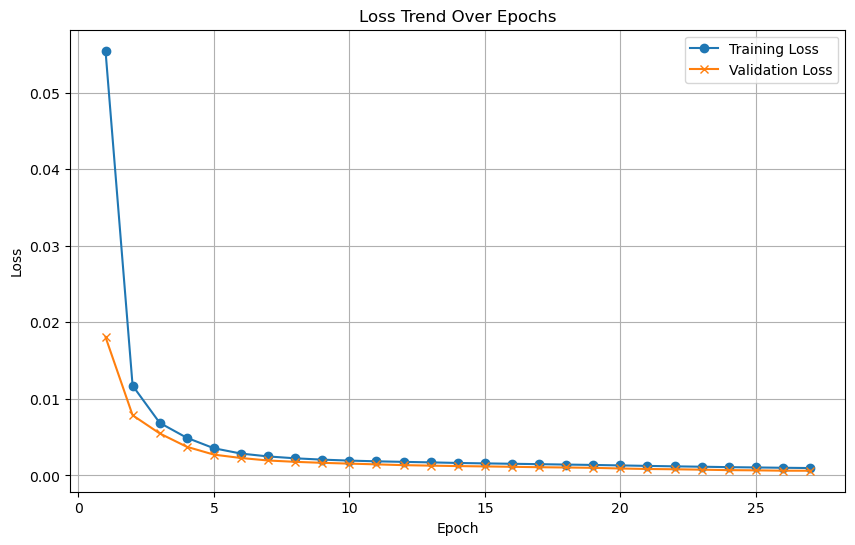

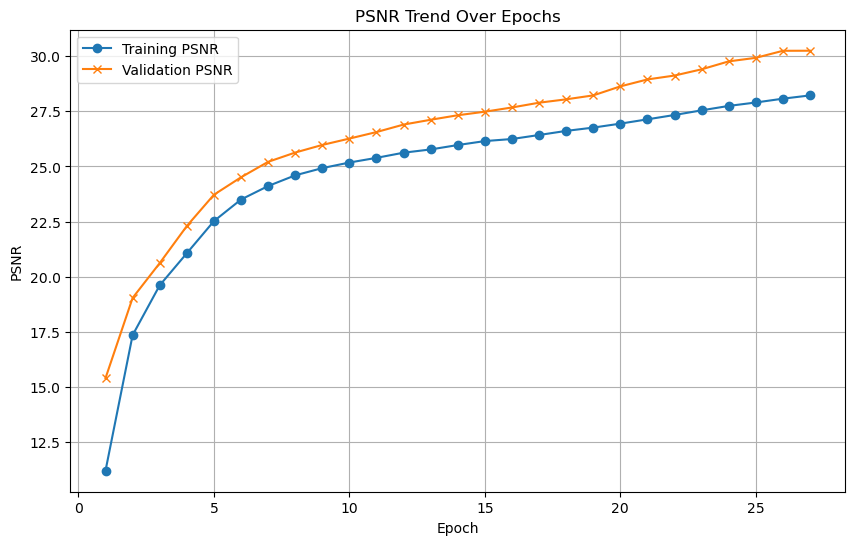

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...


    Processed batch 1/167 for test dataset.


    Processed batch 101/167 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.2861
    Validation Batch [1/1], Loss: 2.2014
Validation Loss: 2.2014, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2014. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.2133
    Validation Batch [1/1], Loss: 2.2013
Validation Loss: 2.2013, Validation Accuracy: 11.11%
Validation loss improved from 2.2014 to 2.2013. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.1925
    Validation Batch [1/1], Loss: 2.2013
Validation Loss: 2.2013, Validation Accuracy: 11.11%
Validation loss improved from 2.2013 to 2.2013. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.1363
    Validation Batch [1/1], Loss: 2.2013
Validation Loss: 2.2013, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [5/1000] - Training
Ep

Epoch [23/1000] completed, Average Training Loss: 1.7857
    Validation Batch [1/1], Loss: 2.1935
Validation Loss: 2.1935, Validation Accuracy: 11.11%
Validation loss improved from 2.1949 to 2.1935. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 1.8266
    Validation Batch [1/1], Loss: 2.1919
Validation Loss: 2.1919, Validation Accuracy: 11.11%
Validation loss improved from 2.1935 to 2.1919. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 1.7652
    Validation Batch [1/1], Loss: 2.1899
Validation Loss: 2.1899, Validation Accuracy: 11.11%
Validation loss improved from 2.1919 to 2.1899. Saving model...

LOG: Epoch [26/1000] - Training
Epoch [26/1000] completed, Average Training Loss: 1.7432
    Validation Batch [1/1], Loss: 2.1871
Validation Loss: 2.1871, Validation Accuracy: 11.11%
Validation loss improved from 2.1899 to 2.1871. Saving model...

LOG: Epoch [27/1000] - Training
Epoch [2


LOG: Epoch [58/1000] - Training
Epoch [58/1000] completed, Average Training Loss: 1.4462
    Validation Batch [1/1], Loss: 1.7695
Validation Loss: 1.7695, Validation Accuracy: 53.33%
Validation loss improved from 1.7839 to 1.7695. Saving model...

LOG: Epoch [59/1000] - Training
Epoch [59/1000] completed, Average Training Loss: 1.4140
    Validation Batch [1/1], Loss: 1.7601
Validation Loss: 1.7601, Validation Accuracy: 53.33%
Validation loss improved from 1.7695 to 1.7601. Saving model...

LOG: Epoch [60/1000] - Training
Epoch [60/1000] completed, Average Training Loss: 1.4572
    Validation Batch [1/1], Loss: 1.7524
Validation Loss: 1.7524, Validation Accuracy: 53.33%
Validation loss improved from 1.7601 to 1.7524. Saving model...

LOG: Epoch [61/1000] - Training
Epoch [61/1000] completed, Average Training Loss: 1.4351
    Validation Batch [1/1], Loss: 1.7500
Validation Loss: 1.7500, Validation Accuracy: 55.56%
Validation loss improved from 1.7524 to 1.7500. Saving model...

LOG: Ep

Epoch [88/1000] completed, Average Training Loss: 1.2200
    Validation Batch [1/1], Loss: 1.4966
Validation Loss: 1.4966, Validation Accuracy: 55.56%
Validation loss improved from 1.5030 to 1.4966. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Training Loss: 1.2393
    Validation Batch [1/1], Loss: 1.4889
Validation Loss: 1.4889, Validation Accuracy: 60.00%
Validation loss improved from 1.4966 to 1.4889. Saving model...

LOG: Epoch [90/1000] - Training
Epoch [90/1000] completed, Average Training Loss: 1.2427
    Validation Batch [1/1], Loss: 1.4794
Validation Loss: 1.4794, Validation Accuracy: 62.22%
Validation loss improved from 1.4889 to 1.4794. Saving model...

LOG: Epoch [91/1000] - Training
Epoch [91/1000] completed, Average Training Loss: 1.2741
    Validation Batch [1/1], Loss: 1.4729
Validation Loss: 1.4729, Validation Accuracy: 62.22%
Validation loss improved from 1.4794 to 1.4729. Saving model...

LOG: Epoch [92/1000] - Training
Epoch [9

    Validation Batch [1/1], Loss: 1.3212
Validation Loss: 1.3212, Validation Accuracy: 66.67%
Validation loss improved from 1.3284 to 1.3212. Saving model...

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 1.0366
    Validation Batch [1/1], Loss: 1.3177
Validation Loss: 1.3177, Validation Accuracy: 68.89%
Validation loss improved from 1.3212 to 1.3177. Saving model...

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Average Training Loss: 0.9814
    Validation Batch [1/1], Loss: 1.3187
Validation Loss: 1.3187, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [125/1000] - Training
Epoch [125/1000] completed, Average Training Loss: 1.0404
    Validation Batch [1/1], Loss: 1.3213
Validation Loss: 1.3213, Validation Accuracy: 64.44%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Average Training Loss: 0.9553
    Validation Batch [1/1], Lo

Epoch [155/1000] completed, Average Training Loss: 0.8090
    Validation Batch [1/1], Loss: 1.1972
Validation Loss: 1.1972, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [156/1000] - Training
Epoch [156/1000] completed, Average Training Loss: 0.8843
    Validation Batch [1/1], Loss: 1.1906
Validation Loss: 1.1906, Validation Accuracy: 68.89%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [157/1000] - Training
Epoch [157/1000] completed, Average Training Loss: 0.8124
    Validation Batch [1/1], Loss: 1.1781
Validation Loss: 1.1781, Validation Accuracy: 68.89%
Validation loss improved from 1.1855 to 1.1781. Saving model...

LOG: Epoch [158/1000] - Training
Epoch [158/1000] completed, Average Training Loss: 0.8598
    Validation Batch [1/1], Loss: 1.1685
Validation Loss: 1.1685, Validation Accuracy: 71.11%
Validation loss improved from 1.1781 to 1.1685. Saving model...

LOG: Epoch [159/1000] - Training
Epoch [159/1000] completed, Av

Epoch [187/1000] completed, Average Training Loss: 0.6470
    Validation Batch [1/1], Loss: 1.0586
Validation Loss: 1.0586, Validation Accuracy: 66.67%
Validation loss improved from 1.0683 to 1.0586. Saving model...

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Average Training Loss: 0.6450
    Validation Batch [1/1], Loss: 1.0460
Validation Loss: 1.0460, Validation Accuracy: 68.89%
Validation loss improved from 1.0586 to 1.0460. Saving model...

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training Loss: 0.6677
    Validation Batch [1/1], Loss: 1.0405
Validation Loss: 1.0405, Validation Accuracy: 73.33%
Validation loss improved from 1.0460 to 1.0405. Saving model...

LOG: Epoch [190/1000] - Training
Epoch [190/1000] completed, Average Training Loss: 0.5962
    Validation Batch [1/1], Loss: 1.0555
Validation Loss: 1.0555, Validation Accuracy: 68.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [191/1000] - Training
Epoch [191/1000

    Validation Batch [1/1], Loss: 0.9410
Validation Loss: 0.9410, Validation Accuracy: 71.11%
Validation loss improved from 0.9427 to 0.9410. Saving model...

LOG: Epoch [221/1000] - Training
Epoch [221/1000] completed, Average Training Loss: 0.5290
    Validation Batch [1/1], Loss: 0.9411
Validation Loss: 0.9411, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [222/1000] - Training
Epoch [222/1000] completed, Average Training Loss: 0.5066
    Validation Batch [1/1], Loss: 0.9436
Validation Loss: 0.9436, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [223/1000] - Training
Epoch [223/1000] completed, Average Training Loss: 0.5143
    Validation Batch [1/1], Loss: 0.9559
Validation Loss: 0.9559, Validation Accuracy: 71.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [224/1000] - Training
Epoch [224/1000] completed, Average Training Loss: 0.5008
    Validation Batch [1/1], Loss: 0.9576
Vali

    Validation Batch [1/1], Loss: 0.8498
Validation Loss: 0.8498, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [255/1000] - Training
Epoch [255/1000] completed, Average Training Loss: 0.3857
    Validation Batch [1/1], Loss: 0.8295
Validation Loss: 0.8295, Validation Accuracy: 77.78%
Validation loss improved from 0.8368 to 0.8295. Saving model...

LOG: Epoch [256/1000] - Training
Epoch [256/1000] completed, Average Training Loss: 0.3926
    Validation Batch [1/1], Loss: 0.8329
Validation Loss: 0.8329, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training Loss: 0.3623
    Validation Batch [1/1], Loss: 0.8473
Validation Loss: 0.8473, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.4358
    Validation Batch [1/1], Loss: 0.8672
Vali

Epoch [288/1000] completed, Average Training Loss: 0.2980
    Validation Batch [1/1], Loss: 0.7611
Validation Loss: 0.7611, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [289/1000] - Training
Epoch [289/1000] completed, Average Training Loss: 0.2942
    Validation Batch [1/1], Loss: 0.7575
Validation Loss: 0.7575, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [290/1000] - Training
Epoch [290/1000] completed, Average Training Loss: 0.3407
    Validation Batch [1/1], Loss: 0.7524
Validation Loss: 0.7524, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [291/1000] - Training
Epoch [291/1000] completed, Average Training Loss: 0.2520
    Validation Batch [1/1], Loss: 0.7477
Validation Loss: 0.7477, Validation Accuracy: 77.78%
Validation loss improved from 0.7514 to 0.7477. Saving model...

LOG: Epoch [292/1000] - Training
Epoch [292/1000] completed, Average Training 

Epoch [319/1000] completed, Average Training Loss: 0.2200
    Validation Batch [1/1], Loss: 0.7534
Validation Loss: 0.7534, Validation Accuracy: 71.11%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [320/1000] - Training
Epoch [320/1000] completed, Average Training Loss: 0.1797
    Validation Batch [1/1], Loss: 0.7460
Validation Loss: 0.7460, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [321/1000] - Training
Epoch [321/1000] completed, Average Training Loss: 0.2262
    Validation Batch [1/1], Loss: 0.7213
Validation Loss: 0.7213, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [322/1000] - Training
Epoch [322/1000] completed, Average Training Loss: 0.1826
    Validation Batch [1/1], Loss: 0.7054
Validation Loss: 0.7054, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [323/1000] - Training
Epoch [323/1000] completed, Average Training Loss: 0.1847
 

Epoch [354/1000] completed, Average Training Loss: 0.1473
    Validation Batch [1/1], Loss: 0.6498
Validation Loss: 0.6498, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [355/1000] - Training
Epoch [355/1000] completed, Average Training Loss: 0.1717
    Validation Batch [1/1], Loss: 0.6585
Validation Loss: 0.6585, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [356/1000] - Training
Epoch [356/1000] completed, Average Training Loss: 0.1679
    Validation Batch [1/1], Loss: 0.6795
Validation Loss: 0.6795, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [357/1000] - Training
Epoch [357/1000] completed, Average Training Loss: 0.1592
    Validation Batch [1/1], Loss: 0.7305
Validation Loss: 0.7305, Validation Accuracy: 66.67%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [358/1000] - Training
Epoch [358/1000] completed, Average Training Loss: 0.1489
  

Epoch [389/1000] completed, Average Training Loss: 0.1145
    Validation Batch [1/1], Loss: 0.6194
Validation Loss: 0.6194, Validation Accuracy: 75.56%
Validation loss improved from 0.6251 to 0.6194. Saving model...

LOG: Epoch [390/1000] - Training
Epoch [390/1000] completed, Average Training Loss: 0.1177
    Validation Batch [1/1], Loss: 0.6175
Validation Loss: 0.6175, Validation Accuracy: 80.00%
Validation loss improved from 0.6194 to 0.6175. Saving model...

LOG: Epoch [391/1000] - Training
Epoch [391/1000] completed, Average Training Loss: 0.1048
    Validation Batch [1/1], Loss: 0.6131
Validation Loss: 0.6131, Validation Accuracy: 80.00%
Validation loss improved from 0.6175 to 0.6131. Saving model...

LOG: Epoch [392/1000] - Training
Epoch [392/1000] completed, Average Training Loss: 0.1326
    Validation Batch [1/1], Loss: 0.6150
Validation Loss: 0.6150, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [393/1000] - Training
Epoch [393/1000

Epoch [423/1000] completed, Average Training Loss: 0.1120
    Validation Batch [1/1], Loss: 0.6887
Validation Loss: 0.6887, Validation Accuracy: 71.11%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [424/1000] - Training
Epoch [424/1000] completed, Average Training Loss: 0.1133
    Validation Batch [1/1], Loss: 0.6533
Validation Loss: 0.6533, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.1020
    Validation Batch [1/1], Loss: 0.6340
Validation Loss: 0.6340, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [426/1000] - Training
Epoch [426/1000] completed, Average Training Loss: 0.1221
    Validation Batch [1/1], Loss: 0.6383
Validation Loss: 0.6383, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [427/1000] - Training
Epoch [427/1000] completed, Average Training Loss: 0.088

Epoch [457/1000] completed, Average Training Loss: 0.0766
    Validation Batch [1/1], Loss: 0.6094
Validation Loss: 0.6094, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [458/1000] - Training
Epoch [458/1000] completed, Average Training Loss: 0.0717
    Validation Batch [1/1], Loss: 0.6329
Validation Loss: 0.6329, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [459/1000] - Training
Epoch [459/1000] completed, Average Training Loss: 0.0844
    Validation Batch [1/1], Loss: 0.6448
Validation Loss: 0.6448, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [460/1000] - Training
Epoch [460/1000] completed, Average Training Loss: 0.0682
    Validation Batch [1/1], Loss: 0.6411
Validation Loss: 0.6411, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [461/1000] - Training
Epoch [461/1000] completed, Average Training Loss: 0.0630
  

    Validation Batch [1/1], Loss: 0.6427
Validation Loss: 0.6427, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [489/1000] - Training
Epoch [489/1000] completed, Average Training Loss: 0.0578
    Validation Batch [1/1], Loss: 0.6377
Validation Loss: 0.6377, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [490/1000] - Training
Epoch [490/1000] completed, Average Training Loss: 0.0618
    Validation Batch [1/1], Loss: 0.6331
Validation Loss: 0.6331, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [491/1000] - Training
Epoch [491/1000] completed, Average Training Loss: 0.0757
    Validation Batch [1/1], Loss: 0.6233
Validation Loss: 0.6233, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [492/1000] - Training
Epoch [492/1000] completed, Average Training Loss: 0.0606
    Validation Batch [1/1], Loss: 0.6138
Validation Loss

Epoch [523/1000] completed, Average Training Loss: 0.0637
    Validation Batch [1/1], Loss: 0.6440
Validation Loss: 0.6440, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 70/100

LOG: Epoch [524/1000] - Training
Epoch [524/1000] completed, Average Training Loss: 0.0881
    Validation Batch [1/1], Loss: 0.6457
Validation Loss: 0.6457, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [525/1000] - Training
Epoch [525/1000] completed, Average Training Loss: 0.0763
    Validation Batch [1/1], Loss: 0.6413
Validation Loss: 0.6413, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [526/1000] - Training
Epoch [526/1000] completed, Average Training Loss: 0.0383
    Validation Batch [1/1], Loss: 0.6461
Validation Loss: 0.6461, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [527/1000] - Training
Epoch [527/1000] completed, Average Training Loss: 0.060

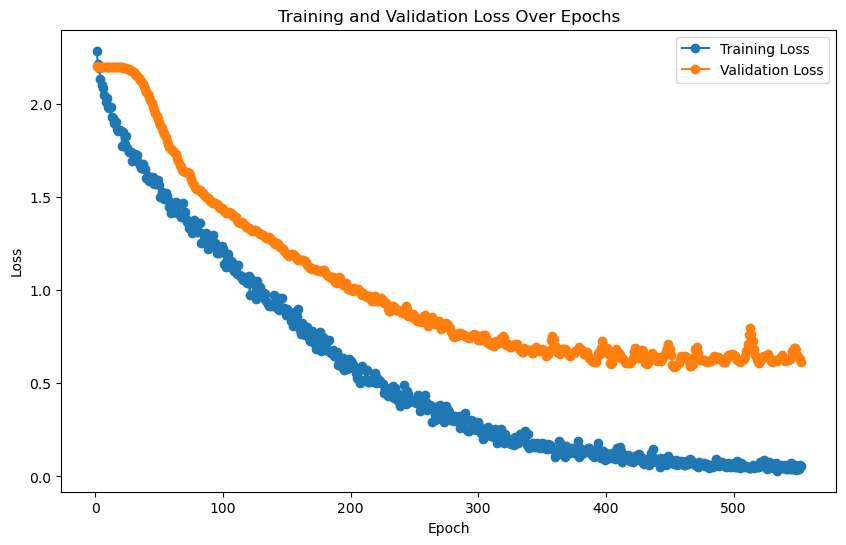

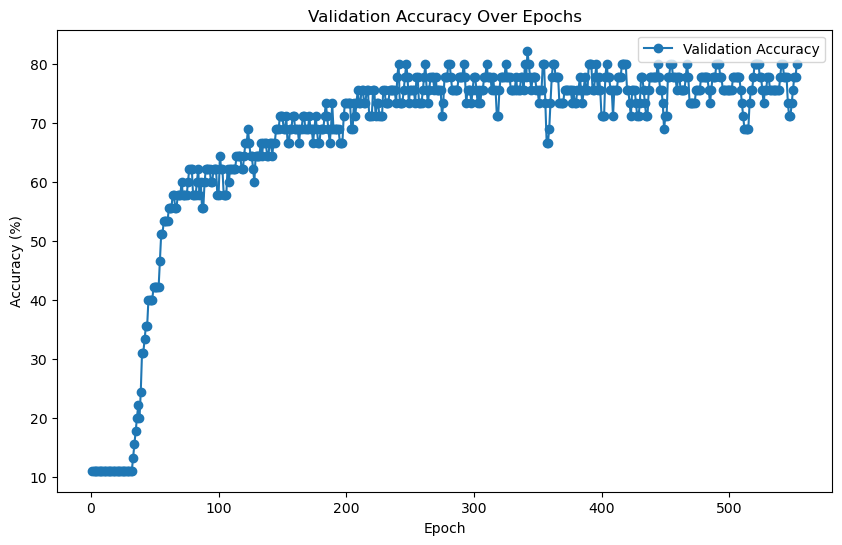


Evaluating on the test set...
    Test Batch [1/167], Loss: 1.0156



Final Test Loss: 0.9389, Test Accuracy: 69.50%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.
  Processed batch 30/167 for test dataset.


  Processed batch 40/167 for test dataset.
  Processed batch 50/167 for test dataset.
  Processed batch 60/167 for test dataset.
  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.


  Processed batch 90/167 for test dataset.
  Processed batch 100/167 for test dataset.
  Processed batch 110/167 for test dataset.
  Processed batch 120/167 for test dataset.
  Processed batch 130/167 for test dataset.


  Processed batch 140/167 for test dataset.
  Processed batch 150/167 for test dataset.
  Processed batch 160/167 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 42686 samples with 64 features each
LOG: Labels shape: (42686,)

LOG: Training features shape: (45, 64), Training labels shape: (45,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (42686, 64), Test labels shape: (42686,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 71.11%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       0.80      0.80      0.80         5
           2       0.50      0.40      0.44         5
           3       1.00      1.00      1.00         5
           4       1.00      0.80      0.89         5
           5       0.57      0.80      0.67         5
           6       0.50      1.00      0.67         5
           7       1.00      0.20      0.33         5
           8       1.00      1.00

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42686 samples with 64 features each
LOG: Labels shape: (42686,)
Train reps shape: (45, 64)
Train labels shape: (45,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (42686, 64)
Test labels shape: (42686,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.3105  |  Val Loss: 2.2217
Validation loss improved from inf to 2.2217.
[Epoch 2/1000] Train Loss: 2.2101  |  Val Loss: 2.1499
Validation loss improved from 2.2217 to 2.1499.
[Epoch 3/1000] Train Loss: 2.1241  |  Val Loss: 2.0984
Validation loss improved from 2.1499 to 2.0984.
[Epoch 4/1000] Train Loss: 2.0565  |  Val Loss: 2.0558
Validation loss improved from 2.0984 to 2.0558.
[Epoch 5/1000] Train Loss: 2.0052  |  Val Loss: 2.0150
Validation loss improved from 2.0558 to 2.0150.
[Epoch 6/1000] Train Loss: 1.9653  |  Val Loss: 1.9788
Validation loss improved from 2.0150 to 1.9788.
[Epoch 7/1000] Train Loss: 1.9321  |  Val Loss: 1.9446
Validation loss improved from 1.9788 to 1.9446.
[Epoch 8/1000] Train Loss: 1.8975  |  Val Loss: 1.9111
Validation loss improved from 1.9446 to 1.9111.
[Epoch 9/1000] Train Loss: 1.8612  |  Val Loss: 1.8788
Validation loss improved from 1.9111 to 1.8788.
[Epoch 10/1000] Train Loss: 1.8238  |  Val Loss: 1.8488
Validation loss impr

[Epoch 19/1000] Train Loss: 1.5289  |  Val Loss: 1.6242
Validation loss improved from 1.6496 to 1.6242.
[Epoch 20/1000] Train Loss: 1.4994  |  Val Loss: 1.5981
Validation loss improved from 1.6242 to 1.5981.
[Epoch 21/1000] Train Loss: 1.4693  |  Val Loss: 1.5713
Validation loss improved from 1.5981 to 1.5713.
[Epoch 22/1000] Train Loss: 1.4387  |  Val Loss: 1.5448
Validation loss improved from 1.5713 to 1.5448.
[Epoch 23/1000] Train Loss: 1.4082  |  Val Loss: 1.5195
Validation loss improved from 1.5448 to 1.5195.
[Epoch 24/1000] Train Loss: 1.3776  |  Val Loss: 1.4956
Validation loss improved from 1.5195 to 1.4956.
[Epoch 25/1000] Train Loss: 1.3477  |  Val Loss: 1.4713
Validation loss improved from 1.4956 to 1.4713.
[Epoch 26/1000] Train Loss: 1.3190  |  Val Loss: 1.4470
Validation loss improved from 1.4713 to 1.4470.
[Epoch 27/1000] Train Loss: 1.2905  |  Val Loss: 1.4221
Validation loss improved from 1.4470 to 1.4221.
[Epoch 28/1000] Train Loss: 1.2625  |  Val Loss: 1.3985
Validati

[Epoch 48/1000] Train Loss: 0.7293  |  Val Loss: 0.9901
Validation loss improved from 1.0071 to 0.9901.
[Epoch 49/1000] Train Loss: 0.7056  |  Val Loss: 0.9735
Validation loss improved from 0.9901 to 0.9735.
[Epoch 50/1000] Train Loss: 0.6828  |  Val Loss: 0.9586
Validation loss improved from 0.9735 to 0.9586.
[Epoch 51/1000] Train Loss: 0.6603  |  Val Loss: 0.9439
Validation loss improved from 0.9586 to 0.9439.
[Epoch 52/1000] Train Loss: 0.6385  |  Val Loss: 0.9294
Validation loss improved from 0.9439 to 0.9294.
[Epoch 53/1000] Train Loss: 0.6177  |  Val Loss: 0.9144
Validation loss improved from 0.9294 to 0.9144.
[Epoch 54/1000] Train Loss: 0.5977  |  Val Loss: 0.8998
Validation loss improved from 0.9144 to 0.8998.
[Epoch 55/1000] Train Loss: 0.5783  |  Val Loss: 0.8862
Validation loss improved from 0.8998 to 0.8862.
[Epoch 56/1000] Train Loss: 0.5596  |  Val Loss: 0.8735
Validation loss improved from 0.8862 to 0.8735.
[Epoch 57/1000] Train Loss: 0.5417  |  Val Loss: 0.8627
Validati

[Epoch 77/1000] Train Loss: 0.2984  |  Val Loss: 0.7429
Validation loss improved from 0.7443 to 0.7429.
[Epoch 78/1000] Train Loss: 0.2907  |  Val Loss: 0.7433
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 79/1000] Train Loss: 0.2835  |  Val Loss: 0.7455
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 80/1000] Train Loss: 0.2766  |  Val Loss: 0.7481
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 81/1000] Train Loss: 0.2700  |  Val Loss: 0.7490
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 82/1000] Train Loss: 0.2636  |  Val Loss: 0.7480
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 83/1000] Train Loss: 0.2574  |  Val Loss: 0.7467
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 84/1000] Train Loss: 0.2515  |  Val Loss: 0.7469
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 85/1000] Train Loss: 0.2460  |  Val Loss: 0.7511
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 86/1000] 

[Epoch 99/1000] Train Loss: 0.1835  |  Val Loss: 0.8174
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 100/1000] Train Loss: 0.1800  |  Val Loss: 0.8229
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 101/1000] Train Loss: 0.1767  |  Val Loss: 0.8285
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 102/1000] Train Loss: 0.1734  |  Val Loss: 0.8346
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 103/1000] Train Loss: 0.1702  |  Val Loss: 0.8401
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 104/1000] Train Loss: 0.1671  |  Val Loss: 0.8456
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 105/1000] Train Loss: 0.1641  |  Val Loss: 0.8514
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 106/1000] Train Loss: 0.1612  |  Val Loss: 0.8566
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 107/1000] Train Loss: 0.1583  |  Val Loss: 0.8617
!! Validation loss did NOT improve !! Patience: 

[Epoch 125/1000] Train Loss: 0.1169  |  Val Loss: 0.9765
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 126/1000] Train Loss: 0.1150  |  Val Loss: 0.9854
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 127/1000] Train Loss: 0.1132  |  Val Loss: 0.9921
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 128/1000] Train Loss: 0.1114  |  Val Loss: 0.9970
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 129/1000] Train Loss: 0.1096  |  Val Loss: 1.0018
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 130/1000] Train Loss: 0.1080  |  Val Loss: 1.0070
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 131/1000] Train Loss: 0.1063  |  Val Loss: 1.0122
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 132/1000] Train Loss: 0.1046  |  Val Loss: 1.0195
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 133/1000] Train Loss: 0.1030  |  Val Loss: 1.0265
!! Validation loss did NOT improve !! Patience:

[Epoch 148/1000] Train Loss: 0.0803  |  Val Loss: 1.1196
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 149/1000] Train Loss: 0.0789  |  Val Loss: 1.1257
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 150/1000] Train Loss: 0.0776  |  Val Loss: 1.1327
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 151/1000] Train Loss: 0.0762  |  Val Loss: 1.1395
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 152/1000] Train Loss: 0.0750  |  Val Loss: 1.1481
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 153/1000] Train Loss: 0.0737  |  Val Loss: 1.1549
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 154/1000] Train Loss: 0.0724  |  Val Loss: 1.1603
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 155/1000] Train Loss: 0.0712  |  Val Loss: 1.1681
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 156/1000] Train Loss: 0.0699  |  Val Loss: 1.1748
!! Validation loss did NOT improve !! Patience:

[Epoch 171/1000] Train Loss: 0.0524  |  Val Loss: 1.2564
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 172/1000] Train Loss: 0.0513  |  Val Loss: 1.2629
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 173/1000] Train Loss: 0.0503  |  Val Loss: 1.2692
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 174/1000] Train Loss: 0.0492  |  Val Loss: 1.2727
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 175/1000] Train Loss: 0.0482  |  Val Loss: 1.2746
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 176/1000] Train Loss: 0.0472  |  Val Loss: 1.2795
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 177/1000] Train Loss: 0.0461  |  Val Loss: 1.2884
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 177 !!
No improvement for 100 epochs.


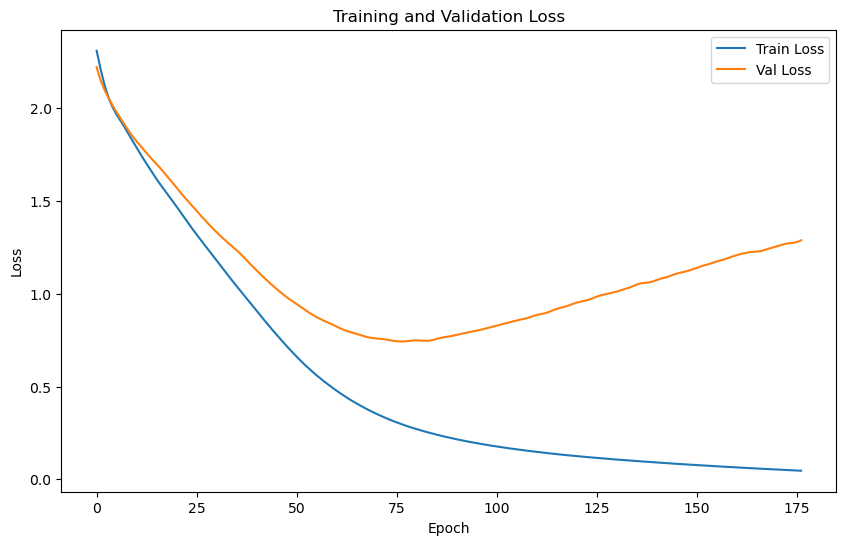

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.7114 | Test Accuracy: 58.70%


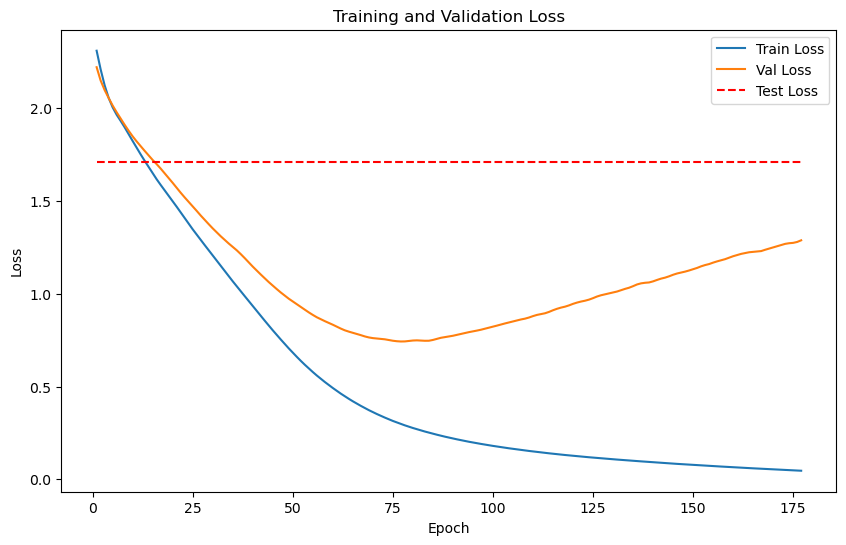

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42686 samples with 64 features each
LOG: Labels shape: (42686,)


Train embeddings shape: (45, 64), 
Train labels shape: (45,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42686, 64), 
Test labels shape: (42686,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Training batch size: 45


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.9083
Epoch [1/2000], Avg Train Loss: 8.9083


Epoch [1/2000], Avg Val Loss: 4.3249
Validation loss improved from inf to 4.3249. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.4645
Epoch [2/2000], Avg Train Loss: 8.4645
Epoch [2/2000], Avg Val Loss: 4.2892
Validation loss improved from 4.3249 to 4.2892. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.7572
Epoch [3/2000], Avg Train Loss: 8.7572
Epoch [3/2000], Avg Val Loss: 4.2531
Validation loss improved from 4.2892 to 4.2531. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.3353
Epoch [4/2000], Avg Train Loss: 8.3353
Epoch [4/2000], Avg Val Loss: 4.2170
Validation loss improved from 4.2531 to 4.2170. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.3606
Epoch [5/2000], Avg Train Loss: 8.3606
Epoch [5/2000], Avg Val Loss: 4.1820
Validation loss improved from 4.2170 to 4.1820. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 8.3507
Ep

Epoch [29/2000], Avg Val Loss: 3.4988
Validation loss improved from 3.5209 to 3.4988. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 6.7196
Epoch [30/2000], Avg Train Loss: 6.7196
Epoch [30/2000], Avg Val Loss: 3.4771
Validation loss improved from 3.4988 to 3.4771. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 6.4578
Epoch [31/2000], Avg Train Loss: 6.4578
Epoch [31/2000], Avg Val Loss: 3.4560
Validation loss improved from 3.4771 to 3.4560. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 6.2809
Epoch [32/2000], Avg Train Loss: 6.2809
Epoch [32/2000], Avg Val Loss: 3.4356
Validation loss improved from 3.4560 to 3.4356. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 6.7648
Epoch [33/2000], Avg Train Loss: 6.7648
Epoch [33/2000], Avg Val Loss: 3.4158
Validation loss improved from 3.4356 to 3.4158. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/1], Trai

Epoch [52/2000], Avg Val Loss: 3.1223
Validation loss improved from 3.1340 to 3.1223. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 6.1174
Epoch [53/2000], Avg Train Loss: 6.1174
Epoch [53/2000], Avg Val Loss: 3.1108
Validation loss improved from 3.1223 to 3.1108. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 6.1455
Epoch [54/2000], Avg Train Loss: 6.1455
Epoch [54/2000], Avg Val Loss: 3.0996
Validation loss improved from 3.1108 to 3.0996. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 5.5802
Epoch [55/2000], Avg Train Loss: 5.5802
Epoch [55/2000], Avg Val Loss: 3.0888
Validation loss improved from 3.0996 to 3.0888. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 5.6031
Epoch [56/2000], Avg Train Loss: 5.6031
Epoch [56/2000], Avg Val Loss: 3.0782
Validation loss improved from 3.0888 to 3.0782. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.3920
Epoch [77/2000], Avg Train Loss: 5.3920
Epoch [77/2000], Avg Val Loss: 2.9172
Validation loss improved from 2.9228 to 2.9172. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 4.9835
Epoch [78/2000], Avg Train Loss: 4.9835
Epoch [78/2000], Avg Val Loss: 2.9118
Validation loss improved from 2.9172 to 2.9118. Saving model...

LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 4.8776
Epoch [79/2000], Avg Train Loss: 4.8776
Epoch [79/2000], Avg Val Loss: 2.9065
Validation loss improved from 2.9118 to 2.9065. Saving model...

LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 4.6600
Epoch [80/2000], Avg Train Loss: 4.6600
Epoch [80/2000], Avg Val Loss: 2.9014
Validation loss improved from 2.9065 to 2.9014. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 4.7675
Epoch [81/2000], Avg Train Loss: 4.7675
Epoch [81/2000], Avg Val Loss: 2.8965
Validation loss improved from 2.9014 to 2.

    Batch [1/1], Train Loss: 4.3070
Epoch [102/2000], Avg Train Loss: 4.3070
Epoch [102/2000], Avg Val Loss: 2.8243
Validation loss improved from 2.8266 to 2.8243. Saving model...

LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 4.4344
Epoch [103/2000], Avg Train Loss: 4.4344
Epoch [103/2000], Avg Val Loss: 2.8221
Validation loss improved from 2.8243 to 2.8221. Saving model...

LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 4.2938
Epoch [104/2000], Avg Train Loss: 4.2938
Epoch [104/2000], Avg Val Loss: 2.8199
Validation loss improved from 2.8221 to 2.8199. Saving model...

LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 4.2701
Epoch [105/2000], Avg Train Loss: 4.2701
Epoch [105/2000], Avg Val Loss: 2.8178
Validation loss improved from 2.8199 to 2.8178. Saving model...

LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 4.0836
Epoch [106/2000], Avg Train Loss: 4.0836
Epoch [106/2000], Avg Val Loss: 2.8157
Validation loss improved fro

Epoch [126/2000], Avg Val Loss: 2.7863
Validation loss improved from 2.7874 to 2.7863. Saving model...

LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 3.8608
Epoch [127/2000], Avg Train Loss: 3.8608
Epoch [127/2000], Avg Val Loss: 2.7852
Validation loss improved from 2.7863 to 2.7852. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 3.7830
Epoch [128/2000], Avg Train Loss: 3.7830
Epoch [128/2000], Avg Val Loss: 2.7842
Validation loss improved from 2.7852 to 2.7842. Saving model...

LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 3.7288
Epoch [129/2000], Avg Train Loss: 3.7288
Epoch [129/2000], Avg Val Loss: 2.7831
Validation loss improved from 2.7842 to 2.7831. Saving model...

LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 3.8400
Epoch [130/2000], Avg Train Loss: 3.8400
Epoch [130/2000], Avg Val Loss: 2.7821
Validation loss improved from 2.7831 to 2.7821. Saving model...

LOG: Epoch [131/2000] - Training
    Bat

Epoch [152/2000], Avg Val Loss: 2.7661
Validation loss improved from 2.7667 to 2.7661. Saving model...

LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 3.5913
Epoch [153/2000], Avg Train Loss: 3.5913
Epoch [153/2000], Avg Val Loss: 2.7655
Validation loss improved from 2.7661 to 2.7655. Saving model...

LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 3.7379
Epoch [154/2000], Avg Train Loss: 3.7379
Epoch [154/2000], Avg Val Loss: 2.7650
Validation loss improved from 2.7655 to 2.7650. Saving model...

LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 3.7373
Epoch [155/2000], Avg Train Loss: 3.7373
Epoch [155/2000], Avg Val Loss: 2.7645
Validation loss improved from 2.7650 to 2.7645. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 3.5705
Epoch [156/2000], Avg Train Loss: 3.5705
Epoch [156/2000], Avg Val Loss: 2.7640
Validation loss improved from 2.7645 to 2.7640. Saving model...

LOG: Epoch [157/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.5015
Epoch [178/2000], Avg Train Loss: 3.5015
Epoch [178/2000], Avg Val Loss: 2.7559
Validation loss improved from 2.7562 to 2.7559. Saving model...

LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 3.5866
Epoch [179/2000], Avg Train Loss: 3.5866
Epoch [179/2000], Avg Val Loss: 2.7556
Validation loss improved from 2.7559 to 2.7556. Saving model...

LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 3.3534
Epoch [180/2000], Avg Train Loss: 3.3534
Epoch [180/2000], Avg Val Loss: 2.7553
Validation loss improved from 2.7556 to 2.7553. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 3.4254
Epoch [181/2000], Avg Train Loss: 3.4254
Epoch [181/2000], Avg Val Loss: 2.7550
Validation loss improved from 2.7553 to 2.7550. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 3.3531
Epoch [182/2000], Avg Train Loss: 3.3531
Epoch [182/2000], Avg Val Loss: 2.7548
Validation loss improved fro

Epoch [202/2000], Avg Train Loss: 3.3676
Epoch [202/2000], Avg Val Loss: 2.7492
Validation loss improved from 2.7495 to 2.7492. Saving model...

LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 3.3473
Epoch [203/2000], Avg Train Loss: 3.3473
Epoch [203/2000], Avg Val Loss: 2.7489
Validation loss improved from 2.7492 to 2.7489. Saving model...

LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 3.5329
Epoch [204/2000], Avg Train Loss: 3.5329
Epoch [204/2000], Avg Val Loss: 2.7486
Validation loss improved from 2.7489 to 2.7486. Saving model...

LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 3.3001
Epoch [205/2000], Avg Train Loss: 3.3001
Epoch [205/2000], Avg Val Loss: 2.7483
Validation loss improved from 2.7486 to 2.7483. Saving model...

LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 3.3061
Epoch [206/2000], Avg Train Loss: 3.3061
Epoch [206/2000], Avg Val Loss: 2.7480
Validation loss improved from 2.7483 to 2.7480. Saving model...


    Batch [1/1], Train Loss: 3.3451
Epoch [233/2000], Avg Train Loss: 3.3451
Epoch [233/2000], Avg Val Loss: 2.7393
Validation loss improved from 2.7396 to 2.7393. Saving model...

LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 3.2192
Epoch [234/2000], Avg Train Loss: 3.2192
Epoch [234/2000], Avg Val Loss: 2.7390
Validation loss improved from 2.7393 to 2.7390. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 3.1819
Epoch [235/2000], Avg Train Loss: 3.1819
Epoch [235/2000], Avg Val Loss: 2.7386
Validation loss improved from 2.7390 to 2.7386. Saving model...

LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 3.1617
Epoch [236/2000], Avg Train Loss: 3.1617
Epoch [236/2000], Avg Val Loss: 2.7382
Validation loss improved from 2.7386 to 2.7382. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 3.2414
Epoch [237/2000], Avg Train Loss: 3.2414
Epoch [237/2000], Avg Val Loss: 2.7378
Validation loss improved fro

Epoch [255/2000], Avg Val Loss: 2.7310
Validation loss improved from 2.7313 to 2.7310. Saving model...

LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 3.1459
Epoch [256/2000], Avg Train Loss: 3.1459
Epoch [256/2000], Avg Val Loss: 2.7306
Validation loss improved from 2.7310 to 2.7306. Saving model...

LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 3.1943
Epoch [257/2000], Avg Train Loss: 3.1943
Epoch [257/2000], Avg Val Loss: 2.7303
Validation loss improved from 2.7306 to 2.7303. Saving model...

LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 3.1506
Epoch [258/2000], Avg Train Loss: 3.1506
Epoch [258/2000], Avg Val Loss: 2.7300
Validation loss improved from 2.7303 to 2.7300. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 3.1555
Epoch [259/2000], Avg Train Loss: 3.1555
Epoch [259/2000], Avg Val Loss: 2.7296
Validation loss improved from 2.7300 to 2.7296. Saving model...

LOG: Epoch [260/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.0464
Epoch [284/2000], Avg Train Loss: 3.0464
Epoch [284/2000], Avg Val Loss: 2.7191
Validation loss improved from 2.7195 to 2.7191. Saving model...

LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 3.1029
Epoch [285/2000], Avg Train Loss: 3.1029
Epoch [285/2000], Avg Val Loss: 2.7187
Validation loss improved from 2.7191 to 2.7187. Saving model...

LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 3.0419
Epoch [286/2000], Avg Train Loss: 3.0419
Epoch [286/2000], Avg Val Loss: 2.7182
Validation loss improved from 2.7187 to 2.7182. Saving model...

LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 3.0006
Epoch [287/2000], Avg Train Loss: 3.0006
Epoch [287/2000], Avg Val Loss: 2.7178
Validation loss improved from 2.7182 to 2.7178. Saving model...

LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 3.0090
Epoch [288/2000], Avg Train Loss: 3.0090
Epoch [288/2000], Avg Val Loss: 2.7173
Validation loss improved fro

    Batch [1/1], Train Loss: 3.0129
Epoch [302/2000], Avg Train Loss: 3.0129
Epoch [302/2000], Avg Val Loss: 2.7109
Validation loss improved from 2.7114 to 2.7109. Saving model...

LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 3.0940
Epoch [303/2000], Avg Train Loss: 3.0940
Epoch [303/2000], Avg Val Loss: 2.7104
Validation loss improved from 2.7109 to 2.7104. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 3.0828
Epoch [304/2000], Avg Train Loss: 3.0828
Epoch [304/2000], Avg Val Loss: 2.7099
Validation loss improved from 2.7104 to 2.7099. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 3.0747
Epoch [305/2000], Avg Train Loss: 3.0747
Epoch [305/2000], Avg Val Loss: 2.7094
Validation loss improved from 2.7099 to 2.7094. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 2.9924
Epoch [306/2000], Avg Train Loss: 2.9924
Epoch [306/2000], Avg Val Loss: 2.7088
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9576
Epoch [332/2000], Avg Train Loss: 2.9576
Epoch [332/2000], Avg Val Loss: 2.6961
Validation loss improved from 2.6965 to 2.6961. Saving model...

LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 3.0091
Epoch [333/2000], Avg Train Loss: 3.0091
Epoch [333/2000], Avg Val Loss: 2.6956
Validation loss improved from 2.6961 to 2.6956. Saving model...

LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 3.0238
Epoch [334/2000], Avg Train Loss: 3.0238
Epoch [334/2000], Avg Val Loss: 2.6951
Validation loss improved from 2.6956 to 2.6951. Saving model...

LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 3.0149
Epoch [335/2000], Avg Train Loss: 3.0149
Epoch [335/2000], Avg Val Loss: 2.6946
Validation loss improved from 2.6951 to 2.6946. Saving model...

LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 2.9683
Epoch [336/2000], Avg Train Loss: 2.9683
Epoch [336/2000], Avg Val Loss: 2.6941
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9384
Epoch [353/2000], Avg Train Loss: 2.9384
Epoch [353/2000], Avg Val Loss: 2.6852
Validation loss improved from 2.6857 to 2.6852. Saving model...

LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 2.9285
Epoch [354/2000], Avg Train Loss: 2.9285
Epoch [354/2000], Avg Val Loss: 2.6847
Validation loss improved from 2.6852 to 2.6847. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 2.9534
Epoch [355/2000], Avg Train Loss: 2.9534
Epoch [355/2000], Avg Val Loss: 2.6842
Validation loss improved from 2.6847 to 2.6842. Saving model...

LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 3.0103
Epoch [356/2000], Avg Train Loss: 3.0103
Epoch [356/2000], Avg Val Loss: 2.6837
Validation loss improved from 2.6842 to 2.6837. Saving model...

LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 3.0181
Epoch [357/2000], Avg Train Loss: 3.0181
Epoch [357/2000], Avg Val Loss: 2.6832
Validation loss improved fro

Epoch [379/2000], Avg Val Loss: 2.6725
Validation loss improved from 2.6729 to 2.6725. Saving model...

LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 2.9336
Epoch [380/2000], Avg Train Loss: 2.9336
Epoch [380/2000], Avg Val Loss: 2.6720
Validation loss improved from 2.6725 to 2.6720. Saving model...

LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 2.8042
Epoch [381/2000], Avg Train Loss: 2.8042
Epoch [381/2000], Avg Val Loss: 2.6715
Validation loss improved from 2.6720 to 2.6715. Saving model...

LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 2.8495
Epoch [382/2000], Avg Train Loss: 2.8495
Epoch [382/2000], Avg Val Loss: 2.6710
Validation loss improved from 2.6715 to 2.6710. Saving model...

LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 2.8786
Epoch [383/2000], Avg Train Loss: 2.8786
Epoch [383/2000], Avg Val Loss: 2.6705
Validation loss improved from 2.6710 to 2.6705. Saving model...

LOG: Epoch [384/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.8460
Epoch [407/2000], Avg Train Loss: 2.8460
Epoch [407/2000], Avg Val Loss: 2.6594
Validation loss improved from 2.6599 to 2.6594. Saving model...

LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 2.9232
Epoch [408/2000], Avg Train Loss: 2.9232
Epoch [408/2000], Avg Val Loss: 2.6590
Validation loss improved from 2.6594 to 2.6590. Saving model...

LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 2.9125
Epoch [409/2000], Avg Train Loss: 2.9125
Epoch [409/2000], Avg Val Loss: 2.6585
Validation loss improved from 2.6590 to 2.6585. Saving model...

LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 2.8676
Epoch [410/2000], Avg Train Loss: 2.8676
Epoch [410/2000], Avg Val Loss: 2.6581
Validation loss improved from 2.6585 to 2.6581. Saving model...

LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 2.8331
Epoch [411/2000], Avg Train Loss: 2.8331
Epoch [411/2000], Avg Val Loss: 2.6577
Validation loss improved fro

    Batch [1/1], Train Loss: 2.8373
Epoch [427/2000], Avg Train Loss: 2.8373
Epoch [427/2000], Avg Val Loss: 2.6504
Validation loss improved from 2.6508 to 2.6504. Saving model...

LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 2.7287
Epoch [428/2000], Avg Train Loss: 2.7287
Epoch [428/2000], Avg Val Loss: 2.6500
Validation loss improved from 2.6504 to 2.6500. Saving model...

LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 2.9222
Epoch [429/2000], Avg Train Loss: 2.9222
Epoch [429/2000], Avg Val Loss: 2.6496
Validation loss improved from 2.6500 to 2.6496. Saving model...

LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 2.8462
Epoch [430/2000], Avg Train Loss: 2.8462
Epoch [430/2000], Avg Val Loss: 2.6492
Validation loss improved from 2.6496 to 2.6492. Saving model...

LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 2.8551
Epoch [431/2000], Avg Train Loss: 2.8551
Epoch [431/2000], Avg Val Loss: 2.6488
Validation loss improved fro

Epoch [454/2000], Avg Val Loss: 2.6384
Validation loss improved from 2.6388 to 2.6384. Saving model...

LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 2.6974
Epoch [455/2000], Avg Train Loss: 2.6974
Epoch [455/2000], Avg Val Loss: 2.6379
Validation loss improved from 2.6384 to 2.6379. Saving model...

LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 2.7366
Epoch [456/2000], Avg Train Loss: 2.7366
Epoch [456/2000], Avg Val Loss: 2.6374
Validation loss improved from 2.6379 to 2.6374. Saving model...

LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 2.8819
Epoch [457/2000], Avg Train Loss: 2.8819
Epoch [457/2000], Avg Val Loss: 2.6369
Validation loss improved from 2.6374 to 2.6369. Saving model...

LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 2.7952
Epoch [458/2000], Avg Train Loss: 2.7952
Epoch [458/2000], Avg Val Loss: 2.6365
Validation loss improved from 2.6369 to 2.6365. Saving model...

LOG: Epoch [459/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.7372
Epoch [477/2000], Avg Train Loss: 2.7372
Epoch [477/2000], Avg Val Loss: 2.6282
Validation loss improved from 2.6286 to 2.6282. Saving model...

LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 2.7297
Epoch [478/2000], Avg Train Loss: 2.7297
Epoch [478/2000], Avg Val Loss: 2.6277
Validation loss improved from 2.6282 to 2.6277. Saving model...

LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 2.7497
Epoch [479/2000], Avg Train Loss: 2.7497
Epoch [479/2000], Avg Val Loss: 2.6273
Validation loss improved from 2.6277 to 2.6273. Saving model...

LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 2.7434
Epoch [480/2000], Avg Train Loss: 2.7434
Epoch [480/2000], Avg Val Loss: 2.6268
Validation loss improved from 2.6273 to 2.6268. Saving model...

LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 2.7874
Epoch [481/2000], Avg Train Loss: 2.7874
Epoch [481/2000], Avg Val Loss: 2.6264
Validation loss improved fro

    Batch [1/1], Train Loss: 2.8135
Epoch [507/2000], Avg Train Loss: 2.8135
Epoch [507/2000], Avg Val Loss: 2.6169
Validation loss improved from 2.6172 to 2.6169. Saving model...

LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 2.6935
Epoch [508/2000], Avg Train Loss: 2.6935
Epoch [508/2000], Avg Val Loss: 2.6165
Validation loss improved from 2.6169 to 2.6165. Saving model...

LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 2.7069
Epoch [509/2000], Avg Train Loss: 2.7069
Epoch [509/2000], Avg Val Loss: 2.6162
Validation loss improved from 2.6165 to 2.6162. Saving model...

LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 2.7201
Epoch [510/2000], Avg Train Loss: 2.7201
Epoch [510/2000], Avg Val Loss: 2.6158
Validation loss improved from 2.6162 to 2.6158. Saving model...

LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 2.8057
Epoch [511/2000], Avg Train Loss: 2.8057
Epoch [511/2000], Avg Val Loss: 2.6154
Validation loss improved fro

Epoch [528/2000], Avg Val Loss: 2.6092
Validation loss improved from 2.6096 to 2.6092. Saving model...

LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 2.7494
Epoch [529/2000], Avg Train Loss: 2.7494
Epoch [529/2000], Avg Val Loss: 2.6088
Validation loss improved from 2.6092 to 2.6088. Saving model...

LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 2.6869
Epoch [530/2000], Avg Train Loss: 2.6869
Epoch [530/2000], Avg Val Loss: 2.6084
Validation loss improved from 2.6088 to 2.6084. Saving model...

LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 2.6896
Epoch [531/2000], Avg Train Loss: 2.6896
Epoch [531/2000], Avg Val Loss: 2.6081
Validation loss improved from 2.6084 to 2.6081. Saving model...

LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 2.6493
Epoch [532/2000], Avg Train Loss: 2.6493
Epoch [532/2000], Avg Val Loss: 2.6077
Validation loss improved from 2.6081 to 2.6077. Saving model...

LOG: Epoch [533/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.6813
Epoch [553/2000], Avg Train Loss: 2.6813
Epoch [553/2000], Avg Val Loss: 2.6012
Validation loss improved from 2.6015 to 2.6012. Saving model...

LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 2.6564
Epoch [554/2000], Avg Train Loss: 2.6564
Epoch [554/2000], Avg Val Loss: 2.6009
Validation loss improved from 2.6012 to 2.6009. Saving model...

LOG: Epoch [555/2000] - Training
    Batch [1/1], Train Loss: 2.7566
Epoch [555/2000], Avg Train Loss: 2.7566
Epoch [555/2000], Avg Val Loss: 2.6006
Validation loss improved from 2.6009 to 2.6006. Saving model...

LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 2.7060
Epoch [556/2000], Avg Train Loss: 2.7060
Epoch [556/2000], Avg Val Loss: 2.6004
Validation loss improved from 2.6006 to 2.6004. Saving model...

LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 2.6359
Epoch [557/2000], Avg Train Loss: 2.6359
Epoch [557/2000], Avg Val Loss: 2.6001
Validation loss improved fro

    Batch [1/1], Train Loss: 2.6294
Epoch [577/2000], Avg Train Loss: 2.6294
Epoch [577/2000], Avg Val Loss: 2.5932
Validation loss improved from 2.5935 to 2.5932. Saving model...

LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 2.5722
Epoch [578/2000], Avg Train Loss: 2.5722
Epoch [578/2000], Avg Val Loss: 2.5929
Validation loss improved from 2.5932 to 2.5929. Saving model...

LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 2.6511
Epoch [579/2000], Avg Train Loss: 2.6511
Epoch [579/2000], Avg Val Loss: 2.5926
Validation loss improved from 2.5929 to 2.5926. Saving model...

LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 2.6992
Epoch [580/2000], Avg Train Loss: 2.6992
Epoch [580/2000], Avg Val Loss: 2.5923
Validation loss improved from 2.5926 to 2.5923. Saving model...

LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 2.6546
Epoch [581/2000], Avg Train Loss: 2.6546
Epoch [581/2000], Avg Val Loss: 2.5920
Validation loss improved fro

Epoch [600/2000], Avg Val Loss: 2.5856
Validation loss improved from 2.5860 to 2.5856. Saving model...

LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 2.5593
Epoch [601/2000], Avg Train Loss: 2.5593
Epoch [601/2000], Avg Val Loss: 2.5853
Validation loss improved from 2.5856 to 2.5853. Saving model...

LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 2.6963
Epoch [602/2000], Avg Train Loss: 2.6963
Epoch [602/2000], Avg Val Loss: 2.5850
Validation loss improved from 2.5853 to 2.5850. Saving model...

LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 2.6908
Epoch [603/2000], Avg Train Loss: 2.6908
Epoch [603/2000], Avg Val Loss: 2.5847
Validation loss improved from 2.5850 to 2.5847. Saving model...

LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 2.6065
Epoch [604/2000], Avg Train Loss: 2.6065
Epoch [604/2000], Avg Val Loss: 2.5844
Validation loss improved from 2.5847 to 2.5844. Saving model...

LOG: Epoch [605/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.6060
Epoch [627/2000], Avg Train Loss: 2.6060
Epoch [627/2000], Avg Val Loss: 2.5789
Validation loss improved from 2.5792 to 2.5789. Saving model...

LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 2.6299
Epoch [628/2000], Avg Train Loss: 2.6299
Epoch [628/2000], Avg Val Loss: 2.5787
Validation loss improved from 2.5789 to 2.5787. Saving model...

LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 2.5343
Epoch [629/2000], Avg Train Loss: 2.5343
Epoch [629/2000], Avg Val Loss: 2.5785
Validation loss improved from 2.5787 to 2.5785. Saving model...

LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 2.5542
Epoch [630/2000], Avg Train Loss: 2.5542
Epoch [630/2000], Avg Val Loss: 2.5783
Validation loss improved from 2.5785 to 2.5783. Saving model...

LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 2.7153
Epoch [631/2000], Avg Train Loss: 2.7153
Epoch [631/2000], Avg Val Loss: 2.5781
Validation loss improved fro

Epoch [653/2000], Avg Val Loss: 2.5734
Validation loss improved from 2.5736 to 2.5734. Saving model...

LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 2.5876
Epoch [654/2000], Avg Train Loss: 2.5876
Epoch [654/2000], Avg Val Loss: 2.5732
Validation loss improved from 2.5734 to 2.5732. Saving model...

LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 2.6447
Epoch [655/2000], Avg Train Loss: 2.6447
Epoch [655/2000], Avg Val Loss: 2.5730
Validation loss improved from 2.5732 to 2.5730. Saving model...

LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 2.5544
Epoch [656/2000], Avg Train Loss: 2.5544
Epoch [656/2000], Avg Val Loss: 2.5728
Validation loss improved from 2.5730 to 2.5728. Saving model...

LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 2.5443
Epoch [657/2000], Avg Train Loss: 2.5443
Epoch [657/2000], Avg Val Loss: 2.5726
Validation loss improved from 2.5728 to 2.5726. Saving model...

LOG: Epoch [658/2000] - Training
    Bat

Epoch [676/2000], Avg Val Loss: 2.5680
Validation loss improved from 2.5682 to 2.5680. Saving model...

LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 2.5272
Epoch [677/2000], Avg Train Loss: 2.5272
Epoch [677/2000], Avg Val Loss: 2.5678
Validation loss improved from 2.5680 to 2.5678. Saving model...

LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 2.5880
Epoch [678/2000], Avg Train Loss: 2.5880
Epoch [678/2000], Avg Val Loss: 2.5676
Validation loss improved from 2.5678 to 2.5676. Saving model...

LOG: Epoch [679/2000] - Training
    Batch [1/1], Train Loss: 2.5088
Epoch [679/2000], Avg Train Loss: 2.5088
Epoch [679/2000], Avg Val Loss: 2.5674
Validation loss improved from 2.5676 to 2.5674. Saving model...

LOG: Epoch [680/2000] - Training
    Batch [1/1], Train Loss: 2.5287
Epoch [680/2000], Avg Train Loss: 2.5287
Epoch [680/2000], Avg Val Loss: 2.5672
Validation loss improved from 2.5674 to 2.5672. Saving model...

LOG: Epoch [681/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.5162
Epoch [695/2000], Avg Train Loss: 2.5162
Epoch [695/2000], Avg Val Loss: 2.5646
Validation loss improved from 2.5647 to 2.5646. Saving model...

LOG: Epoch [696/2000] - Training
    Batch [1/1], Train Loss: 2.6122
Epoch [696/2000], Avg Train Loss: 2.6122
Epoch [696/2000], Avg Val Loss: 2.5644
Validation loss improved from 2.5646 to 2.5644. Saving model...

LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 2.4991
Epoch [697/2000], Avg Train Loss: 2.4991
Epoch [697/2000], Avg Val Loss: 2.5643
Validation loss improved from 2.5644 to 2.5643. Saving model...

LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 2.5140
Epoch [698/2000], Avg Train Loss: 2.5140
Epoch [698/2000], Avg Val Loss: 2.5641
Validation loss improved from 2.5643 to 2.5641. Saving model...

LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 2.5940
Epoch [699/2000], Avg Train Loss: 2.5940
Epoch [699/2000], Avg Val Loss: 2.5639
Validation loss improved fro

    Batch [1/1], Train Loss: 2.5165
Epoch [725/2000], Avg Train Loss: 2.5165
Epoch [725/2000], Avg Val Loss: 2.5592
Validation loss improved from 2.5593 to 2.5592. Saving model...

LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 2.4695
Epoch [726/2000], Avg Train Loss: 2.4695
Epoch [726/2000], Avg Val Loss: 2.5591
Validation loss improved from 2.5592 to 2.5591. Saving model...

LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 2.4347
Epoch [727/2000], Avg Train Loss: 2.4347
Epoch [727/2000], Avg Val Loss: 2.5590
Validation loss improved from 2.5591 to 2.5590. Saving model...

LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 2.4602
Epoch [728/2000], Avg Train Loss: 2.4602
Epoch [728/2000], Avg Val Loss: 2.5589
Validation loss improved from 2.5590 to 2.5589. Saving model...

LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 2.5404
Epoch [729/2000], Avg Train Loss: 2.5404
Epoch [729/2000], Avg Val Loss: 2.5588
Validation loss improved fro

Epoch [745/2000], Avg Val Loss: 2.5573
Validation loss improved from 2.5574 to 2.5573. Saving model...

LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 2.4921
Epoch [746/2000], Avg Train Loss: 2.4921
Epoch [746/2000], Avg Val Loss: 2.5572
Validation loss improved from 2.5573 to 2.5572. Saving model...

LOG: Epoch [747/2000] - Training
    Batch [1/1], Train Loss: 2.4126
Epoch [747/2000], Avg Train Loss: 2.4126
Epoch [747/2000], Avg Val Loss: 2.5572
Validation loss improved from 2.5572 to 2.5572. Saving model...

LOG: Epoch [748/2000] - Training
    Batch [1/1], Train Loss: 2.5194
Epoch [748/2000], Avg Train Loss: 2.5194
Epoch [748/2000], Avg Val Loss: 2.5571
Validation loss improved from 2.5572 to 2.5571. Saving model...

LOG: Epoch [749/2000] - Training
    Batch [1/1], Train Loss: 2.4804
Epoch [749/2000], Avg Train Loss: 2.4804
Epoch [749/2000], Avg Val Loss: 2.5570
Validation loss improved from 2.5571 to 2.5570. Saving model...

LOG: Epoch [750/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.5545
Epoch [779/2000], Avg Train Loss: 2.5545
Epoch [779/2000], Avg Val Loss: 2.5547
Validation loss improved from 2.5548 to 2.5547. Saving model...

LOG: Epoch [780/2000] - Training
    Batch [1/1], Train Loss: 2.4679
Epoch [780/2000], Avg Train Loss: 2.4679
Epoch [780/2000], Avg Val Loss: 2.5547
Validation loss improved from 2.5547 to 2.5547. Saving model...

LOG: Epoch [781/2000] - Training
    Batch [1/1], Train Loss: 2.4413
Epoch [781/2000], Avg Train Loss: 2.4413
Epoch [781/2000], Avg Val Loss: 2.5546
Validation loss improved from 2.5547 to 2.5546. Saving model...

LOG: Epoch [782/2000] - Training
    Batch [1/1], Train Loss: 2.4472
Epoch [782/2000], Avg Train Loss: 2.4472
Epoch [782/2000], Avg Val Loss: 2.5545
Validation loss improved from 2.5546 to 2.5545. Saving model...

LOG: Epoch [783/2000] - Training
    Batch [1/1], Train Loss: 2.5217
Epoch [783/2000], Avg Train Loss: 2.5217
Epoch [783/2000], Avg Val Loss: 2.5545
Validation loss improved fro

    Batch [1/1], Train Loss: 2.4805
Epoch [796/2000], Avg Train Loss: 2.4805
Epoch [796/2000], Avg Val Loss: 2.5539
Validation loss improved from 2.5540 to 2.5539. Saving model...

LOG: Epoch [797/2000] - Training
    Batch [1/1], Train Loss: 2.4609
Epoch [797/2000], Avg Train Loss: 2.4609
Epoch [797/2000], Avg Val Loss: 2.5539
Validation loss improved from 2.5539 to 2.5539. Saving model...

LOG: Epoch [798/2000] - Training
    Batch [1/1], Train Loss: 2.4255
Epoch [798/2000], Avg Train Loss: 2.4255
Epoch [798/2000], Avg Val Loss: 2.5538
Validation loss improved from 2.5539 to 2.5538. Saving model...

LOG: Epoch [799/2000] - Training
    Batch [1/1], Train Loss: 2.5098
Epoch [799/2000], Avg Train Loss: 2.5098
Epoch [799/2000], Avg Val Loss: 2.5538
Validation loss improved from 2.5538 to 2.5538. Saving model...

LOG: Epoch [800/2000] - Training
    Batch [1/1], Train Loss: 2.4527
Epoch [800/2000], Avg Train Loss: 2.4527
Epoch [800/2000], Avg Val Loss: 2.5537
Validation loss improved fro

    Batch [1/1], Train Loss: 2.4493
Epoch [824/2000], Avg Train Loss: 2.4493
Epoch [824/2000], Avg Val Loss: 2.5525
Validation loss did not improve. Patience: 4/100

LOG: Epoch [825/2000] - Training
    Batch [1/1], Train Loss: 2.4300
Epoch [825/2000], Avg Train Loss: 2.4300
Epoch [825/2000], Avg Val Loss: 2.5526
Validation loss did not improve. Patience: 5/100

LOG: Epoch [826/2000] - Training
    Batch [1/1], Train Loss: 2.3959
Epoch [826/2000], Avg Train Loss: 2.3959
Epoch [826/2000], Avg Val Loss: 2.5526
Validation loss did not improve. Patience: 6/100

LOG: Epoch [827/2000] - Training
    Batch [1/1], Train Loss: 2.4273
Epoch [827/2000], Avg Train Loss: 2.4273
Epoch [827/2000], Avg Val Loss: 2.5526
Validation loss did not improve. Patience: 7/100

LOG: Epoch [828/2000] - Training
    Batch [1/1], Train Loss: 2.4140
Epoch [828/2000], Avg Train Loss: 2.4140
Epoch [828/2000], Avg Val Loss: 2.5527
Validation loss did not improve. Patience: 8/100

LOG: Epoch [829/2000] - Training
    B

Epoch [845/2000], Avg Val Loss: 2.5536
Validation loss did not improve. Patience: 25/100

LOG: Epoch [846/2000] - Training
    Batch [1/1], Train Loss: 2.4153
Epoch [846/2000], Avg Train Loss: 2.4153
Epoch [846/2000], Avg Val Loss: 2.5536
Validation loss did not improve. Patience: 26/100

LOG: Epoch [847/2000] - Training
    Batch [1/1], Train Loss: 2.4649
Epoch [847/2000], Avg Train Loss: 2.4649
Epoch [847/2000], Avg Val Loss: 2.5537
Validation loss did not improve. Patience: 27/100

LOG: Epoch [848/2000] - Training
    Batch [1/1], Train Loss: 2.4156
Epoch [848/2000], Avg Train Loss: 2.4156
Epoch [848/2000], Avg Val Loss: 2.5538
Validation loss did not improve. Patience: 28/100

LOG: Epoch [849/2000] - Training
    Batch [1/1], Train Loss: 2.4306
Epoch [849/2000], Avg Train Loss: 2.4306
Epoch [849/2000], Avg Val Loss: 2.5539
Validation loss did not improve. Patience: 29/100

LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 2.3684
Epoch [850/2000], Avg Train Loss: 2.3684


    Batch [1/1], Train Loss: 2.4098
Epoch [875/2000], Avg Train Loss: 2.4098
Epoch [875/2000], Avg Val Loss: 2.5558
Validation loss did not improve. Patience: 55/100

LOG: Epoch [876/2000] - Training
    Batch [1/1], Train Loss: 2.3429
Epoch [876/2000], Avg Train Loss: 2.3429
Epoch [876/2000], Avg Val Loss: 2.5559
Validation loss did not improve. Patience: 56/100

LOG: Epoch [877/2000] - Training
    Batch [1/1], Train Loss: 2.3759
Epoch [877/2000], Avg Train Loss: 2.3759
Epoch [877/2000], Avg Val Loss: 2.5560
Validation loss did not improve. Patience: 57/100

LOG: Epoch [878/2000] - Training
    Batch [1/1], Train Loss: 2.3913
Epoch [878/2000], Avg Train Loss: 2.3913
Epoch [878/2000], Avg Val Loss: 2.5561
Validation loss did not improve. Patience: 58/100

LOG: Epoch [879/2000] - Training
    Batch [1/1], Train Loss: 2.4749
Epoch [879/2000], Avg Train Loss: 2.4749
Epoch [879/2000], Avg Val Loss: 2.5562
Validation loss did not improve. Patience: 59/100

LOG: Epoch [880/2000] - Training


    Batch [1/1], Train Loss: 2.3961
Epoch [898/2000], Avg Train Loss: 2.3961
Epoch [898/2000], Avg Val Loss: 2.5572
Validation loss did not improve. Patience: 78/100

LOG: Epoch [899/2000] - Training
    Batch [1/1], Train Loss: 2.4156
Epoch [899/2000], Avg Train Loss: 2.4156
Epoch [899/2000], Avg Val Loss: 2.5574
Validation loss did not improve. Patience: 79/100

LOG: Epoch [900/2000] - Training
    Batch [1/1], Train Loss: 2.3949
Epoch [900/2000], Avg Train Loss: 2.3949
Epoch [900/2000], Avg Val Loss: 2.5575
Validation loss did not improve. Patience: 80/100

LOG: Epoch [901/2000] - Training
    Batch [1/1], Train Loss: 2.4211
Epoch [901/2000], Avg Train Loss: 2.4211
Epoch [901/2000], Avg Val Loss: 2.5576
Validation loss did not improve. Patience: 81/100

LOG: Epoch [902/2000] - Training
    Batch [1/1], Train Loss: 2.4225
Epoch [902/2000], Avg Train Loss: 2.4225
Epoch [902/2000], Avg Val Loss: 2.5577
Validation loss did not improve. Patience: 82/100

LOG: Epoch [903/2000] - Training


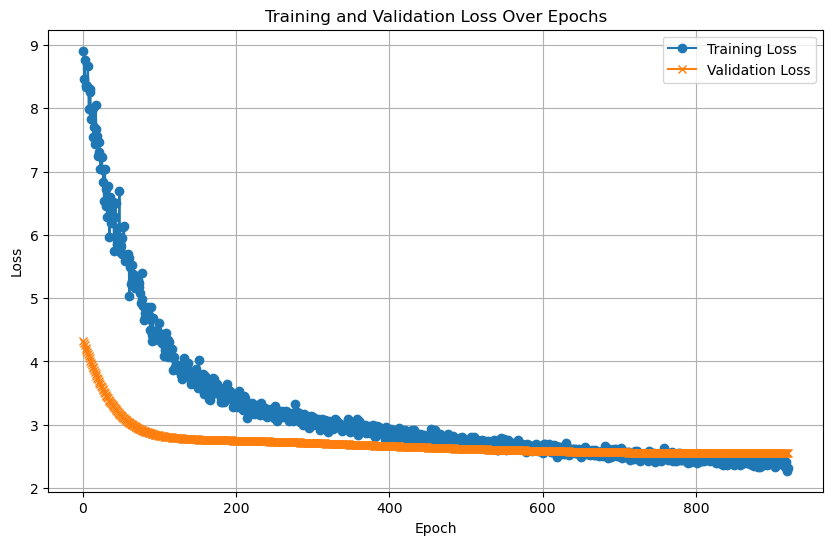

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/167], Loss: 5.8294
Test Batch [20/167], Loss: 5.4311
Test Batch [30/167], Loss: 5.3011
Test Batch [40/167], Loss: 5.1628
Test Batch [50/167], Loss: 5.3148
Test Batch [60/167], Loss: 5.9458
Test Batch [70/167], Loss: 5.7282
Test Batch [80/167], Loss: 4.4532
Test Batch [90/167], Loss: 4.8239
Test Batch [100/167], Loss: 5.1869
Test Batch [110/167], Loss: 5.1584
Test Batch [120/167], Loss: 5.0063
Test Batch [130/167], Loss: 5.2733
Test Batch [140/167], Loss: 5.2488
Test Batch [150/167], Loss: 5.0020
Test Batch [160/167], Loss: 5.3930



Test Loss: 5.3184


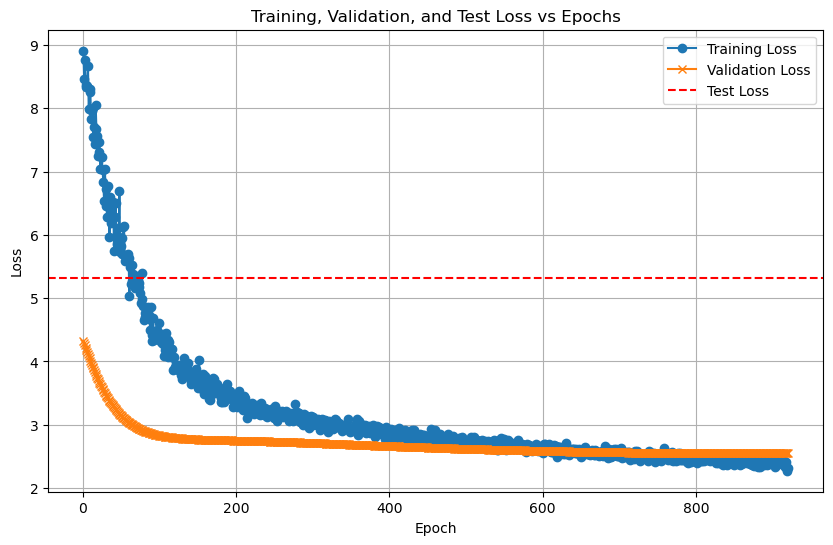

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.
  Processed batch 30/167 for test dataset.


  Processed batch 40/167 for test dataset.
  Processed batch 50/167 for test dataset.


  Processed batch 60/167 for test dataset.
  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.
  Processed batch 90/167 for test dataset.
  Processed batch 100/167 for test dataset.


  Processed batch 110/167 for test dataset.
  Processed batch 120/167 for test dataset.


  Processed batch 130/167 for test dataset.
  Processed batch 140/167 for test dataset.
  Processed batch 150/167 for test dataset.
  Processed batch 160/167 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42686, 128)
Test labels shape: (42686,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 75.56%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.80      0.80      0.80         5
           2       0.60      0.60      0.60         5
           3       1.00      0.80      0.89         5
           4       1.00      0.80      0.89         5
           5       0.57      0.80      0.67         5
           6       0.62      1.00      0.77         5
           7       1.00      0.20      0.33         5
           8       1.00      1.00      1.00         5

    accuracy                           0.76        45
   macro avg       0.81      0.76      0.74        45
weighted avg       0.81      0.76      0.74        45


LOG: Evaluating on the test set...
Test Accuracy: 61.26%

Test Classifica

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42686, 128)
Test labels shape: (42686,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5926  |  Val Loss: 2.5888
Validation loss improved from inf to 2.5888.


[Epoch 2/1000] Train Loss: 2.5751  |  Val Loss: 2.5724
Validation loss improved from 2.5888 to 2.5724.
[Epoch 3/1000] Train Loss: 2.5579  |  Val Loss: 2.5562
Validation loss improved from 2.5724 to 2.5562.
[Epoch 4/1000] Train Loss: 2.5409  |  Val Loss: 2.5404
Validation loss improved from 2.5562 to 2.5404.
[Epoch 5/1000] Train Loss: 2.5242  |  Val Loss: 2.5249
Validation loss improved from 2.5404 to 2.5249.
[Epoch 6/1000] Train Loss: 2.5079  |  Val Loss: 2.5097
Validation loss improved from 2.5249 to 2.5097.
[Epoch 7/1000] Train Loss: 2.4920  |  Val Loss: 2.4948
Validation loss improved from 2.5097 to 2.4948.
[Epoch 8/1000] Train Loss: 2.4763  |  Val Loss: 2.4802
Validation loss improved from 2.4948 to 2.4802.
[Epoch 9/1000] Train Loss: 2.4608  |  Val Loss: 2.4658
Validation loss improved from 2.4802 to 2.4658.
[Epoch 10/1000] Train Loss: 2.4455  |  Val Loss: 2.4515
Validation loss improved from 2.4658 to 2.4515.
[Epoch 11/1000] Train Loss: 2.4304  |  Val Loss: 2.4375
Validation loss 

[Epoch 69/1000] Train Loss: 1.8463  |  Val Loss: 1.8968
Validation loss improved from 1.9024 to 1.8968.
[Epoch 70/1000] Train Loss: 1.8403  |  Val Loss: 1.8913
Validation loss improved from 1.8968 to 1.8913.
[Epoch 71/1000] Train Loss: 1.8344  |  Val Loss: 1.8859
Validation loss improved from 1.8913 to 1.8859.
[Epoch 72/1000] Train Loss: 1.8285  |  Val Loss: 1.8806
Validation loss improved from 1.8859 to 1.8806.
[Epoch 73/1000] Train Loss: 1.8227  |  Val Loss: 1.8754
Validation loss improved from 1.8806 to 1.8754.
[Epoch 74/1000] Train Loss: 1.8168  |  Val Loss: 1.8702
Validation loss improved from 1.8754 to 1.8702.
[Epoch 75/1000] Train Loss: 1.8110  |  Val Loss: 1.8650
Validation loss improved from 1.8702 to 1.8650.
[Epoch 76/1000] Train Loss: 1.8052  |  Val Loss: 1.8599
Validation loss improved from 1.8650 to 1.8599.
[Epoch 77/1000] Train Loss: 1.7994  |  Val Loss: 1.8548
Validation loss improved from 1.8599 to 1.8548.
[Epoch 78/1000] Train Loss: 1.7936  |  Val Loss: 1.8497
Validati

[Epoch 150/1000] Train Loss: 1.4289  |  Val Loss: 1.5361
Validation loss improved from 1.5402 to 1.5361.
[Epoch 151/1000] Train Loss: 1.4239  |  Val Loss: 1.5319
Validation loss improved from 1.5361 to 1.5319.
[Epoch 152/1000] Train Loss: 1.4189  |  Val Loss: 1.5277
Validation loss improved from 1.5319 to 1.5277.
[Epoch 153/1000] Train Loss: 1.4140  |  Val Loss: 1.5236
Validation loss improved from 1.5277 to 1.5236.
[Epoch 154/1000] Train Loss: 1.4090  |  Val Loss: 1.5194
Validation loss improved from 1.5236 to 1.5194.
[Epoch 155/1000] Train Loss: 1.4039  |  Val Loss: 1.5152
Validation loss improved from 1.5194 to 1.5152.
[Epoch 156/1000] Train Loss: 1.3988  |  Val Loss: 1.5111
Validation loss improved from 1.5152 to 1.5111.
[Epoch 157/1000] Train Loss: 1.3937  |  Val Loss: 1.5070
Validation loss improved from 1.5111 to 1.5070.
[Epoch 158/1000] Train Loss: 1.3886  |  Val Loss: 1.5030
Validation loss improved from 1.5070 to 1.5030.
[Epoch 159/1000] Train Loss: 1.3835  |  Val Loss: 1.499

[Epoch 223/1000] Train Loss: 1.0963  |  Val Loss: 1.2732
Validation loss improved from 1.2764 to 1.2732.
[Epoch 224/1000] Train Loss: 1.0923  |  Val Loss: 1.2701
Validation loss improved from 1.2732 to 1.2701.
[Epoch 225/1000] Train Loss: 1.0884  |  Val Loss: 1.2669
Validation loss improved from 1.2701 to 1.2669.
[Epoch 226/1000] Train Loss: 1.0845  |  Val Loss: 1.2638
Validation loss improved from 1.2669 to 1.2638.
[Epoch 227/1000] Train Loss: 1.0807  |  Val Loss: 1.2607
Validation loss improved from 1.2638 to 1.2607.
[Epoch 228/1000] Train Loss: 1.0768  |  Val Loss: 1.2576
Validation loss improved from 1.2607 to 1.2576.
[Epoch 229/1000] Train Loss: 1.0730  |  Val Loss: 1.2546
Validation loss improved from 1.2576 to 1.2546.
[Epoch 230/1000] Train Loss: 1.0692  |  Val Loss: 1.2516
Validation loss improved from 1.2546 to 1.2516.
[Epoch 231/1000] Train Loss: 1.0654  |  Val Loss: 1.2487
Validation loss improved from 1.2516 to 1.2487.
[Epoch 232/1000] Train Loss: 1.0615  |  Val Loss: 1.245

[Epoch 303/1000] Train Loss: 0.8213  |  Val Loss: 1.0654
Validation loss improved from 1.0678 to 1.0654.
[Epoch 304/1000] Train Loss: 0.8182  |  Val Loss: 1.0631
Validation loss improved from 1.0654 to 1.0631.
[Epoch 305/1000] Train Loss: 0.8152  |  Val Loss: 1.0608
Validation loss improved from 1.0631 to 1.0608.
[Epoch 306/1000] Train Loss: 0.8121  |  Val Loss: 1.0584
Validation loss improved from 1.0608 to 1.0584.
[Epoch 307/1000] Train Loss: 0.8091  |  Val Loss: 1.0561
Validation loss improved from 1.0584 to 1.0561.
[Epoch 308/1000] Train Loss: 0.8061  |  Val Loss: 1.0538
Validation loss improved from 1.0561 to 1.0538.
[Epoch 309/1000] Train Loss: 0.8030  |  Val Loss: 1.0515
Validation loss improved from 1.0538 to 1.0515.
[Epoch 310/1000] Train Loss: 0.8000  |  Val Loss: 1.0493
Validation loss improved from 1.0515 to 1.0493.
[Epoch 311/1000] Train Loss: 0.7970  |  Val Loss: 1.0470
Validation loss improved from 1.0493 to 1.0470.
[Epoch 312/1000] Train Loss: 0.7940  |  Val Loss: 1.044

[Epoch 382/1000] Train Loss: 0.5955  |  Val Loss: 0.8886
Validation loss improved from 0.8908 to 0.8886.
[Epoch 383/1000] Train Loss: 0.5927  |  Val Loss: 0.8864
Validation loss improved from 0.8886 to 0.8864.
[Epoch 384/1000] Train Loss: 0.5900  |  Val Loss: 0.8842
Validation loss improved from 0.8864 to 0.8842.
[Epoch 385/1000] Train Loss: 0.5873  |  Val Loss: 0.8820
Validation loss improved from 0.8842 to 0.8820.
[Epoch 386/1000] Train Loss: 0.5846  |  Val Loss: 0.8799
Validation loss improved from 0.8820 to 0.8799.
[Epoch 387/1000] Train Loss: 0.5819  |  Val Loss: 0.8778
Validation loss improved from 0.8799 to 0.8778.
[Epoch 388/1000] Train Loss: 0.5793  |  Val Loss: 0.8756
Validation loss improved from 0.8778 to 0.8756.
[Epoch 389/1000] Train Loss: 0.5766  |  Val Loss: 0.8735
Validation loss improved from 0.8756 to 0.8735.
[Epoch 390/1000] Train Loss: 0.5739  |  Val Loss: 0.8713
Validation loss improved from 0.8735 to 0.8713.
[Epoch 391/1000] Train Loss: 0.5712  |  Val Loss: 0.869

[Epoch 462/1000] Train Loss: 0.4071  |  Val Loss: 0.7345
Validation loss improved from 0.7362 to 0.7345.
[Epoch 463/1000] Train Loss: 0.4053  |  Val Loss: 0.7329
Validation loss improved from 0.7345 to 0.7329.
[Epoch 464/1000] Train Loss: 0.4036  |  Val Loss: 0.7313
Validation loss improved from 0.7329 to 0.7313.
[Epoch 465/1000] Train Loss: 0.4018  |  Val Loss: 0.7298
Validation loss improved from 0.7313 to 0.7298.
[Epoch 466/1000] Train Loss: 0.4001  |  Val Loss: 0.7284
Validation loss improved from 0.7298 to 0.7284.
[Epoch 467/1000] Train Loss: 0.3984  |  Val Loss: 0.7270
Validation loss improved from 0.7284 to 0.7270.
[Epoch 468/1000] Train Loss: 0.3967  |  Val Loss: 0.7256
Validation loss improved from 0.7270 to 0.7256.
[Epoch 469/1000] Train Loss: 0.3950  |  Val Loss: 0.7242
Validation loss improved from 0.7256 to 0.7242.
[Epoch 470/1000] Train Loss: 0.3933  |  Val Loss: 0.7229
Validation loss improved from 0.7242 to 0.7229.
[Epoch 471/1000] Train Loss: 0.3917  |  Val Loss: 0.721

[Epoch 540/1000] Train Loss: 0.2982  |  Val Loss: 0.6557
Validation loss improved from 0.6562 to 0.6557.
[Epoch 541/1000] Train Loss: 0.2972  |  Val Loss: 0.6551
Validation loss improved from 0.6557 to 0.6551.
[Epoch 542/1000] Train Loss: 0.2961  |  Val Loss: 0.6546
Validation loss improved from 0.6551 to 0.6546.
[Epoch 543/1000] Train Loss: 0.2951  |  Val Loss: 0.6540
Validation loss improved from 0.6546 to 0.6540.
[Epoch 544/1000] Train Loss: 0.2941  |  Val Loss: 0.6534
Validation loss improved from 0.6540 to 0.6534.
[Epoch 545/1000] Train Loss: 0.2931  |  Val Loss: 0.6529
Validation loss improved from 0.6534 to 0.6529.
[Epoch 546/1000] Train Loss: 0.2921  |  Val Loss: 0.6523
Validation loss improved from 0.6529 to 0.6523.
[Epoch 547/1000] Train Loss: 0.2911  |  Val Loss: 0.6517
Validation loss improved from 0.6523 to 0.6517.
[Epoch 548/1000] Train Loss: 0.2901  |  Val Loss: 0.6512
Validation loss improved from 0.6517 to 0.6512.
[Epoch 549/1000] Train Loss: 0.2891  |  Val Loss: 0.650

[Epoch 616/1000] Train Loss: 0.2356  |  Val Loss: 0.6259
Validation loss improved from 0.6261 to 0.6259.
[Epoch 617/1000] Train Loss: 0.2350  |  Val Loss: 0.6256
Validation loss improved from 0.6259 to 0.6256.
[Epoch 618/1000] Train Loss: 0.2343  |  Val Loss: 0.6254
Validation loss improved from 0.6256 to 0.6254.
[Epoch 619/1000] Train Loss: 0.2337  |  Val Loss: 0.6251
Validation loss improved from 0.6254 to 0.6251.
[Epoch 620/1000] Train Loss: 0.2330  |  Val Loss: 0.6249
Validation loss improved from 0.6251 to 0.6249.
[Epoch 621/1000] Train Loss: 0.2324  |  Val Loss: 0.6248
Validation loss improved from 0.6249 to 0.6248.
[Epoch 622/1000] Train Loss: 0.2318  |  Val Loss: 0.6245
Validation loss improved from 0.6248 to 0.6245.
[Epoch 623/1000] Train Loss: 0.2311  |  Val Loss: 0.6243
Validation loss improved from 0.6245 to 0.6243.
[Epoch 624/1000] Train Loss: 0.2305  |  Val Loss: 0.6239
Validation loss improved from 0.6243 to 0.6239.
[Epoch 625/1000] Train Loss: 0.2299  |  Val Loss: 0.623

[Epoch 689/1000] Train Loss: 0.1936  |  Val Loss: 0.6133
Validation loss improved from 0.6134 to 0.6133.
[Epoch 690/1000] Train Loss: 0.1931  |  Val Loss: 0.6131
Validation loss improved from 0.6133 to 0.6131.
[Epoch 691/1000] Train Loss: 0.1927  |  Val Loss: 0.6128
Validation loss improved from 0.6131 to 0.6128.
[Epoch 692/1000] Train Loss: 0.1922  |  Val Loss: 0.6126
Validation loss improved from 0.6128 to 0.6126.
[Epoch 693/1000] Train Loss: 0.1917  |  Val Loss: 0.6125
Validation loss improved from 0.6126 to 0.6125.
[Epoch 694/1000] Train Loss: 0.1912  |  Val Loss: 0.6125
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 695/1000] Train Loss: 0.1908  |  Val Loss: 0.6126
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 696/1000] Train Loss: 0.1903  |  Val Loss: 0.6126
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 697/1000] Train Loss: 0.1899  |  Val Loss: 0.6125
Validation loss improved from 0.6125 to 0.6125.
[Epoch 698/1000] Train Loss: 0.1894  

[Epoch 766/1000] Train Loss: 0.1622  |  Val Loss: 0.6114
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 767/1000] Train Loss: 0.1619  |  Val Loss: 0.6114
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 768/1000] Train Loss: 0.1615  |  Val Loss: 0.6114
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 769/1000] Train Loss: 0.1612  |  Val Loss: 0.6114
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 770/1000] Train Loss: 0.1608  |  Val Loss: 0.6114
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 771/1000] Train Loss: 0.1605  |  Val Loss: 0.6114
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 772/1000] Train Loss: 0.1602  |  Val Loss: 0.6115
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 773/1000] Train Loss: 0.1598  |  Val Loss: 0.6116
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 774/1000] Train Loss: 0.1595  |  Val Loss: 0.6118
!! Validation loss did NOT improve !! Patience:

[Epoch 844/1000] Train Loss: 0.1390  |  Val Loss: 0.6196
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 845/1000] Train Loss: 0.1387  |  Val Loss: 0.6197
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 846/1000] Train Loss: 0.1385  |  Val Loss: 0.6198
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 847/1000] Train Loss: 0.1382  |  Val Loss: 0.6200
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 848/1000] Train Loss: 0.1379  |  Val Loss: 0.6202
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 849/1000] Train Loss: 0.1377  |  Val Loss: 0.6204
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 850/1000] Train Loss: 0.1374  |  Val Loss: 0.6205
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 851/1000] Train Loss: 0.1372  |  Val Loss: 0.6206
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 852/1000] Train Loss: 0.1369  |  Val Loss: 0.6207
!! Validation loss did NOT improve !! Patience:

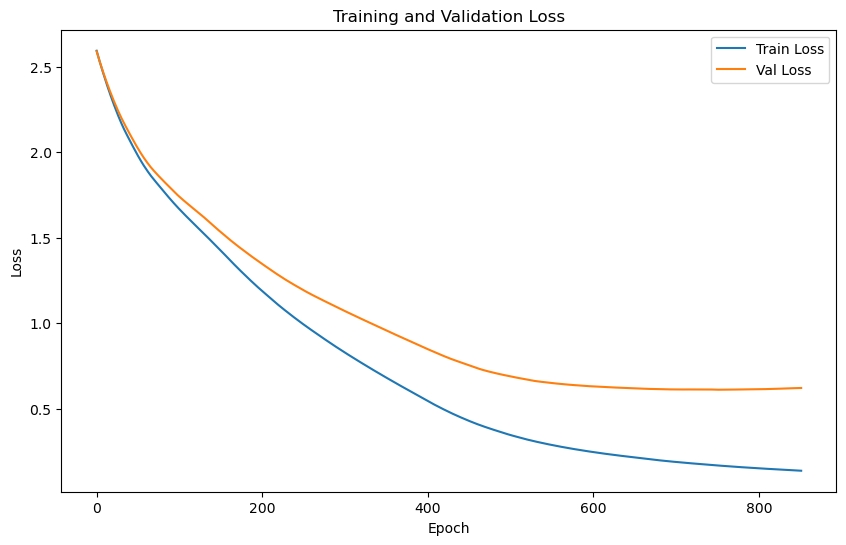

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.5995 | Test Accuracy: 61.28%


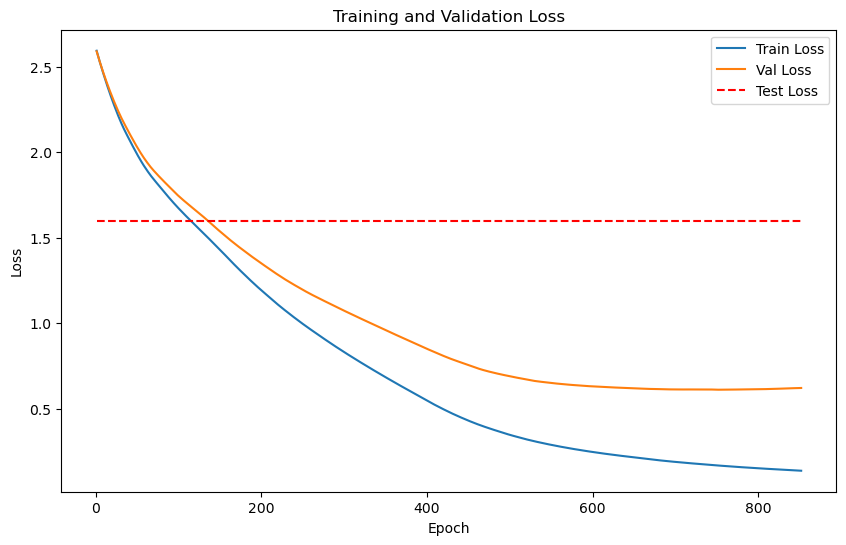

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42686 samples with 64 features each
LOG: Labels shape: (42686,)


Train embeddings shape: (45, 64), 
Train labels shape: (45,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42686, 64), 
Test labels shape: (42686,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Training batch size: 45


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4649
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.4450
Epoch [1/2000], Avg Train Loss: 0.4649, Avg Val Loss: 0.4450

Validation loss improved from inf to 0.4450. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4512
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.4427
Epoch [2/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.4427

Validation loss improved from 0.4450 to 0.4427. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [3/2000] - Validation


    Batch [1/1], Val Loss: 0.4409
Epoch [3/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.4409

Validation loss improved from 0.4427 to 0.4409. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4637
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.4398
Epoch [4/2000], Avg Train Loss: 0.4637, Avg Val Loss: 0.4398

Validation loss improved from 0.4409 to 0.4398. Saving model...
LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 0.4571
LOG: Epoch [5/2000] - Validation


    Batch [1/1], Val Loss: 0.4385
Epoch [5/2000], Avg Train Loss: 0.4571, Avg Val Loss: 0.4385

Validation loss improved from 0.4398 to 0.4385. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.4363
Epoch [6/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.4363

Validation loss improved from 0.4385 to 0.4363. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4595
LOG: Epoch [7/2000] - Validation
    Batch [1/1], Val Loss: 0.4343
Epoch [7/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.4343

Validation loss improved from 0.4363 to 0.4343. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4542
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.4322
Epoch [8/2000], Avg Train Loss: 0.4542, Avg Val Loss: 0.4322

Validation loss improved from 0.4343 to 0.4322. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [9/2000] - Validation


    Batch [1/1], Val Loss: 0.4296
Epoch [9/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.4296

Validation loss improved from 0.4322 to 0.4296. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.4270
Epoch [10/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.4270

Validation loss improved from 0.4296 to 0.4270. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.4583
LOG: Epoch [11/2000] - Validation


    Batch [1/1], Val Loss: 0.4250
Epoch [11/2000], Avg Train Loss: 0.4583, Avg Val Loss: 0.4250

Validation loss improved from 0.4270 to 0.4250. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.4231
Epoch [12/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.4231

Validation loss improved from 0.4250 to 0.4231. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.4426
LOG: Epoch [13/2000] - Validation


    Batch [1/1], Val Loss: 0.4214
Epoch [13/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.4214

Validation loss improved from 0.4231 to 0.4214. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.4203
Epoch [14/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.4203

Validation loss improved from 0.4214 to 0.4203. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.4426
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.4199
Epoch [15/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.4199

Validation loss improved from 0.4203 to 0.4199. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [16/2000] - Validation


    Batch [1/1], Val Loss: 0.4198
Epoch [16/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.4198

Validation loss improved from 0.4199 to 0.4198. Saving model...
LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 0.4599
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.4196
Epoch [17/2000], Avg Train Loss: 0.4599, Avg Val Loss: 0.4196

Validation loss improved from 0.4198 to 0.4196. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4372
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.4195
Epoch [18/2000], Avg Train Loss: 0.4372, Avg Val Loss: 0.4195

Validation loss improved from 0.4196 to 0.4195. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.4377
LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.4194
Epoch [19/2000], Avg Train Loss: 0.4377, Avg Val Loss: 0.4194

Validation loss improved from 0.4195 to 0.4194. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.4381
LOG: Epoch [20/2000] - Validation


    Batch [1/1], Val Loss: 0.4192
Epoch [20/2000], Avg Train Loss: 0.4381, Avg Val Loss: 0.4192

Validation loss improved from 0.4194 to 0.4192. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.4416
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.4192
Epoch [21/2000], Avg Train Loss: 0.4416, Avg Val Loss: 0.4192

Validation loss improved from 0.4192 to 0.4192. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.4398
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.4191
Epoch [22/2000], Avg Train Loss: 0.4398, Avg Val Loss: 0.4191

Validation loss improved from 0.4192 to 0.4191. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.4189
Epoch [23/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.4189

Validation loss improved from 0.4191 to 0.4189. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.4446
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.4186
Epoch [24/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.4186

Validation loss improved from 0.4189 to 0.4186. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4327
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.4183
Epoch [25/2000], Avg Train Loss: 0.4327, Avg Val Loss: 0.4183

Validation loss improved from 0.4186 to 0.4183. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.4180
Epoch [26/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.4180

Validation loss improved from 0.4183 to 0.4180. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [27/2000] - Validation
    Batch [1/1], Val Loss: 0.4176
Epoch [27/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.4176

Validation loss improved from 0.4180 to 0.4176. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.4303
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.4172
Epoch [28/2000], Avg Train Loss: 0.4303, Avg Val Loss: 0.4172

Validation loss improved from 0.4176 to 0.4172. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4391
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.4168
Epoch [29/2000], Avg Train Loss: 0.4391, Avg Val Loss: 0.4168

Validation loss improved from 0.4172 to 0.4168. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.4227
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.4164
Epoch [30/2000], Avg Train Loss: 0.4227, Avg Val Loss: 0.4164

Validation loss improved from 0.4168 to 0.4164. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.4246
LOG: Epoch [31/2000] - Validation


    Batch [1/1], Val Loss: 0.4159
Epoch [31/2000], Avg Train Loss: 0.4246, Avg Val Loss: 0.4159

Validation loss improved from 0.4164 to 0.4159. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.4272
LOG: Epoch [32/2000] - Validation
    Batch [1/1], Val Loss: 0.4154
Epoch [32/2000], Avg Train Loss: 0.4272, Avg Val Loss: 0.4154

Validation loss improved from 0.4159 to 0.4154. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.4289
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.4150
Epoch [33/2000], Avg Train Loss: 0.4289, Avg Val Loss: 0.4150

Validation loss improved from 0.4154 to 0.4150. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4236
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.4146
Epoch [34/2000], Avg Train Loss: 0.4236, Avg Val Loss: 0.4146

Validation loss improved from 0.4150 to 0.4146. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.4183
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.4141
Epoch [35/2000], Avg Train Loss: 0.4183, Avg Val Loss: 0.4141

Validation loss improved from 0.4146 to 0.4141. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4299
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.4137
Epoch [36/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.4137

Validation loss improved from 0.4141 to 0.4137. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.4133
Epoch [37/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.4133

Validation loss improved from 0.4137 to 0.4133. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4215
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.4129
Epoch [38/2000], Avg Train Loss: 0.4215, Avg Val Loss: 0.4129

Validation loss improved from 0.4133 to 0.4129. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.4158
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.4125
Epoch [39/2000], Avg Train Loss: 0.4158, Avg Val Loss: 0.4125

Validation loss improved from 0.4129 to 0.4125. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.4227
LOG: Epoch [40/2000] - Validation


    Batch [1/1], Val Loss: 0.4122
Epoch [40/2000], Avg Train Loss: 0.4227, Avg Val Loss: 0.4122

Validation loss improved from 0.4125 to 0.4122. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.4108
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.4118
Epoch [41/2000], Avg Train Loss: 0.4108, Avg Val Loss: 0.4118

Validation loss improved from 0.4122 to 0.4118. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.4156
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.4114
Epoch [42/2000], Avg Train Loss: 0.4156, Avg Val Loss: 0.4114

Validation loss improved from 0.4118 to 0.4114. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4215
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.4110
Epoch [43/2000], Avg Train Loss: 0.4215, Avg Val Loss: 0.4110

Validation loss improved from 0.4114 to 0.4110. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 0.4171
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.4107
Epoch [44/2000], Avg Train Loss: 0.4171, Avg Val Loss: 0.4107

Validation loss improved from 0.4110 to 0.4107. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.4151
LOG: Epoch [45/2000] - Validation


    Batch [1/1], Val Loss: 0.4104
Epoch [45/2000], Avg Train Loss: 0.4151, Avg Val Loss: 0.4104

Validation loss improved from 0.4107 to 0.4104. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.4142
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.4100
Epoch [46/2000], Avg Train Loss: 0.4142, Avg Val Loss: 0.4100

Validation loss improved from 0.4104 to 0.4100. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.4173
LOG: Epoch [47/2000] - Validation


    Batch [1/1], Val Loss: 0.4097
Epoch [47/2000], Avg Train Loss: 0.4173, Avg Val Loss: 0.4097

Validation loss improved from 0.4100 to 0.4097. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.4158
LOG: Epoch [48/2000] - Validation
    Batch [1/1], Val Loss: 0.4094
Epoch [48/2000], Avg Train Loss: 0.4158, Avg Val Loss: 0.4094

Validation loss improved from 0.4097 to 0.4094. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.4167
LOG: Epoch [49/2000] - Validation


    Batch [1/1], Val Loss: 0.4090
Epoch [49/2000], Avg Train Loss: 0.4167, Avg Val Loss: 0.4090

Validation loss improved from 0.4094 to 0.4090. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.4140
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.4087
Epoch [50/2000], Avg Train Loss: 0.4140, Avg Val Loss: 0.4087

Validation loss improved from 0.4090 to 0.4087. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [51/2000] - Validation


    Batch [1/1], Val Loss: 0.4084
Epoch [51/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.4084

Validation loss improved from 0.4087 to 0.4084. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.4108
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.4081
Epoch [52/2000], Avg Train Loss: 0.4108, Avg Val Loss: 0.4081

Validation loss improved from 0.4084 to 0.4081. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.4098
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.4078
Epoch [53/2000], Avg Train Loss: 0.4098, Avg Val Loss: 0.4078

Validation loss improved from 0.4081 to 0.4078. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.4075
Epoch [54/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.4075

Validation loss improved from 0.4078 to 0.4075. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.4093
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.4072
Epoch [55/2000], Avg Train Loss: 0.4093, Avg Val Loss: 0.4072

Validation loss improved from 0.4075 to 0.4072. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4056
LOG: Epoch [56/2000] - Validation
    Batch [1/1], Val Loss: 0.4069
Epoch [56/2000], Avg Train Loss: 0.4056, Avg Val Loss: 0.4069

Validation loss improved from 0.4072 to 0.4069. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.4065
Epoch [57/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.4065

Validation loss improved from 0.4069 to 0.4065. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [58/2000] - Validation


    Batch [1/1], Val Loss: 0.4062
Epoch [58/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.4062

Validation loss improved from 0.4065 to 0.4062. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.4106
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.4059
Epoch [59/2000], Avg Train Loss: 0.4106, Avg Val Loss: 0.4059

Validation loss improved from 0.4062 to 0.4059. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.4079
LOG: Epoch [60/2000] - Validation


    Batch [1/1], Val Loss: 0.4056
Epoch [60/2000], Avg Train Loss: 0.4079, Avg Val Loss: 0.4056

Validation loss improved from 0.4059 to 0.4056. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.4053
Epoch [61/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.4053

Validation loss improved from 0.4056 to 0.4053. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.4050
Epoch [62/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.4050

Validation loss improved from 0.4053 to 0.4050. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4087
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.4047
Epoch [63/2000], Avg Train Loss: 0.4087, Avg Val Loss: 0.4047

Validation loss improved from 0.4050 to 0.4047. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.4043
Epoch [64/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.4043

Validation loss improved from 0.4047 to 0.4043. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [65/2000] - Validation


    Batch [1/1], Val Loss: 0.4041
Epoch [65/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.4041

Validation loss improved from 0.4043 to 0.4041. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.4038
Epoch [66/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.4038

Validation loss improved from 0.4041 to 0.4038. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.4035
Epoch [67/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.4035

Validation loss improved from 0.4038 to 0.4035. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [68/2000] - Validation
    Batch [1/1], Val Loss: 0.4032
Epoch [68/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.4032

Validation loss improved from 0.4035 to 0.4032. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.4029
Epoch [69/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.4029

Validation loss improved from 0.4032 to 0.4029. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.4075
LOG: Epoch [70/2000] - Validation


    Batch [1/1], Val Loss: 0.4027
Epoch [70/2000], Avg Train Loss: 0.4075, Avg Val Loss: 0.4027

Validation loss improved from 0.4029 to 0.4027. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.4024
Epoch [71/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.4024

Validation loss improved from 0.4027 to 0.4024. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.4021
Epoch [72/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.4021

Validation loss improved from 0.4024 to 0.4021. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.4019
Epoch [73/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.4019

Validation loss improved from 0.4021 to 0.4019. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.4016
Epoch [74/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.4016

Validation loss improved from 0.4019 to 0.4016. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.3882
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.4013
Epoch [75/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.4013

Validation loss improved from 0.4016 to 0.4013. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.4011
Epoch [76/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.4011

Validation loss improved from 0.4013 to 0.4011. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.4009
Epoch [77/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.4009

Validation loss improved from 0.4011 to 0.4009. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.4006
Epoch [78/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.4006

Validation loss improved from 0.4009 to 0.4006. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.3807
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.4004
Epoch [79/2000], Avg Train Loss: 0.3807, Avg Val Loss: 0.4004

Validation loss improved from 0.4006 to 0.4004. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.4002
Epoch [80/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.4002

Validation loss improved from 0.4004 to 0.4002. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.3863
LOG: Epoch [81/2000] - Validation


    Batch [1/1], Val Loss: 0.3999
Epoch [81/2000], Avg Train Loss: 0.3863, Avg Val Loss: 0.3999

Validation loss improved from 0.4002 to 0.3999. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.3844
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.3997
Epoch [82/2000], Avg Train Loss: 0.3844, Avg Val Loss: 0.3997

Validation loss improved from 0.3999 to 0.3997. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.3823
LOG: Epoch [83/2000] - Validation


    Batch [1/1], Val Loss: 0.3994
Epoch [83/2000], Avg Train Loss: 0.3823, Avg Val Loss: 0.3994

Validation loss improved from 0.3997 to 0.3994. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.3992
Epoch [84/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.3992

Validation loss improved from 0.3994 to 0.3992. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.3814
LOG: Epoch [85/2000] - Validation


    Batch [1/1], Val Loss: 0.3990
Epoch [85/2000], Avg Train Loss: 0.3814, Avg Val Loss: 0.3990

Validation loss improved from 0.3992 to 0.3990. Saving model...
LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 0.3839
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.3988
Epoch [86/2000], Avg Train Loss: 0.3839, Avg Val Loss: 0.3988

Validation loss improved from 0.3990 to 0.3988. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.3866
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.3986
Epoch [87/2000], Avg Train Loss: 0.3866, Avg Val Loss: 0.3986

Validation loss improved from 0.3988 to 0.3986. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.3845
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.3984
Epoch [88/2000], Avg Train Loss: 0.3845, Avg Val Loss: 0.3984

Validation loss improved from 0.3986 to 0.3984. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.3839
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.3982
Epoch [89/2000], Avg Train Loss: 0.3839, Avg Val Loss: 0.3982

Validation loss improved from 0.3984 to 0.3982. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.3796
LOG: Epoch [90/2000] - Validation


    Batch [1/1], Val Loss: 0.3980
Epoch [90/2000], Avg Train Loss: 0.3796, Avg Val Loss: 0.3980

Validation loss improved from 0.3982 to 0.3980. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.3978
Epoch [91/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.3978

Validation loss improved from 0.3980 to 0.3978. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.3778
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.3976
Epoch [92/2000], Avg Train Loss: 0.3778, Avg Val Loss: 0.3976

Validation loss improved from 0.3978 to 0.3976. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.3974
Epoch [93/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.3974

Validation loss improved from 0.3976 to 0.3974. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.3824
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.3972
Epoch [94/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.3972

Validation loss improved from 0.3974 to 0.3972. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.3781
LOG: Epoch [95/2000] - Validation


    Batch [1/1], Val Loss: 0.3971
Epoch [95/2000], Avg Train Loss: 0.3781, Avg Val Loss: 0.3971

Validation loss improved from 0.3972 to 0.3971. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.3871
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.3969
Epoch [96/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.3969

Validation loss improved from 0.3971 to 0.3969. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.3811
LOG: Epoch [97/2000] - Validation


    Batch [1/1], Val Loss: 0.3967
Epoch [97/2000], Avg Train Loss: 0.3811, Avg Val Loss: 0.3967

Validation loss improved from 0.3969 to 0.3967. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.3966
Epoch [98/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.3966

Validation loss improved from 0.3967 to 0.3966. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.3797
LOG: Epoch [99/2000] - Validation


    Batch [1/1], Val Loss: 0.3964
Epoch [99/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.3964

Validation loss improved from 0.3966 to 0.3964. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.3851
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.3963
Epoch [100/2000], Avg Train Loss: 0.3851, Avg Val Loss: 0.3963

Validation loss improved from 0.3964 to 0.3963. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.3786
LOG: Epoch [101/2000] - Validation
    Batch [1/1], Val Loss: 0.3961
Epoch [101/2000], Avg Train Loss: 0.3786, Avg Val Loss: 0.3961

Validation loss improved from 0.3963 to 0.3961. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.3746
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.3959
Epoch [102/2000], Avg Train Loss: 0.3746, Avg Val Loss: 0.3959

Validation loss improved from 0.3961 to 0.3959. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.3721
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.3958
Epoch [103/2000], Avg Train Loss: 0.3721, Avg Val Loss: 0.3958

Validation loss improved from 0.3959 to 0.3958. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.3754
LOG: Epoch [104/2000] - Validation


    Batch [1/1], Val Loss: 0.3957
Epoch [104/2000], Avg Train Loss: 0.3754, Avg Val Loss: 0.3957

Validation loss improved from 0.3958 to 0.3957. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.3955
Epoch [105/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.3955

Validation loss improved from 0.3957 to 0.3955. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.3752
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.3954
Epoch [106/2000], Avg Train Loss: 0.3752, Avg Val Loss: 0.3954

Validation loss improved from 0.3955 to 0.3954. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.3774
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.3952
Epoch [107/2000], Avg Train Loss: 0.3774, Avg Val Loss: 0.3952

Validation loss improved from 0.3954 to 0.3952. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.3774
LOG: Epoch [108/2000] - Validation
    Batch [1/1], Val Loss: 0.3951
Epoch [108/2000], Avg Train Loss: 0.3774, Avg Val Loss: 0.3951

Validation loss improved from 0.3952 to 0.3951. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.3692
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.3949
Epoch [109/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.3949

Validation loss improved from 0.3951 to 0.3949. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.3679
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.3948
Epoch [110/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.3948

Validation loss improved from 0.3949 to 0.3948. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [111/2000] - Validation


    Batch [1/1], Val Loss: 0.3947
Epoch [111/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.3947

Validation loss improved from 0.3948 to 0.3947. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.3736
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.3946
Epoch [112/2000], Avg Train Loss: 0.3736, Avg Val Loss: 0.3946

Validation loss improved from 0.3947 to 0.3946. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.3713
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.3944
Epoch [113/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.3944

Validation loss improved from 0.3946 to 0.3944. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.3675
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.3943
Epoch [114/2000], Avg Train Loss: 0.3675, Avg Val Loss: 0.3943

Validation loss improved from 0.3944 to 0.3943. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.3629
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.3942
Epoch [115/2000], Avg Train Loss: 0.3629, Avg Val Loss: 0.3942

Validation loss improved from 0.3943 to 0.3942. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.3743
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.3940
Epoch [116/2000], Avg Train Loss: 0.3743, Avg Val Loss: 0.3940

Validation loss improved from 0.3942 to 0.3940. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.3676
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.3939
Epoch [117/2000], Avg Train Loss: 0.3676, Avg Val Loss: 0.3939

Validation loss improved from 0.3940 to 0.3939. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.3680
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.3938
Epoch [118/2000], Avg Train Loss: 0.3680, Avg Val Loss: 0.3938

Validation loss improved from 0.3939 to 0.3938. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.3607
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.3937
Epoch [119/2000], Avg Train Loss: 0.3607, Avg Val Loss: 0.3937

Validation loss improved from 0.3938 to 0.3937. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.3745
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.3936
Epoch [120/2000], Avg Train Loss: 0.3745, Avg Val Loss: 0.3936

Validation loss improved from 0.3937 to 0.3936. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.3660
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.3935
Epoch [121/2000], Avg Train Loss: 0.3660, Avg Val Loss: 0.3935

Validation loss improved from 0.3936 to 0.3935. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.3721
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.3933
Epoch [122/2000], Avg Train Loss: 0.3721, Avg Val Loss: 0.3933

Validation loss improved from 0.3935 to 0.3933. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.3623
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.3933
Epoch [123/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.3933

Validation loss improved from 0.3933 to 0.3933. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [124/2000] - Validation


    Batch [1/1], Val Loss: 0.3932
Epoch [124/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.3932

Validation loss improved from 0.3933 to 0.3932. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.3578
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.3931
Epoch [125/2000], Avg Train Loss: 0.3578, Avg Val Loss: 0.3931

Validation loss improved from 0.3932 to 0.3931. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [126/2000] - Validation


    Batch [1/1], Val Loss: 0.3930
Epoch [126/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.3930

Validation loss improved from 0.3931 to 0.3930. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 0.3608
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.3928
Epoch [127/2000], Avg Train Loss: 0.3608, Avg Val Loss: 0.3928

Validation loss improved from 0.3930 to 0.3928. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.3927
Epoch [128/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.3927

Validation loss improved from 0.3928 to 0.3927. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.3587
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.3926
Epoch [129/2000], Avg Train Loss: 0.3587, Avg Val Loss: 0.3926

Validation loss improved from 0.3927 to 0.3926. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.3602
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.3925
Epoch [130/2000], Avg Train Loss: 0.3602, Avg Val Loss: 0.3925

Validation loss improved from 0.3926 to 0.3925. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.3640
LOG: Epoch [131/2000] - Validation


    Batch [1/1], Val Loss: 0.3923
Epoch [131/2000], Avg Train Loss: 0.3640, Avg Val Loss: 0.3923

Validation loss improved from 0.3925 to 0.3923. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.3426
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.3922
Epoch [132/2000], Avg Train Loss: 0.3426, Avg Val Loss: 0.3922

Validation loss improved from 0.3923 to 0.3922. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.3512
LOG: Epoch [133/2000] - Validation


    Batch [1/1], Val Loss: 0.3921
Epoch [133/2000], Avg Train Loss: 0.3512, Avg Val Loss: 0.3921

Validation loss improved from 0.3922 to 0.3921. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.3540
LOG: Epoch [134/2000] - Validation
    Batch [1/1], Val Loss: 0.3919
Epoch [134/2000], Avg Train Loss: 0.3540, Avg Val Loss: 0.3919

Validation loss improved from 0.3921 to 0.3919. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.3593
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.3918
Epoch [135/2000], Avg Train Loss: 0.3593, Avg Val Loss: 0.3918

Validation loss improved from 0.3919 to 0.3918. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.3505
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.3917
Epoch [136/2000], Avg Train Loss: 0.3505, Avg Val Loss: 0.3917

Validation loss improved from 0.3918 to 0.3917. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.3514
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.3916
Epoch [137/2000], Avg Train Loss: 0.3514, Avg Val Loss: 0.3916

Validation loss improved from 0.3917 to 0.3916. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [138/2000] - Validation


    Batch [1/1], Val Loss: 0.3915
Epoch [138/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.3915

Validation loss improved from 0.3916 to 0.3915. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [139/2000] - Validation
    Batch [1/1], Val Loss: 0.3914
Epoch [139/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.3914

Validation loss improved from 0.3915 to 0.3914. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.3521
LOG: Epoch [140/2000] - Validation


    Batch [1/1], Val Loss: 0.3913
Epoch [140/2000], Avg Train Loss: 0.3521, Avg Val Loss: 0.3913

Validation loss improved from 0.3914 to 0.3913. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.3512
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.3912
Epoch [141/2000], Avg Train Loss: 0.3512, Avg Val Loss: 0.3912

Validation loss improved from 0.3913 to 0.3912. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.3500
LOG: Epoch [142/2000] - Validation


    Batch [1/1], Val Loss: 0.3912
Epoch [142/2000], Avg Train Loss: 0.3500, Avg Val Loss: 0.3912

Validation loss improved from 0.3912 to 0.3912. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.3558
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.3911
Epoch [143/2000], Avg Train Loss: 0.3558, Avg Val Loss: 0.3911

Validation loss improved from 0.3912 to 0.3911. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.3491
LOG: Epoch [144/2000] - Validation


    Batch [1/1], Val Loss: 0.3911
Epoch [144/2000], Avg Train Loss: 0.3491, Avg Val Loss: 0.3911

Validation loss improved from 0.3911 to 0.3911. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.3526
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.3910
Epoch [145/2000], Avg Train Loss: 0.3526, Avg Val Loss: 0.3910

Validation loss improved from 0.3911 to 0.3910. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.3467
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.3909
Epoch [146/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.3909

Validation loss improved from 0.3910 to 0.3909. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.3509
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.3909
Epoch [147/2000], Avg Train Loss: 0.3509, Avg Val Loss: 0.3909

Validation loss improved from 0.3909 to 0.3909. Saving model...
LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 0.3419
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.3908
Epoch [148/2000], Avg Train Loss: 0.3419, Avg Val Loss: 0.3908

Validation loss improved from 0.3909 to 0.3908. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.3353
LOG: Epoch [149/2000] - Validation


    Batch [1/1], Val Loss: 0.3907
Epoch [149/2000], Avg Train Loss: 0.3353, Avg Val Loss: 0.3907

Validation loss improved from 0.3908 to 0.3907. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.3393
LOG: Epoch [150/2000] - Validation
    Batch [1/1], Val Loss: 0.3907
Epoch [150/2000], Avg Train Loss: 0.3393, Avg Val Loss: 0.3907

Validation loss improved from 0.3907 to 0.3907. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.3328
LOG: Epoch [151/2000] - Validation


    Batch [1/1], Val Loss: 0.3906
Epoch [151/2000], Avg Train Loss: 0.3328, Avg Val Loss: 0.3906

Validation loss improved from 0.3907 to 0.3906. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.3426
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.3906
Epoch [152/2000], Avg Train Loss: 0.3426, Avg Val Loss: 0.3906

Validation loss improved from 0.3906 to 0.3906. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.3551
LOG: Epoch [153/2000] - Validation


    Batch [1/1], Val Loss: 0.3905
Epoch [153/2000], Avg Train Loss: 0.3551, Avg Val Loss: 0.3905

Validation loss improved from 0.3906 to 0.3905. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.3904
Epoch [154/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.3904

Validation loss improved from 0.3905 to 0.3904. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.3419
LOG: Epoch [155/2000] - Validation


    Batch [1/1], Val Loss: 0.3903
Epoch [155/2000], Avg Train Loss: 0.3419, Avg Val Loss: 0.3903

Validation loss improved from 0.3904 to 0.3903. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.3548
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.3902
Epoch [156/2000], Avg Train Loss: 0.3548, Avg Val Loss: 0.3902

Validation loss improved from 0.3903 to 0.3902. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [157/2000] - Validation


    Batch [1/1], Val Loss: 0.3901
Epoch [157/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.3901

Validation loss improved from 0.3902 to 0.3901. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.3341
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.3900
Epoch [158/2000], Avg Train Loss: 0.3341, Avg Val Loss: 0.3900

Validation loss improved from 0.3901 to 0.3900. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.3899
Epoch [159/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.3899

Validation loss improved from 0.3900 to 0.3899. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.3255
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.3898
Epoch [160/2000], Avg Train Loss: 0.3255, Avg Val Loss: 0.3898

Validation loss improved from 0.3899 to 0.3898. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.3279
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.3897
Epoch [161/2000], Avg Train Loss: 0.3279, Avg Val Loss: 0.3897

Validation loss improved from 0.3898 to 0.3897. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.3333
LOG: Epoch [162/2000] - Validation


    Batch [1/1], Val Loss: 0.3896
Epoch [162/2000], Avg Train Loss: 0.3333, Avg Val Loss: 0.3896

Validation loss improved from 0.3897 to 0.3896. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.3340
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.3895
Epoch [163/2000], Avg Train Loss: 0.3340, Avg Val Loss: 0.3895

Validation loss improved from 0.3896 to 0.3895. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.3369
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.3895
Epoch [164/2000], Avg Train Loss: 0.3369, Avg Val Loss: 0.3895

Validation loss improved from 0.3895 to 0.3895. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [165/2000] - Validation
    Batch [1/1], Val Loss: 0.3894
Epoch [165/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.3894

Validation loss improved from 0.3895 to 0.3894. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.3540
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.3893
Epoch [166/2000], Avg Train Loss: 0.3540, Avg Val Loss: 0.3893

Validation loss improved from 0.3894 to 0.3893. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.3373
LOG: Epoch [167/2000] - Validation


    Batch [1/1], Val Loss: 0.3892
Epoch [167/2000], Avg Train Loss: 0.3373, Avg Val Loss: 0.3892

Validation loss improved from 0.3893 to 0.3892. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 0.3316
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.3891
Epoch [168/2000], Avg Train Loss: 0.3316, Avg Val Loss: 0.3891

Validation loss improved from 0.3892 to 0.3891. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.3347
LOG: Epoch [169/2000] - Validation


    Batch [1/1], Val Loss: 0.3891
Epoch [169/2000], Avg Train Loss: 0.3347, Avg Val Loss: 0.3891

Validation loss improved from 0.3891 to 0.3891. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.3890
Epoch [170/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.3890

Validation loss improved from 0.3891 to 0.3890. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.3113
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.3890
Epoch [171/2000], Avg Train Loss: 0.3113, Avg Val Loss: 0.3890

Validation loss improved from 0.3890 to 0.3890. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3286
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.3889
Epoch [172/2000], Avg Train Loss: 0.3286, Avg Val Loss: 0.3889

Validation loss improved from 0.3890 to 0.3889. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.3418
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.3889
Epoch [173/2000], Avg Train Loss: 0.3418, Avg Val Loss: 0.3889

Validation loss improved from 0.3889 to 0.3889. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.3362
LOG: Epoch [174/2000] - Validation
    Batch [1/1], Val Loss: 0.3889
Epoch [174/2000], Avg Train Loss: 0.3362, Avg Val Loss: 0.3889

Validation loss improved from 0.3889 to 0.3889. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.3307
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.3889
Epoch [175/2000], Avg Train Loss: 0.3307, Avg Val Loss: 0.3889

Validation loss improved from 0.3889 to 0.3889. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.3196
LOG: Epoch [176/2000] - Validation


    Batch [1/1], Val Loss: 0.3889
Epoch [176/2000], Avg Train Loss: 0.3196, Avg Val Loss: 0.3889

Validation loss improved from 0.3889 to 0.3889. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.3344
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.3889
Epoch [177/2000], Avg Train Loss: 0.3344, Avg Val Loss: 0.3889

Validation loss improved from 0.3889 to 0.3889. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.3426
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.3888
Epoch [178/2000], Avg Train Loss: 0.3426, Avg Val Loss: 0.3888

Validation loss improved from 0.3889 to 0.3888. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.3131
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.3888
Epoch [179/2000], Avg Train Loss: 0.3131, Avg Val Loss: 0.3888

Validation loss improved from 0.3888 to 0.3888. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.3340
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.3888
Epoch [180/2000], Avg Train Loss: 0.3340, Avg Val Loss: 0.3888

Validation loss improved from 0.3888 to 0.3888. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.3247
LOG: Epoch [181/2000] - Validation
    Batch [1/1], Val Loss: 0.3888
Epoch [181/2000], Avg Train Loss: 0.3247, Avg Val Loss: 0.3888

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.3192
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.3888
Epoch [182/2000], Avg Train Loss: 0.3192, Avg Val Loss: 0.3888

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.3425
LOG: Epoch [183/2000] - Validation


    Batch [1/1], Val Loss: 0.3888
Epoch [183/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.3888

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.3199
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.3888
Epoch [184/2000], Avg Train Loss: 0.3199, Avg Val Loss: 0.3888

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.3246
LOG: Epoch [185/2000] - Validation


    Batch [1/1], Val Loss: 0.3888
Epoch [185/2000], Avg Train Loss: 0.3246, Avg Val Loss: 0.3888

Validation loss improved from 0.3888 to 0.3888. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.3217
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.3888
Epoch [186/2000], Avg Train Loss: 0.3217, Avg Val Loss: 0.3888

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.3250
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.3888
Epoch [187/2000], Avg Train Loss: 0.3250, Avg Val Loss: 0.3888

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.3309
LOG: Epoch [188/2000] - Validation
    Batch [1/1], Val Loss: 0.3888
Epoch [188/2000], Avg Train Loss: 0.3309, Avg Val Loss: 0.3888

Validation loss improved from 0.3888 to 0.3888. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.3243
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.3887
Epoch [189/2000], Avg Train Loss: 0.3243, Avg Val Loss: 0.3887

Validation loss improved from 0.3888 to 0.3887. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.3167
LOG: Epoch [190/2000] - Validation
    Batch [1/1], Val Loss: 0.3887
Epoch [190/2000], Avg Train Loss: 0.3167, Avg Val Loss: 0.3887

Validation loss improved from 0.3887 to 0.3887. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.3152
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.3887
Epoch [191/2000], Avg Train Loss: 0.3152, Avg Val Loss: 0.3887

Validation loss improved from 0.3887 to 0.3887. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.3247
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.3886
Epoch [192/2000], Avg Train Loss: 0.3247, Avg Val Loss: 0.3886

Validation loss improved from 0.3887 to 0.3886. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.3324
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.3885
Epoch [193/2000], Avg Train Loss: 0.3324, Avg Val Loss: 0.3885

Validation loss improved from 0.3886 to 0.3885. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.3227
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.3885
Epoch [194/2000], Avg Train Loss: 0.3227, Avg Val Loss: 0.3885

Validation loss improved from 0.3885 to 0.3885. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.3266
LOG: Epoch [195/2000] - Validation
    Batch [1/1], Val Loss: 0.3884
Epoch [195/2000], Avg Train Loss: 0.3266, Avg Val Loss: 0.3884

Validation loss improved from 0.3885 to 0.3884. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.3223
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.3883
Epoch [196/2000], Avg Train Loss: 0.3223, Avg Val Loss: 0.3883

Validation loss improved from 0.3884 to 0.3883. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.3228
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.3883
Epoch [197/2000], Avg Train Loss: 0.3228, Avg Val Loss: 0.3883

Validation loss improved from 0.3883 to 0.3883. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.3326
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.3882
Epoch [198/2000], Avg Train Loss: 0.3326, Avg Val Loss: 0.3882

Validation loss improved from 0.3883 to 0.3882. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.3126
LOG: Epoch [199/2000] - Validation
    Batch [1/1], Val Loss: 0.3881
Epoch [199/2000], Avg Train Loss: 0.3126, Avg Val Loss: 0.3881

Validation loss improved from 0.3882 to 0.3881. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 0.3172
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.3880
Epoch [200/2000], Avg Train Loss: 0.3172, Avg Val Loss: 0.3880

Validation loss improved from 0.3881 to 0.3880. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.3197
LOG: Epoch [201/2000] - Validation


    Batch [1/1], Val Loss: 0.3880
Epoch [201/2000], Avg Train Loss: 0.3197, Avg Val Loss: 0.3880

Validation loss improved from 0.3880 to 0.3880. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 0.3079
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.3880
Epoch [202/2000], Avg Train Loss: 0.3079, Avg Val Loss: 0.3880

Validation loss improved from 0.3880 to 0.3880. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.3163
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.3879
Epoch [203/2000], Avg Train Loss: 0.3163, Avg Val Loss: 0.3879

Validation loss improved from 0.3880 to 0.3879. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.3200
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.3879
Epoch [204/2000], Avg Train Loss: 0.3200, Avg Val Loss: 0.3879

Validation loss improved from 0.3879 to 0.3879. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.3101
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.3879
Epoch [205/2000], Avg Train Loss: 0.3101, Avg Val Loss: 0.3879

Validation loss improved from 0.3879 to 0.3879. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.3172
LOG: Epoch [206/2000] - Validation
    Batch [1/1], Val Loss: 0.3879
Epoch [206/2000], Avg Train Loss: 0.3172, Avg Val Loss: 0.3879

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.3028
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.3879
Epoch [207/2000], Avg Train Loss: 0.3028, Avg Val Loss: 0.3879

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.3113
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.3879
Epoch [208/2000], Avg Train Loss: 0.3113, Avg Val Loss: 0.3879

Validation loss improved from 0.3879 to 0.3879. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.3138
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.3878
Epoch [209/2000], Avg Train Loss: 0.3138, Avg Val Loss: 0.3878

Validation loss improved from 0.3879 to 0.3878. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.3113
LOG: Epoch [210/2000] - Validation


    Batch [1/1], Val Loss: 0.3878
Epoch [210/2000], Avg Train Loss: 0.3113, Avg Val Loss: 0.3878

Validation loss improved from 0.3878 to 0.3878. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.3203
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.3877
Epoch [211/2000], Avg Train Loss: 0.3203, Avg Val Loss: 0.3877

Validation loss improved from 0.3878 to 0.3877. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 0.3012
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.3877
Epoch [212/2000], Avg Train Loss: 0.3012, Avg Val Loss: 0.3877

Validation loss improved from 0.3877 to 0.3877. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.3137
LOG: Epoch [213/2000] - Validation
    Batch [1/1], Val Loss: 0.3876
Epoch [213/2000], Avg Train Loss: 0.3137, Avg Val Loss: 0.3876

Validation loss improved from 0.3877 to 0.3876. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.3145
LOG: Epoch [214/2000] - Validation
    Batch [1/1], Val Loss: 0.3875
Epoch [214/2000], Avg Train Loss: 0.3145, Avg Val Loss: 0.3875

Validation loss improved from 0.3876 to 0.3875. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.3094
LOG: Epoch [215/2000] - Validation


    Batch [1/1], Val Loss: 0.3875
Epoch [215/2000], Avg Train Loss: 0.3094, Avg Val Loss: 0.3875

Validation loss improved from 0.3875 to 0.3875. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.2940
LOG: Epoch [216/2000] - Validation
    Batch [1/1], Val Loss: 0.3875
Epoch [216/2000], Avg Train Loss: 0.2940, Avg Val Loss: 0.3875

Validation loss improved from 0.3875 to 0.3875. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 0.3181
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.3875
Epoch [217/2000], Avg Train Loss: 0.3181, Avg Val Loss: 0.3875

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.3161
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.3875
Epoch [218/2000], Avg Train Loss: 0.3161, Avg Val Loss: 0.3875

Validation loss improved from 0.3875 to 0.3875. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.3074
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.3875
Epoch [219/2000], Avg Train Loss: 0.3074, Avg Val Loss: 0.3875

Validation loss improved from 0.3875 to 0.3875. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.3035
LOG: Epoch [220/2000] - Validation


    Batch [1/1], Val Loss: 0.3874
Epoch [220/2000], Avg Train Loss: 0.3035, Avg Val Loss: 0.3874

Validation loss improved from 0.3875 to 0.3874. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 0.3055
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.3874
Epoch [221/2000], Avg Train Loss: 0.3055, Avg Val Loss: 0.3874

Validation loss improved from 0.3874 to 0.3874. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.2990
LOG: Epoch [222/2000] - Validation


    Batch [1/1], Val Loss: 0.3873
Epoch [222/2000], Avg Train Loss: 0.2990, Avg Val Loss: 0.3873

Validation loss improved from 0.3874 to 0.3873. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.3027
LOG: Epoch [223/2000] - Validation
    Batch [1/1], Val Loss: 0.3873
Epoch [223/2000], Avg Train Loss: 0.3027, Avg Val Loss: 0.3873

Validation loss improved from 0.3873 to 0.3873. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.3067
LOG: Epoch [224/2000] - Validation


    Batch [1/1], Val Loss: 0.3872
Epoch [224/2000], Avg Train Loss: 0.3067, Avg Val Loss: 0.3872

Validation loss improved from 0.3873 to 0.3872. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.3053
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.3871
Epoch [225/2000], Avg Train Loss: 0.3053, Avg Val Loss: 0.3871

Validation loss improved from 0.3872 to 0.3871. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.2944
LOG: Epoch [226/2000] - Validation


    Batch [1/1], Val Loss: 0.3870
Epoch [226/2000], Avg Train Loss: 0.2944, Avg Val Loss: 0.3870

Validation loss improved from 0.3871 to 0.3870. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.2952
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.3869
Epoch [227/2000], Avg Train Loss: 0.2952, Avg Val Loss: 0.3869

Validation loss improved from 0.3870 to 0.3869. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.3113
LOG: Epoch [228/2000] - Validation


    Batch [1/1], Val Loss: 0.3868
Epoch [228/2000], Avg Train Loss: 0.3113, Avg Val Loss: 0.3868

Validation loss improved from 0.3869 to 0.3868. Saving model...
LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 0.3002
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.3867
Epoch [229/2000], Avg Train Loss: 0.3002, Avg Val Loss: 0.3867

Validation loss improved from 0.3868 to 0.3867. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.2986
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.3866
Epoch [230/2000], Avg Train Loss: 0.2986, Avg Val Loss: 0.3866

Validation loss improved from 0.3867 to 0.3866. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.3086
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.3864
Epoch [231/2000], Avg Train Loss: 0.3086, Avg Val Loss: 0.3864

Validation loss improved from 0.3866 to 0.3864. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.3097
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.3864
Epoch [232/2000], Avg Train Loss: 0.3097, Avg Val Loss: 0.3864

Validation loss improved from 0.3864 to 0.3864. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.3019
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.3863
Epoch [233/2000], Avg Train Loss: 0.3019, Avg Val Loss: 0.3863

Validation loss improved from 0.3864 to 0.3863. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 0.2873
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.3862
Epoch [234/2000], Avg Train Loss: 0.2873, Avg Val Loss: 0.3862

Validation loss improved from 0.3863 to 0.3862. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.3018
LOG: Epoch [235/2000] - Validation


    Batch [1/1], Val Loss: 0.3861
Epoch [235/2000], Avg Train Loss: 0.3018, Avg Val Loss: 0.3861

Validation loss improved from 0.3862 to 0.3861. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.2949
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.3861
Epoch [236/2000], Avg Train Loss: 0.2949, Avg Val Loss: 0.3861

Validation loss improved from 0.3861 to 0.3861. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.3002
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.3861
Epoch [237/2000], Avg Train Loss: 0.3002, Avg Val Loss: 0.3861

Validation loss improved from 0.3861 to 0.3861. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.2944
LOG: Epoch [238/2000] - Validation
    Batch [1/1], Val Loss: 0.3861
Epoch [238/2000], Avg Train Loss: 0.2944, Avg Val Loss: 0.3861

Validation loss improved from 0.3861 to 0.3861. Saving model...
LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 0.2890
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.3860
Epoch [239/2000], Avg Train Loss: 0.2890, Avg Val Loss: 0.3860

Validation loss improved from 0.3861 to 0.3860. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.2953
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.3860
Epoch [240/2000], Avg Train Loss: 0.2953, Avg Val Loss: 0.3860

Validation loss improved from 0.3860 to 0.3860. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 0.2966
LOG: Epoch [241/2000] - Validation
    Batch [1/1], Val Loss: 0.3860
Epoch [241/2000], Avg Train Loss: 0.2966, Avg Val Loss: 0.3860

Validation loss improved from 0.3860 to 0.3860. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.2970
LOG: Epoch [242/2000] - Validation


    Batch [1/1], Val Loss: 0.3860
Epoch [242/2000], Avg Train Loss: 0.2970, Avg Val Loss: 0.3860

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 0.2930
LOG: Epoch [243/2000] - Validation
    Batch [1/1], Val Loss: 0.3860
Epoch [243/2000], Avg Train Loss: 0.2930, Avg Val Loss: 0.3860

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.2986
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.3860
Epoch [244/2000], Avg Train Loss: 0.2986, Avg Val Loss: 0.3860

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.2899
LOG: Epoch [245/2000] - Validation
    Batch [1/1], Val Loss: 0.3860
Epoch [245/2000], Avg Train Loss: 0.2899, Avg Val Loss: 0.3860

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.2851
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.3860
Epoch [246/2000], Avg Train Loss: 0.2851, Avg Val Loss: 0.3860

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.2900
LOG: Epoch [247/2000] - Validation


    Batch [1/1], Val Loss: 0.3860
Epoch [247/2000], Avg Train Loss: 0.2900, Avg Val Loss: 0.3860

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 0.3039
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.3860
Epoch [248/2000], Avg Train Loss: 0.3039, Avg Val Loss: 0.3860

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.2978
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.3860
Epoch [249/2000], Avg Train Loss: 0.2978, Avg Val Loss: 0.3860

Validation loss improved from 0.3860 to 0.3860. Saving model...
LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 0.2931
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.3860
Epoch [250/2000], Avg Train Loss: 0.2931, Avg Val Loss: 0.3860

Validation loss improved from 0.3860 to 0.3860. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.3021
LOG: Epoch [251/2000] - Validation


    Batch [1/1], Val Loss: 0.3859
Epoch [251/2000], Avg Train Loss: 0.3021, Avg Val Loss: 0.3859

Validation loss improved from 0.3860 to 0.3859. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.2830
LOG: Epoch [252/2000] - Validation
    Batch [1/1], Val Loss: 0.3859
Epoch [252/2000], Avg Train Loss: 0.2830, Avg Val Loss: 0.3859

Validation loss improved from 0.3859 to 0.3859. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.2863
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.3859
Epoch [253/2000], Avg Train Loss: 0.2863, Avg Val Loss: 0.3859

Validation loss improved from 0.3859 to 0.3859. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.2883
LOG: Epoch [254/2000] - Validation
    Batch [1/1], Val Loss: 0.3858
Epoch [254/2000], Avg Train Loss: 0.2883, Avg Val Loss: 0.3858

Validation loss improved from 0.3859 to 0.3858. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.2997
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.3858
Epoch [255/2000], Avg Train Loss: 0.2997, Avg Val Loss: 0.3858

Validation loss improved from 0.3858 to 0.3858. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.3010
LOG: Epoch [256/2000] - Validation
    Batch [1/1], Val Loss: 0.3857
Epoch [256/2000], Avg Train Loss: 0.3010, Avg Val Loss: 0.3857

Validation loss improved from 0.3858 to 0.3857. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.3029
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.3857
Epoch [257/2000], Avg Train Loss: 0.3029, Avg Val Loss: 0.3857

Validation loss improved from 0.3857 to 0.3857. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.2884
LOG: Epoch [258/2000] - Validation


    Batch [1/1], Val Loss: 0.3857
Epoch [258/2000], Avg Train Loss: 0.2884, Avg Val Loss: 0.3857

Validation loss improved from 0.3857 to 0.3857. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.2890
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.3857
Epoch [259/2000], Avg Train Loss: 0.2890, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.2907
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.3857
Epoch [260/2000], Avg Train Loss: 0.2907, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.3857
Epoch [261/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.3857
Epoch [262/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.2840
LOG: Epoch [263/2000] - Validation


    Batch [1/1], Val Loss: 0.3857
Epoch [263/2000], Avg Train Loss: 0.2840, Avg Val Loss: 0.3857

Validation loss improved from 0.3857 to 0.3857. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.2947
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.3857
Epoch [264/2000], Avg Train Loss: 0.2947, Avg Val Loss: 0.3857

Validation loss improved from 0.3857 to 0.3857. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [265/2000] - Validation


    Batch [1/1], Val Loss: 0.3857
Epoch [265/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.2840
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.3857
Epoch [266/2000], Avg Train Loss: 0.2840, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.2740
LOG: Epoch [267/2000] - Validation


    Batch [1/1], Val Loss: 0.3858
Epoch [267/2000], Avg Train Loss: 0.2740, Avg Val Loss: 0.3858

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.3857
Epoch [268/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.2847
LOG: Epoch [269/2000] - Validation


    Batch [1/1], Val Loss: 0.3857
Epoch [269/2000], Avg Train Loss: 0.2847, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.2913
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.3857
Epoch [270/2000], Avg Train Loss: 0.2913, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.3857
Epoch [271/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.3857

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [272/2000] - Validation
    Batch [1/1], Val Loss: 0.3857
Epoch [272/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.3857

Validation loss improved from 0.3857 to 0.3857. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.3000
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.3856
Epoch [273/2000], Avg Train Loss: 0.3000, Avg Val Loss: 0.3856

Validation loss improved from 0.3857 to 0.3856. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.2851
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.3856
Epoch [274/2000], Avg Train Loss: 0.2851, Avg Val Loss: 0.3856

Validation loss improved from 0.3856 to 0.3856. Saving model...
LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 0.2893
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.3856
Epoch [275/2000], Avg Train Loss: 0.2893, Avg Val Loss: 0.3856

Validation loss improved from 0.3856 to 0.3856. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.2836
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.3856
Epoch [276/2000], Avg Train Loss: 0.2836, Avg Val Loss: 0.3856

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.3856
Epoch [277/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.3856

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.2727
LOG: Epoch [278/2000] - Validation


    Batch [1/1], Val Loss: 0.3856
Epoch [278/2000], Avg Train Loss: 0.2727, Avg Val Loss: 0.3856

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.2824
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.3856
Epoch [279/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.3856

Validation loss improved from 0.3856 to 0.3856. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.2722
LOG: Epoch [280/2000] - Validation


    Batch [1/1], Val Loss: 0.3855
Epoch [280/2000], Avg Train Loss: 0.2722, Avg Val Loss: 0.3855

Validation loss improved from 0.3856 to 0.3855. Saving model...
LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 0.2677
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.3855
Epoch [281/2000], Avg Train Loss: 0.2677, Avg Val Loss: 0.3855

Validation loss improved from 0.3855 to 0.3855. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.2793
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.3854
Epoch [282/2000], Avg Train Loss: 0.2793, Avg Val Loss: 0.3854

Validation loss improved from 0.3855 to 0.3854. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.2722
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.3854
Epoch [283/2000], Avg Train Loss: 0.2722, Avg Val Loss: 0.3854

Validation loss improved from 0.3854 to 0.3854. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.3853
Epoch [284/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.3853

Validation loss improved from 0.3854 to 0.3853. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.2705
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.3853
Epoch [285/2000], Avg Train Loss: 0.2705, Avg Val Loss: 0.3853

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.2755
LOG: Epoch [286/2000] - Validation


    Batch [1/1], Val Loss: 0.3853
Epoch [286/2000], Avg Train Loss: 0.2755, Avg Val Loss: 0.3853

Validation loss improved from 0.3853 to 0.3853. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.2907
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.3853
Epoch [287/2000], Avg Train Loss: 0.2907, Avg Val Loss: 0.3853

Validation loss improved from 0.3853 to 0.3853. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.2836
LOG: Epoch [288/2000] - Validation
    Batch [1/1], Val Loss: 0.3853
Epoch [288/2000], Avg Train Loss: 0.2836, Avg Val Loss: 0.3853

Validation loss improved from 0.3853 to 0.3853. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.2756
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.3852
Epoch [289/2000], Avg Train Loss: 0.2756, Avg Val Loss: 0.3852

Validation loss improved from 0.3853 to 0.3852. Saving model...
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.2834
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.3852
Epoch [290/2000], Avg Train Loss: 0.2834, Avg Val Loss: 0.3852

Validation loss improved from 0.3852 to 0.3852. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.2740
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.3851
Epoch [291/2000], Avg Train Loss: 0.2740, Avg Val Loss: 0.3851

Validation loss improved from 0.3852 to 0.3851. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.3851
Epoch [292/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.3851

Validation loss improved from 0.3851 to 0.3851. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [293/2000] - Validation


    Batch [1/1], Val Loss: 0.3851
Epoch [293/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.3851

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 0.2721
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.3851
Epoch [294/2000], Avg Train Loss: 0.2721, Avg Val Loss: 0.3851

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.2732
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.3851
Epoch [295/2000], Avg Train Loss: 0.2732, Avg Val Loss: 0.3851

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.2723
LOG: Epoch [296/2000] - Validation
    Batch [1/1], Val Loss: 0.3851
Epoch [296/2000], Avg Train Loss: 0.2723, Avg Val Loss: 0.3851

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.2712
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.3851
Epoch [297/2000], Avg Train Loss: 0.2712, Avg Val Loss: 0.3851

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.2701
LOG: Epoch [298/2000] - Validation


    Batch [1/1], Val Loss: 0.3851
Epoch [298/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.3851

Validation loss improved from 0.3851 to 0.3851. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.2682
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.3850
Epoch [299/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.3850

Validation loss improved from 0.3851 to 0.3850. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.2690
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.3850
Epoch [300/2000], Avg Train Loss: 0.2690, Avg Val Loss: 0.3850

Validation loss improved from 0.3850 to 0.3850. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.2622
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.3850
Epoch [301/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.3850

Validation loss improved from 0.3850 to 0.3850. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.2818
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.3849
Epoch [302/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.3849

Validation loss improved from 0.3850 to 0.3849. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.2653
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.3849
Epoch [303/2000], Avg Train Loss: 0.2653, Avg Val Loss: 0.3849

Validation loss improved from 0.3849 to 0.3849. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.2515
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.3848
Epoch [304/2000], Avg Train Loss: 0.2515, Avg Val Loss: 0.3848

Validation loss improved from 0.3849 to 0.3848. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.2773
LOG: Epoch [305/2000] - Validation


    Batch [1/1], Val Loss: 0.3848
Epoch [305/2000], Avg Train Loss: 0.2773, Avg Val Loss: 0.3848

Validation loss improved from 0.3848 to 0.3848. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.2612
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.3848
Epoch [306/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.3848

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.2764
LOG: Epoch [307/2000] - Validation


    Batch [1/1], Val Loss: 0.3848
Epoch [307/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.3848

Validation loss improved from 0.3848 to 0.3848. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.2854
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.3848
Epoch [308/2000], Avg Train Loss: 0.2854, Avg Val Loss: 0.3848

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.2720
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.3849
Epoch [309/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.3849

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.3849
Epoch [310/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.3849

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.2639
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.3849
Epoch [311/2000], Avg Train Loss: 0.2639, Avg Val Loss: 0.3849

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.2530
LOG: Epoch [312/2000] - Validation
    Batch [1/1], Val Loss: 0.3849
Epoch [312/2000], Avg Train Loss: 0.2530, Avg Val Loss: 0.3849

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.2734
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.3849
Epoch [313/2000], Avg Train Loss: 0.2734, Avg Val Loss: 0.3849

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.2437
LOG: Epoch [314/2000] - Validation
    Batch [1/1], Val Loss: 0.3848
Epoch [314/2000], Avg Train Loss: 0.2437, Avg Val Loss: 0.3848

Validation loss improved from 0.3848 to 0.3848. Saving model...
LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 0.2694
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.3847
Epoch [315/2000], Avg Train Loss: 0.2694, Avg Val Loss: 0.3847

Validation loss improved from 0.3848 to 0.3847. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.2558
LOG: Epoch [316/2000] - Validation


    Batch [1/1], Val Loss: 0.3846
Epoch [316/2000], Avg Train Loss: 0.2558, Avg Val Loss: 0.3846

Validation loss improved from 0.3847 to 0.3846. Saving model...
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.2482
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [317/2000], Avg Train Loss: 0.2482, Avg Val Loss: 0.3846

Validation loss improved from 0.3846 to 0.3846. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [318/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.2621
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [319/2000], Avg Train Loss: 0.2621, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.2551
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.3847
Epoch [320/2000], Avg Train Loss: 0.2551, Avg Val Loss: 0.3847

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.2624
LOG: Epoch [321/2000] - Validation


    Batch [1/1], Val Loss: 0.3847
Epoch [321/2000], Avg Train Loss: 0.2624, Avg Val Loss: 0.3847

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.2694
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.3848
Epoch [322/2000], Avg Train Loss: 0.2694, Avg Val Loss: 0.3848

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.2613
LOG: Epoch [323/2000] - Validation
    Batch [1/1], Val Loss: 0.3848
Epoch [323/2000], Avg Train Loss: 0.2613, Avg Val Loss: 0.3848

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.2665
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.3847
Epoch [324/2000], Avg Train Loss: 0.2665, Avg Val Loss: 0.3847

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.2601
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.3847
Epoch [325/2000], Avg Train Loss: 0.2601, Avg Val Loss: 0.3847

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 0.2632
LOG: Epoch [326/2000] - Validation


    Batch [1/1], Val Loss: 0.3847
Epoch [326/2000], Avg Train Loss: 0.2632, Avg Val Loss: 0.3847

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.2513
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [327/2000], Avg Train Loss: 0.2513, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.2488
LOG: Epoch [328/2000] - Validation


    Batch [1/1], Val Loss: 0.3846
Epoch [328/2000], Avg Train Loss: 0.2488, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 0.2707
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [329/2000], Avg Train Loss: 0.2707, Avg Val Loss: 0.3845

Validation loss improved from 0.3846 to 0.3845. Saving model...
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.2642
LOG: Epoch [330/2000] - Validation


    Batch [1/1], Val Loss: 0.3845
Epoch [330/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.3845

Validation loss improved from 0.3845 to 0.3845. Saving model...
LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 0.2511
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [331/2000], Avg Train Loss: 0.2511, Avg Val Loss: 0.3845

Validation loss improved from 0.3845 to 0.3845. Saving model...
LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 0.2469
LOG: Epoch [332/2000] - Validation


    Batch [1/1], Val Loss: 0.3845
Epoch [332/2000], Avg Train Loss: 0.2469, Avg Val Loss: 0.3845

Validation loss improved from 0.3845 to 0.3845. Saving model...
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.2588
LOG: Epoch [333/2000] - Validation
    Batch [1/1], Val Loss: 0.3844
Epoch [333/2000], Avg Train Loss: 0.2588, Avg Val Loss: 0.3844

Validation loss improved from 0.3845 to 0.3844. Saving model...
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.2583
LOG: Epoch [334/2000] - Validation


    Batch [1/1], Val Loss: 0.3844
Epoch [334/2000], Avg Train Loss: 0.2583, Avg Val Loss: 0.3844

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.2527
LOG: Epoch [335/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [335/2000], Avg Train Loss: 0.2527, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.2471
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [336/2000], Avg Train Loss: 0.2471, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.2447
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.3847
Epoch [337/2000], Avg Train Loss: 0.2447, Avg Val Loss: 0.3847

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.2524
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.3847
Epoch [338/2000], Avg Train Loss: 0.2524, Avg Val Loss: 0.3847

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.2667
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.3848
Epoch [339/2000], Avg Train Loss: 0.2667, Avg Val Loss: 0.3848

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.2492
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.3848
Epoch [340/2000], Avg Train Loss: 0.2492, Avg Val Loss: 0.3848

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 0.2570
LOG: Epoch [341/2000] - Validation


    Batch [1/1], Val Loss: 0.3849
Epoch [341/2000], Avg Train Loss: 0.2570, Avg Val Loss: 0.3849

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 0.2575
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.3850
Epoch [342/2000], Avg Train Loss: 0.2575, Avg Val Loss: 0.3850

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 0.2580
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.3850
Epoch [343/2000], Avg Train Loss: 0.2580, Avg Val Loss: 0.3850

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.2658
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.3850
Epoch [344/2000], Avg Train Loss: 0.2658, Avg Val Loss: 0.3850

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.2512
LOG: Epoch [345/2000] - Validation
    Batch [1/1], Val Loss: 0.3850
Epoch [345/2000], Avg Train Loss: 0.2512, Avg Val Loss: 0.3850

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.2464
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.3850
Epoch [346/2000], Avg Train Loss: 0.2464, Avg Val Loss: 0.3850

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.2506
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.3850
Epoch [347/2000], Avg Train Loss: 0.2506, Avg Val Loss: 0.3850

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.2397
LOG: Epoch [348/2000] - Validation


    Batch [1/1], Val Loss: 0.3850
Epoch [348/2000], Avg Train Loss: 0.2397, Avg Val Loss: 0.3850

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 0.2558
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.3850
Epoch [349/2000], Avg Train Loss: 0.2558, Avg Val Loss: 0.3850

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.2478
LOG: Epoch [350/2000] - Validation
    Batch [1/1], Val Loss: 0.3849
Epoch [350/2000], Avg Train Loss: 0.2478, Avg Val Loss: 0.3849

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.2598
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.3849
Epoch [351/2000], Avg Train Loss: 0.2598, Avg Val Loss: 0.3849

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.2434
LOG: Epoch [352/2000] - Validation
    Batch [1/1], Val Loss: 0.3848
Epoch [352/2000], Avg Train Loss: 0.2434, Avg Val Loss: 0.3848

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.2391
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.3847
Epoch [353/2000], Avg Train Loss: 0.2391, Avg Val Loss: 0.3847

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.2307
LOG: Epoch [354/2000] - Validation


    Batch [1/1], Val Loss: 0.3846
Epoch [354/2000], Avg Train Loss: 0.2307, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 0.2368
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [355/2000], Avg Train Loss: 0.2368, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.2281
LOG: Epoch [356/2000] - Validation


    Batch [1/1], Val Loss: 0.3845
Epoch [356/2000], Avg Train Loss: 0.2281, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.2423
LOG: Epoch [357/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [357/2000], Avg Train Loss: 0.2423, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.2464
LOG: Epoch [358/2000] - Validation


    Batch [1/1], Val Loss: 0.3845
Epoch [358/2000], Avg Train Loss: 0.2464, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 0.2355
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [359/2000], Avg Train Loss: 0.2355, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.2421
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [360/2000], Avg Train Loss: 0.2421, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.2571
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [361/2000], Avg Train Loss: 0.2571, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.2400
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [362/2000], Avg Train Loss: 0.2400, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.2294
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [363/2000], Avg Train Loss: 0.2294, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 0.2393
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [364/2000], Avg Train Loss: 0.2393, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 0.2321
LOG: Epoch [365/2000] - Validation


    Batch [1/1], Val Loss: 0.3846
Epoch [365/2000], Avg Train Loss: 0.2321, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 0.2361
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [366/2000], Avg Train Loss: 0.2361, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 0.2426
LOG: Epoch [367/2000] - Validation


    Batch [1/1], Val Loss: 0.3846
Epoch [367/2000], Avg Train Loss: 0.2426, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 0.2381
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [368/2000], Avg Train Loss: 0.2381, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 0.2412
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [369/2000], Avg Train Loss: 0.2412, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.2446
LOG: Epoch [370/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [370/2000], Avg Train Loss: 0.2446, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.2393
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [371/2000], Avg Train Loss: 0.2393, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.2410
LOG: Epoch [372/2000] - Validation


    Batch [1/1], Val Loss: 0.3846
Epoch [372/2000], Avg Train Loss: 0.2410, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.2545
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [373/2000], Avg Train Loss: 0.2545, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.2394
LOG: Epoch [374/2000] - Validation


    Batch [1/1], Val Loss: 0.3846
Epoch [374/2000], Avg Train Loss: 0.2394, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.2379
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [375/2000], Avg Train Loss: 0.2379, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.2497
LOG: Epoch [376/2000] - Validation


    Batch [1/1], Val Loss: 0.3846
Epoch [376/2000], Avg Train Loss: 0.2497, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.2533
LOG: Epoch [377/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [377/2000], Avg Train Loss: 0.2533, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 0.2344
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [378/2000], Avg Train Loss: 0.2344, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.2494
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [379/2000], Avg Train Loss: 0.2494, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 0.2537
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [380/2000], Avg Train Loss: 0.2537, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.2435
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [381/2000], Avg Train Loss: 0.2435, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.2522
LOG: Epoch [382/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [382/2000], Avg Train Loss: 0.2522, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.2364
LOG: Epoch [383/2000] - Validation


    Batch [1/1], Val Loss: 0.3846
Epoch [383/2000], Avg Train Loss: 0.2364, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 0.2472
LOG: Epoch [384/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [384/2000], Avg Train Loss: 0.2472, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 0.2421
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [385/2000], Avg Train Loss: 0.2421, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.2449
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [386/2000], Avg Train Loss: 0.2449, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 0.2279
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [387/2000], Avg Train Loss: 0.2279, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.2426
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [388/2000], Avg Train Loss: 0.2426, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 0.2429
LOG: Epoch [389/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [389/2000], Avg Train Loss: 0.2429, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.2331
LOG: Epoch [390/2000] - Validation


    Batch [1/1], Val Loss: 0.3846
Epoch [390/2000], Avg Train Loss: 0.2331, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 0.2444
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [391/2000], Avg Train Loss: 0.2444, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.2506
LOG: Epoch [392/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [392/2000], Avg Train Loss: 0.2506, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.2340
LOG: Epoch [393/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [393/2000], Avg Train Loss: 0.2340, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.2508
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [394/2000], Avg Train Loss: 0.2508, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.2258
LOG: Epoch [395/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [395/2000], Avg Train Loss: 0.2258, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 0.2338
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [396/2000], Avg Train Loss: 0.2338, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 0.2457
LOG: Epoch [397/2000] - Validation


    Batch [1/1], Val Loss: 0.3846
Epoch [397/2000], Avg Train Loss: 0.2457, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 0.2599
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [398/2000], Avg Train Loss: 0.2599, Avg Val Loss: 0.3846

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.2416
LOG: Epoch [399/2000] - Validation


    Batch [1/1], Val Loss: 0.3845
Epoch [399/2000], Avg Train Loss: 0.2416, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.2613
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [400/2000], Avg Train Loss: 0.2613, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.2431
LOG: Epoch [401/2000] - Validation


    Batch [1/1], Val Loss: 0.3845
Epoch [401/2000], Avg Train Loss: 0.2431, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.2507
LOG: Epoch [402/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [402/2000], Avg Train Loss: 0.2507, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.2463
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [403/2000], Avg Train Loss: 0.2463, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.2408
LOG: Epoch [404/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [404/2000], Avg Train Loss: 0.2408, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 0.2386
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [405/2000], Avg Train Loss: 0.2386, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.2507
LOG: Epoch [406/2000] - Validation


    Batch [1/1], Val Loss: 0.3845
Epoch [406/2000], Avg Train Loss: 0.2507, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.2473
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [407/2000], Avg Train Loss: 0.2473, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.2468
LOG: Epoch [408/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [408/2000], Avg Train Loss: 0.2468, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.2409
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [409/2000], Avg Train Loss: 0.2409, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.2405
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [410/2000], Avg Train Loss: 0.2405, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.2488
LOG: Epoch [411/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [411/2000], Avg Train Loss: 0.2488, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.2431
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [412/2000], Avg Train Loss: 0.2431, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.2449
LOG: Epoch [413/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [413/2000], Avg Train Loss: 0.2449, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.2514
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [414/2000], Avg Train Loss: 0.2514, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.2492
LOG: Epoch [415/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [415/2000], Avg Train Loss: 0.2492, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 0.2406
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [416/2000], Avg Train Loss: 0.2406, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.2460
LOG: Epoch [417/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [417/2000], Avg Train Loss: 0.2460, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.2388
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [418/2000], Avg Train Loss: 0.2388, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.2422
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [419/2000], Avg Train Loss: 0.2422, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 0.2419
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [420/2000], Avg Train Loss: 0.2419, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.2486
LOG: Epoch [421/2000] - Validation


    Batch [1/1], Val Loss: 0.3845
Epoch [421/2000], Avg Train Loss: 0.2486, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 0.2535
LOG: Epoch [422/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [422/2000], Avg Train Loss: 0.2535, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.2559
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [423/2000], Avg Train Loss: 0.2559, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.2265
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [424/2000], Avg Train Loss: 0.2265, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 0.2317
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [425/2000], Avg Train Loss: 0.2317, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 0.2476
LOG: Epoch [426/2000] - Validation


    Batch [1/1], Val Loss: 0.3845
Epoch [426/2000], Avg Train Loss: 0.2476, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.2417
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [427/2000], Avg Train Loss: 0.2417, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 0.2360
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [428/2000], Avg Train Loss: 0.2360, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.2395
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [429/2000], Avg Train Loss: 0.2395, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.2472
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [430/2000], Avg Train Loss: 0.2472, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.2413
LOG: Epoch [431/2000] - Validation


    Batch [1/1], Val Loss: 0.3845
Epoch [431/2000], Avg Train Loss: 0.2413, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 0.2593
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [432/2000], Avg Train Loss: 0.2593, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.2366
LOG: Epoch [433/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [433/2000], Avg Train Loss: 0.2366, Avg Val Loss: 0.3845

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 433!!
No improvement for 100 epochs


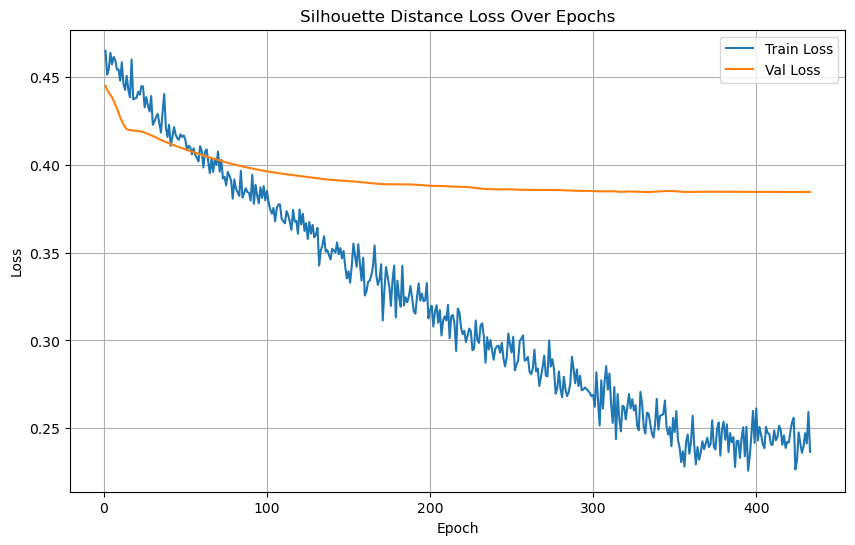

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/667], Loss: 0.2720
Test Batch [20/667], Loss: 0.2879
Test Batch [30/667], Loss: 0.3066


Test Batch [40/667], Loss: 0.3571
Test Batch [50/667], Loss: 0.2826
Test Batch [60/667], Loss: 0.3229
Test Batch [70/667], Loss: 0.2873


Test Batch [80/667], Loss: 0.2348
Test Batch [90/667], Loss: 0.2329
Test Batch [100/667], Loss: 0.1780
Test Batch [110/667], Loss: 0.2112
Test Batch [120/667], Loss: 0.2239


Test Batch [130/667], Loss: 0.2620
Test Batch [140/667], Loss: 0.1695
Test Batch [150/667], Loss: 0.1610
Test Batch [160/667], Loss: 0.2975
Test Batch [170/667], Loss: 0.2837
Test Batch [180/667], Loss: 0.5000


Test Batch [190/667], Loss: 0.2240
Test Batch [200/667], Loss: 0.5000
Test Batch [210/667], Loss: 0.5000
Test Batch [220/667], Loss: 0.2978
Test Batch [230/667], Loss: 0.2026
Test Batch [240/667], Loss: 0.5000
Test Batch [250/667], Loss: 0.5000
Test Batch [260/667], Loss: 0.5000
Test Batch [270/667], Loss: 0.5000
Test Batch [280/667], Loss: 0.5000
Test Batch [290/667], Loss: 0.5000


Test Batch [300/667], Loss: 0.5000
Test Batch [310/667], Loss: 0.2512
Test Batch [320/667], Loss: 0.2147
Test Batch [330/667], Loss: 0.3021
Test Batch [340/667], Loss: 0.2626


Test Batch [350/667], Loss: 0.2780
Test Batch [360/667], Loss: 0.2589
Test Batch [370/667], Loss: 0.2213


Test Batch [380/667], Loss: 0.2718
Test Batch [390/667], Loss: 0.2021
Test Batch [400/667], Loss: 0.1725


Test Batch [410/667], Loss: 0.2253
Test Batch [420/667], Loss: 0.2298
Test Batch [430/667], Loss: 0.2368


Test Batch [440/667], Loss: 0.3910
Test Batch [450/667], Loss: 0.2303
Test Batch [460/667], Loss: 0.3826
Test Batch [470/667], Loss: 0.3983


Test Batch [480/667], Loss: 0.2921
Test Batch [490/667], Loss: 0.2789
Test Batch [500/667], Loss: 0.2499


Test Batch [510/667], Loss: 0.2816
Test Batch [520/667], Loss: 0.2628
Test Batch [530/667], Loss: 0.5000
Test Batch [540/667], Loss: 0.2355


Test Batch [550/667], Loss: 0.5000
Test Batch [560/667], Loss: 0.2262
Test Batch [570/667], Loss: 0.3219
Test Batch [580/667], Loss: 0.1869


Test Batch [590/667], Loss: 0.2820
Test Batch [600/667], Loss: 0.4980
Test Batch [610/667], Loss: 0.3805
Test Batch [620/667], Loss: 0.3682
Test Batch [630/667], Loss: 0.4154


Test Batch [640/667], Loss: 0.2771
Test Batch [650/667], Loss: 0.4241
Test Batch [660/667], Loss: 0.4511

Test Loss: 0.3167


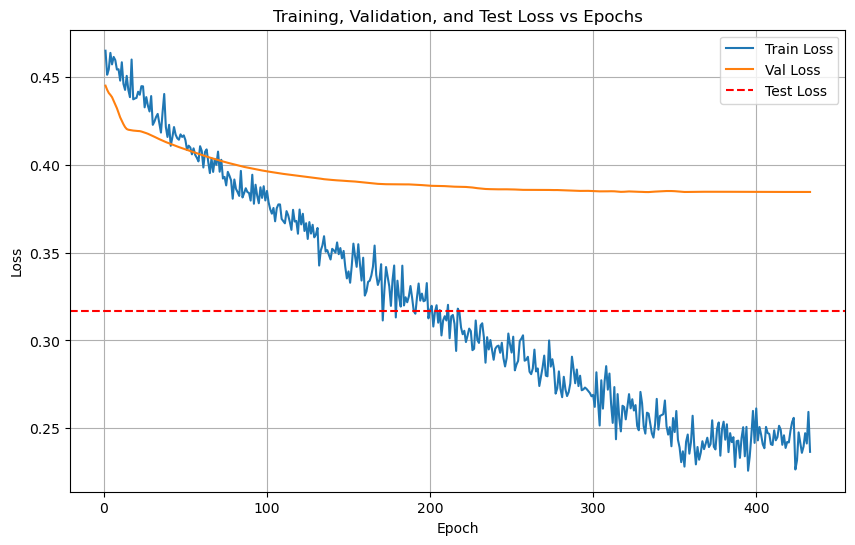

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/667 for test dataset.
  Processed batch 20/667 for test dataset.


  Processed batch 30/667 for test dataset.
  Processed batch 40/667 for test dataset.
  Processed batch 50/667 for test dataset.
  Processed batch 60/667 for test dataset.


  Processed batch 70/667 for test dataset.
  Processed batch 80/667 for test dataset.
  Processed batch 90/667 for test dataset.


  Processed batch 100/667 for test dataset.
  Processed batch 110/667 for test dataset.
  Processed batch 120/667 for test dataset.
  Processed batch 130/667 for test dataset.


  Processed batch 140/667 for test dataset.
  Processed batch 150/667 for test dataset.
  Processed batch 160/667 for test dataset.


  Processed batch 170/667 for test dataset.
  Processed batch 180/667 for test dataset.
  Processed batch 190/667 for test dataset.
  Processed batch 200/667 for test dataset.


  Processed batch 210/667 for test dataset.
  Processed batch 220/667 for test dataset.
  Processed batch 230/667 for test dataset.


  Processed batch 240/667 for test dataset.
  Processed batch 250/667 for test dataset.
  Processed batch 260/667 for test dataset.
  Processed batch 270/667 for test dataset.


  Processed batch 280/667 for test dataset.
  Processed batch 290/667 for test dataset.
  Processed batch 300/667 for test dataset.


  Processed batch 310/667 for test dataset.
  Processed batch 320/667 for test dataset.
  Processed batch 330/667 for test dataset.


  Processed batch 340/667 for test dataset.
  Processed batch 350/667 for test dataset.
  Processed batch 360/667 for test dataset.


  Processed batch 370/667 for test dataset.
  Processed batch 380/667 for test dataset.
  Processed batch 390/667 for test dataset.
  Processed batch 400/667 for test dataset.


  Processed batch 410/667 for test dataset.
  Processed batch 420/667 for test dataset.
  Processed batch 430/667 for test dataset.


  Processed batch 440/667 for test dataset.
  Processed batch 450/667 for test dataset.
  Processed batch 460/667 for test dataset.


  Processed batch 470/667 for test dataset.
  Processed batch 480/667 for test dataset.
  Processed batch 490/667 for test dataset.


  Processed batch 500/667 for test dataset.
  Processed batch 510/667 for test dataset.
  Processed batch 520/667 for test dataset.


  Processed batch 530/667 for test dataset.
  Processed batch 540/667 for test dataset.
  Processed batch 550/667 for test dataset.


  Processed batch 560/667 for test dataset.
  Processed batch 570/667 for test dataset.
  Processed batch 580/667 for test dataset.
  Processed batch 590/667 for test dataset.


  Processed batch 600/667 for test dataset.
  Processed batch 610/667 for test dataset.
  Processed batch 620/667 for test dataset.
  Processed batch 630/667 for test dataset.


  Processed batch 640/667 for test dataset.
  Processed batch 650/667 for test dataset.
  Processed batch 660/667 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42686, 128)
Test labels shape: (42686,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 68.89%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.80      0.80      0.80         5
           2       0.40      0.40      0.40         5
           3       1.00      0.80      0.89         5
           4       1.00      0.80      0.89         5
           5       0.57      0.80      0.67         5
           6       0.44      0.80      0.57         5
           7       1.00      0.20      0.33         5
           8       1.00      1.00      1.00         5

    accuracy                           0.69        45
   macro avg       0.76      0.69      0.68        45
weighted avg       0.76      0.69      0.68        45


LOG: Evaluating on the test set...
Test Accuracy: 60.13%

Test Classifica

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42686, 128)
Test labels shape: (42686,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5582  |  Val Loss: 2.6110
Validation loss improved from inf to 2.6110.
[Epoch 2/1000] Train Loss: 2.5343  |  Val Loss: 2.5864
Validation loss improved from 2.6110 to 2.5864.
[Epoch 3/1000] Train Loss: 2.5108  |  Val Loss: 2.5626
Validation loss improved from 2.5864 to 2.5626.
[Epoch 4/1000] Train Loss: 2.4881  |  Val Loss: 2.5394
Validation loss improved from 2.5626 to 2.5394.
[Epoch 5/1000] Train Loss: 2.4660  |  Val Loss: 2.5168
Validation loss improved from 2.5394 to 2.5168.
[Epoch 6/1000] Train Loss: 2.4447  |  Val Loss: 2.4947
Validation loss improved from 2.5168 to 2.4947.
[Epoch 7/1000] Train Loss: 2.4240  |  Val Loss: 2.4730
Validation loss improved from 2.4947 to 2.4730.
[Epoch 8/1000] Train Loss: 2.4037  |  Val Loss: 2.4519
Validation loss improved from 2.4730 to 2.4519.
[Epoch 9/1000] Train Loss: 2.3838  |  Val Loss: 2.4311
Validation loss improved from 2.4519 to 2.4311.
[Epoch 10/1000] Train Loss: 2.3643  |  Val Loss: 2.4106
Validation loss impr

[Epoch 60/1000] Train Loss: 1.7466  |  Val Loss: 1.8234
Validation loss improved from 1.8315 to 1.8234.
[Epoch 61/1000] Train Loss: 1.7374  |  Val Loss: 1.8154
Validation loss improved from 1.8234 to 1.8154.
[Epoch 62/1000] Train Loss: 1.7283  |  Val Loss: 1.8075
Validation loss improved from 1.8154 to 1.8075.
[Epoch 63/1000] Train Loss: 1.7192  |  Val Loss: 1.7997
Validation loss improved from 1.8075 to 1.7997.
[Epoch 64/1000] Train Loss: 1.7101  |  Val Loss: 1.7919
Validation loss improved from 1.7997 to 1.7919.
[Epoch 65/1000] Train Loss: 1.7010  |  Val Loss: 1.7842
Validation loss improved from 1.7919 to 1.7842.
[Epoch 66/1000] Train Loss: 1.6920  |  Val Loss: 1.7766
Validation loss improved from 1.7842 to 1.7766.
[Epoch 67/1000] Train Loss: 1.6831  |  Val Loss: 1.7690
Validation loss improved from 1.7766 to 1.7690.
[Epoch 68/1000] Train Loss: 1.6742  |  Val Loss: 1.7615
Validation loss improved from 1.7690 to 1.7615.
[Epoch 69/1000] Train Loss: 1.6655  |  Val Loss: 1.7540
Validati

[Epoch 77/1000] Train Loss: 1.5976  |  Val Loss: 1.6968
Validation loss improved from 1.7038 to 1.6968.
[Epoch 78/1000] Train Loss: 1.5894  |  Val Loss: 1.6900
Validation loss improved from 1.6968 to 1.6900.
[Epoch 79/1000] Train Loss: 1.5813  |  Val Loss: 1.6833
Validation loss improved from 1.6900 to 1.6833.
[Epoch 80/1000] Train Loss: 1.5732  |  Val Loss: 1.6766
Validation loss improved from 1.6833 to 1.6766.
[Epoch 81/1000] Train Loss: 1.5651  |  Val Loss: 1.6701
Validation loss improved from 1.6766 to 1.6701.
[Epoch 82/1000] Train Loss: 1.5571  |  Val Loss: 1.6637
Validation loss improved from 1.6701 to 1.6637.
[Epoch 83/1000] Train Loss: 1.5491  |  Val Loss: 1.6574
Validation loss improved from 1.6637 to 1.6574.
[Epoch 84/1000] Train Loss: 1.5411  |  Val Loss: 1.6511
Validation loss improved from 1.6574 to 1.6511.
[Epoch 85/1000] Train Loss: 1.5332  |  Val Loss: 1.6449
Validation loss improved from 1.6511 to 1.6449.
[Epoch 86/1000] Train Loss: 1.5253  |  Val Loss: 1.6388
Validati

[Epoch 133/1000] Train Loss: 1.1950  |  Val Loss: 1.3966
Validation loss improved from 1.4010 to 1.3966.
[Epoch 134/1000] Train Loss: 1.1888  |  Val Loss: 1.3922
Validation loss improved from 1.3966 to 1.3922.
[Epoch 135/1000] Train Loss: 1.1827  |  Val Loss: 1.3879
Validation loss improved from 1.3922 to 1.3879.
[Epoch 136/1000] Train Loss: 1.1765  |  Val Loss: 1.3836
Validation loss improved from 1.3879 to 1.3836.
[Epoch 137/1000] Train Loss: 1.1704  |  Val Loss: 1.3793
Validation loss improved from 1.3836 to 1.3793.
[Epoch 138/1000] Train Loss: 1.1643  |  Val Loss: 1.3750
Validation loss improved from 1.3793 to 1.3750.
[Epoch 139/1000] Train Loss: 1.1582  |  Val Loss: 1.3708
Validation loss improved from 1.3750 to 1.3708.
[Epoch 140/1000] Train Loss: 1.1522  |  Val Loss: 1.3666
Validation loss improved from 1.3708 to 1.3666.
[Epoch 141/1000] Train Loss: 1.1462  |  Val Loss: 1.3624
Validation loss improved from 1.3666 to 1.3624.
[Epoch 142/1000] Train Loss: 1.1402  |  Val Loss: 1.358

[Epoch 151/1000] Train Loss: 1.0871  |  Val Loss: 1.3218
Validation loss improved from 1.3258 to 1.3218.
[Epoch 152/1000] Train Loss: 1.0813  |  Val Loss: 1.3179
Validation loss improved from 1.3218 to 1.3179.
[Epoch 153/1000] Train Loss: 1.0755  |  Val Loss: 1.3139
Validation loss improved from 1.3179 to 1.3139.
[Epoch 154/1000] Train Loss: 1.0698  |  Val Loss: 1.3099
Validation loss improved from 1.3139 to 1.3099.
[Epoch 155/1000] Train Loss: 1.0640  |  Val Loss: 1.3059
Validation loss improved from 1.3099 to 1.3059.
[Epoch 156/1000] Train Loss: 1.0583  |  Val Loss: 1.3019
Validation loss improved from 1.3059 to 1.3019.
[Epoch 157/1000] Train Loss: 1.0526  |  Val Loss: 1.2980
Validation loss improved from 1.3019 to 1.2980.
[Epoch 158/1000] Train Loss: 1.0470  |  Val Loss: 1.2941
Validation loss improved from 1.2980 to 1.2941.
[Epoch 159/1000] Train Loss: 1.0413  |  Val Loss: 1.2902
Validation loss improved from 1.2941 to 1.2902.
[Epoch 160/1000] Train Loss: 1.0357  |  Val Loss: 1.286

[Epoch 199/1000] Train Loss: 0.8330  |  Val Loss: 1.1531
Validation loss improved from 1.1562 to 1.1531.
[Epoch 200/1000] Train Loss: 0.8282  |  Val Loss: 1.1500
Validation loss improved from 1.1531 to 1.1500.
[Epoch 201/1000] Train Loss: 0.8234  |  Val Loss: 1.1470
Validation loss improved from 1.1500 to 1.1470.
[Epoch 202/1000] Train Loss: 0.8186  |  Val Loss: 1.1439
Validation loss improved from 1.1470 to 1.1439.
[Epoch 203/1000] Train Loss: 0.8139  |  Val Loss: 1.1409
Validation loss improved from 1.1439 to 1.1409.
[Epoch 204/1000] Train Loss: 0.8091  |  Val Loss: 1.1378
Validation loss improved from 1.1409 to 1.1378.
[Epoch 205/1000] Train Loss: 0.8043  |  Val Loss: 1.1348
Validation loss improved from 1.1378 to 1.1348.
[Epoch 206/1000] Train Loss: 0.7996  |  Val Loss: 1.1318
Validation loss improved from 1.1348 to 1.1318.
[Epoch 207/1000] Train Loss: 0.7949  |  Val Loss: 1.1288
Validation loss improved from 1.1318 to 1.1288.
[Epoch 208/1000] Train Loss: 0.7903  |  Val Loss: 1.125

[Epoch 221/1000] Train Loss: 0.7313  |  Val Loss: 1.0868
Validation loss improved from 1.0898 to 1.0868.
[Epoch 222/1000] Train Loss: 0.7268  |  Val Loss: 1.0839
Validation loss improved from 1.0868 to 1.0839.
[Epoch 223/1000] Train Loss: 0.7224  |  Val Loss: 1.0810
Validation loss improved from 1.0839 to 1.0810.
[Epoch 224/1000] Train Loss: 0.7181  |  Val Loss: 1.0781
Validation loss improved from 1.0810 to 1.0781.
[Epoch 225/1000] Train Loss: 0.7138  |  Val Loss: 1.0752
Validation loss improved from 1.0781 to 1.0752.
[Epoch 226/1000] Train Loss: 0.7095  |  Val Loss: 1.0723
Validation loss improved from 1.0752 to 1.0723.
[Epoch 227/1000] Train Loss: 0.7052  |  Val Loss: 1.0694
Validation loss improved from 1.0723 to 1.0694.
[Epoch 228/1000] Train Loss: 0.7009  |  Val Loss: 1.0666
Validation loss improved from 1.0694 to 1.0666.
[Epoch 229/1000] Train Loss: 0.6967  |  Val Loss: 1.0638
Validation loss improved from 1.0666 to 1.0638.
[Epoch 230/1000] Train Loss: 0.6924  |  Val Loss: 1.061

[Epoch 279/1000] Train Loss: 0.5049  |  Val Loss: 0.9438
Validation loss improved from 0.9458 to 0.9438.
[Epoch 280/1000] Train Loss: 0.5014  |  Val Loss: 0.9418
Validation loss improved from 0.9438 to 0.9418.
[Epoch 281/1000] Train Loss: 0.4980  |  Val Loss: 0.9399
Validation loss improved from 0.9418 to 0.9399.
[Epoch 282/1000] Train Loss: 0.4946  |  Val Loss: 0.9379
Validation loss improved from 0.9399 to 0.9379.
[Epoch 283/1000] Train Loss: 0.4912  |  Val Loss: 0.9360
Validation loss improved from 0.9379 to 0.9360.
[Epoch 284/1000] Train Loss: 0.4878  |  Val Loss: 0.9341
Validation loss improved from 0.9360 to 0.9341.
[Epoch 285/1000] Train Loss: 0.4844  |  Val Loss: 0.9322
Validation loss improved from 0.9341 to 0.9322.
[Epoch 286/1000] Train Loss: 0.4811  |  Val Loss: 0.9303
Validation loss improved from 0.9322 to 0.9303.
[Epoch 287/1000] Train Loss: 0.4777  |  Val Loss: 0.9284
Validation loss improved from 0.9303 to 0.9284.
[Epoch 288/1000] Train Loss: 0.4744  |  Val Loss: 0.926

[Epoch 301/1000] Train Loss: 0.4332  |  Val Loss: 0.9029
Validation loss improved from 0.9048 to 0.9029.
[Epoch 302/1000] Train Loss: 0.4300  |  Val Loss: 0.9010
Validation loss improved from 0.9029 to 0.9010.
[Epoch 303/1000] Train Loss: 0.4269  |  Val Loss: 0.8990
Validation loss improved from 0.9010 to 0.8990.
[Epoch 304/1000] Train Loss: 0.4238  |  Val Loss: 0.8971
Validation loss improved from 0.8990 to 0.8971.
[Epoch 305/1000] Train Loss: 0.4207  |  Val Loss: 0.8952
Validation loss improved from 0.8971 to 0.8952.
[Epoch 306/1000] Train Loss: 0.4176  |  Val Loss: 0.8934
Validation loss improved from 0.8952 to 0.8934.
[Epoch 307/1000] Train Loss: 0.4145  |  Val Loss: 0.8915
Validation loss improved from 0.8934 to 0.8915.
[Epoch 308/1000] Train Loss: 0.4114  |  Val Loss: 0.8897
Validation loss improved from 0.8915 to 0.8897.
[Epoch 309/1000] Train Loss: 0.4083  |  Val Loss: 0.8878
Validation loss improved from 0.8897 to 0.8878.
[Epoch 310/1000] Train Loss: 0.4052  |  Val Loss: 0.885

[Epoch 347/1000] Train Loss: 0.3056  |  Val Loss: 0.8312
Validation loss improved from 0.8322 to 0.8312.
[Epoch 348/1000] Train Loss: 0.3034  |  Val Loss: 0.8303
Validation loss improved from 0.8312 to 0.8303.
[Epoch 349/1000] Train Loss: 0.3011  |  Val Loss: 0.8294
Validation loss improved from 0.8303 to 0.8294.
[Epoch 350/1000] Train Loss: 0.2989  |  Val Loss: 0.8285
Validation loss improved from 0.8294 to 0.8285.
[Epoch 351/1000] Train Loss: 0.2967  |  Val Loss: 0.8276
Validation loss improved from 0.8285 to 0.8276.
[Epoch 352/1000] Train Loss: 0.2945  |  Val Loss: 0.8268
Validation loss improved from 0.8276 to 0.8268.
[Epoch 353/1000] Train Loss: 0.2924  |  Val Loss: 0.8260
Validation loss improved from 0.8268 to 0.8260.
[Epoch 354/1000] Train Loss: 0.2902  |  Val Loss: 0.8252
Validation loss improved from 0.8260 to 0.8252.
[Epoch 355/1000] Train Loss: 0.2881  |  Val Loss: 0.8244
Validation loss improved from 0.8252 to 0.8244.
[Epoch 356/1000] Train Loss: 0.2860  |  Val Loss: 0.823

[Epoch 369/1000] Train Loss: 0.2601  |  Val Loss: 0.8143
Validation loss improved from 0.8150 to 0.8143.
[Epoch 370/1000] Train Loss: 0.2582  |  Val Loss: 0.8137
Validation loss improved from 0.8143 to 0.8137.
[Epoch 371/1000] Train Loss: 0.2564  |  Val Loss: 0.8131
Validation loss improved from 0.8137 to 0.8131.
[Epoch 372/1000] Train Loss: 0.2545  |  Val Loss: 0.8125
Validation loss improved from 0.8131 to 0.8125.
[Epoch 373/1000] Train Loss: 0.2527  |  Val Loss: 0.8120
Validation loss improved from 0.8125 to 0.8120.
[Epoch 374/1000] Train Loss: 0.2509  |  Val Loss: 0.8114
Validation loss improved from 0.8120 to 0.8114.
[Epoch 375/1000] Train Loss: 0.2491  |  Val Loss: 0.8109
Validation loss improved from 0.8114 to 0.8109.
[Epoch 376/1000] Train Loss: 0.2473  |  Val Loss: 0.8104
Validation loss improved from 0.8109 to 0.8104.
[Epoch 377/1000] Train Loss: 0.2456  |  Val Loss: 0.8099
Validation loss improved from 0.8104 to 0.8099.
[Epoch 378/1000] Train Loss: 0.2438  |  Val Loss: 0.809

[Epoch 420/1000] Train Loss: 0.1804  |  Val Loss: 0.7989
Validation loss improved from 0.7989 to 0.7989.
[Epoch 421/1000] Train Loss: 0.1792  |  Val Loss: 0.7989
Validation loss improved from 0.7989 to 0.7989.
[Epoch 422/1000] Train Loss: 0.1779  |  Val Loss: 0.7990
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 423/1000] Train Loss: 0.1766  |  Val Loss: 0.7990
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 424/1000] Train Loss: 0.1754  |  Val Loss: 0.7990
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 425/1000] Train Loss: 0.1741  |  Val Loss: 0.7990
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 426/1000] Train Loss: 0.1729  |  Val Loss: 0.7991
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 427/1000] Train Loss: 0.1717  |  Val Loss: 0.7991
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 428/1000] Train Loss: 0.1705  |  Val Loss: 0.7991
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 429/10

[Epoch 442/1000] Train Loss: 0.1544  |  Val Loss: 0.8000
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 443/1000] Train Loss: 0.1533  |  Val Loss: 0.8001
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 444/1000] Train Loss: 0.1523  |  Val Loss: 0.8002
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 445/1000] Train Loss: 0.1512  |  Val Loss: 0.8004
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 446/1000] Train Loss: 0.1502  |  Val Loss: 0.8005
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 447/1000] Train Loss: 0.1491  |  Val Loss: 0.8006
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 448/1000] Train Loss: 0.1481  |  Val Loss: 0.8008
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 449/1000] Train Loss: 0.1471  |  Val Loss: 0.8010
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 450/1000] Train Loss: 0.1461  |  Val Loss: 0.8011
!! Validation loss did NOT improve !! Patience:

[Epoch 500/1000] Train Loss: 0.1048  |  Val Loss: 0.8146
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 501/1000] Train Loss: 0.1041  |  Val Loss: 0.8149
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 502/1000] Train Loss: 0.1035  |  Val Loss: 0.8153
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 503/1000] Train Loss: 0.1029  |  Val Loss: 0.8156
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 504/1000] Train Loss: 0.1022  |  Val Loss: 0.8159
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 505/1000] Train Loss: 0.1016  |  Val Loss: 0.8162
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 506/1000] Train Loss: 0.1010  |  Val Loss: 0.8165
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 507/1000] Train Loss: 0.1004  |  Val Loss: 0.8169
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 508/1000] Train Loss: 0.0997  |  Val Loss: 0.8172
!! Validation loss did NOT improve !! Patience:

[Epoch 513/1000] Train Loss: 0.0968  |  Val Loss: 0.8190
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 514/1000] Train Loss: 0.0962  |  Val Loss: 0.8193
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 515/1000] Train Loss: 0.0956  |  Val Loss: 0.8196
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 516/1000] Train Loss: 0.0950  |  Val Loss: 0.8200
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 517/1000] Train Loss: 0.0945  |  Val Loss: 0.8204
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 518/1000] Train Loss: 0.0939  |  Val Loss: 0.8207
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 519/1000] Train Loss: 0.0933  |  Val Loss: 0.8211
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 520/1000] Train Loss: 0.0928  |  Val Loss: 0.8215
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 521/1000] Train Loss: 0.0922  |  Val Loss: 0.8219
!! Validation loss did NOT improve !! Patience:

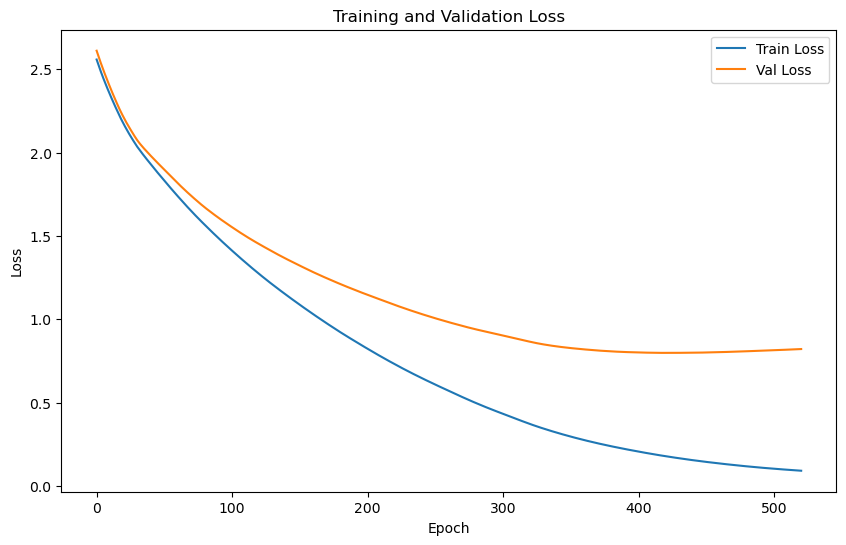

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.0461 | Test Accuracy: 63.22%


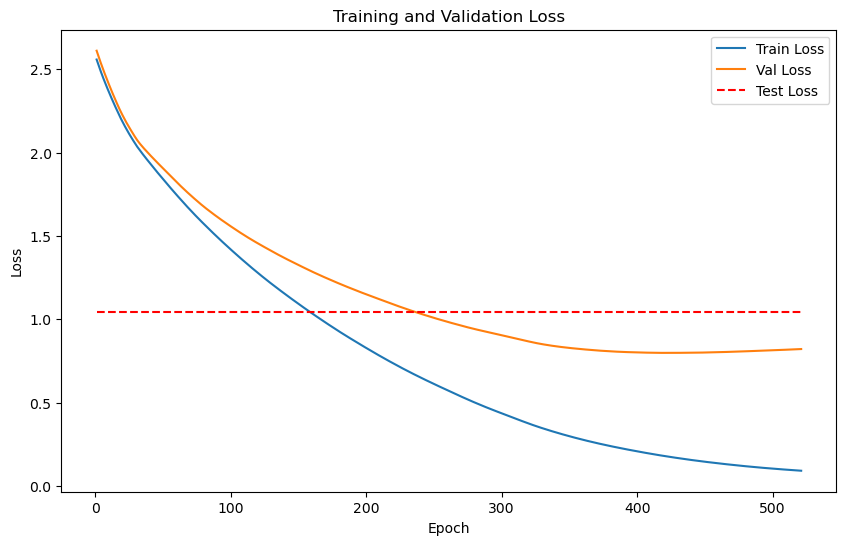

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


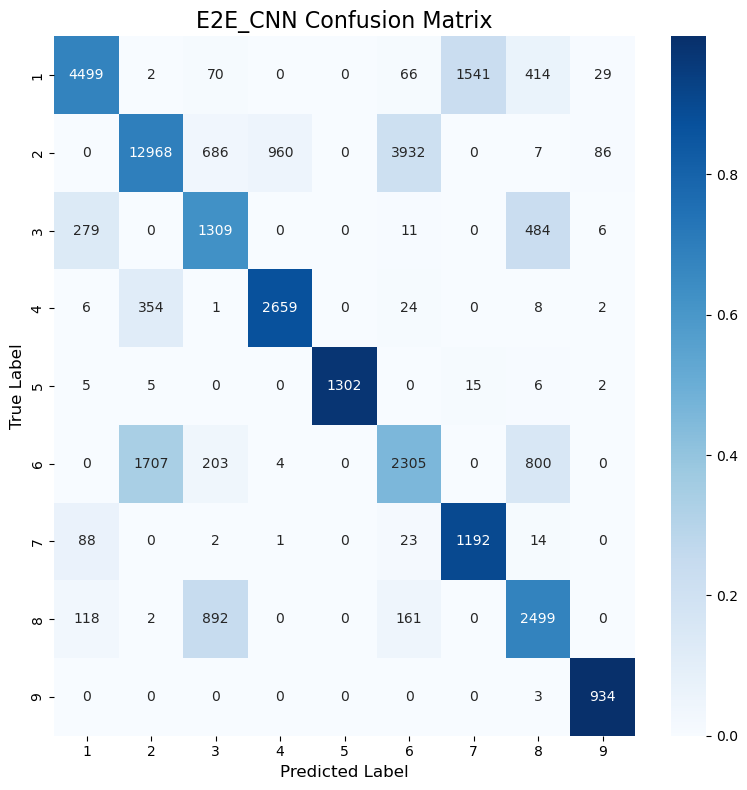

Classification Accuracy: 69.50%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


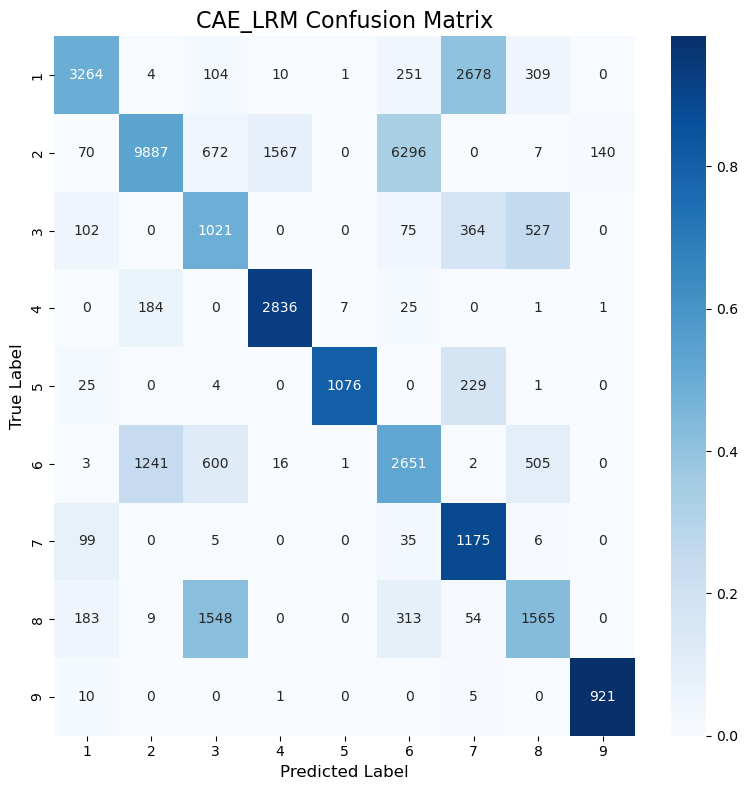

Classification Accuracy: 57.15%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


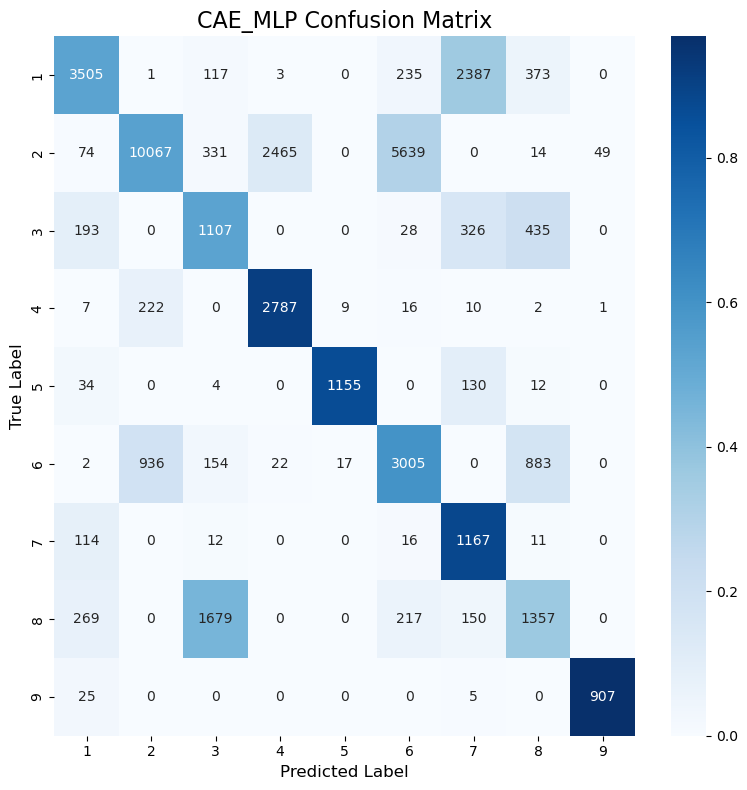

Classification Accuracy: 58.70%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


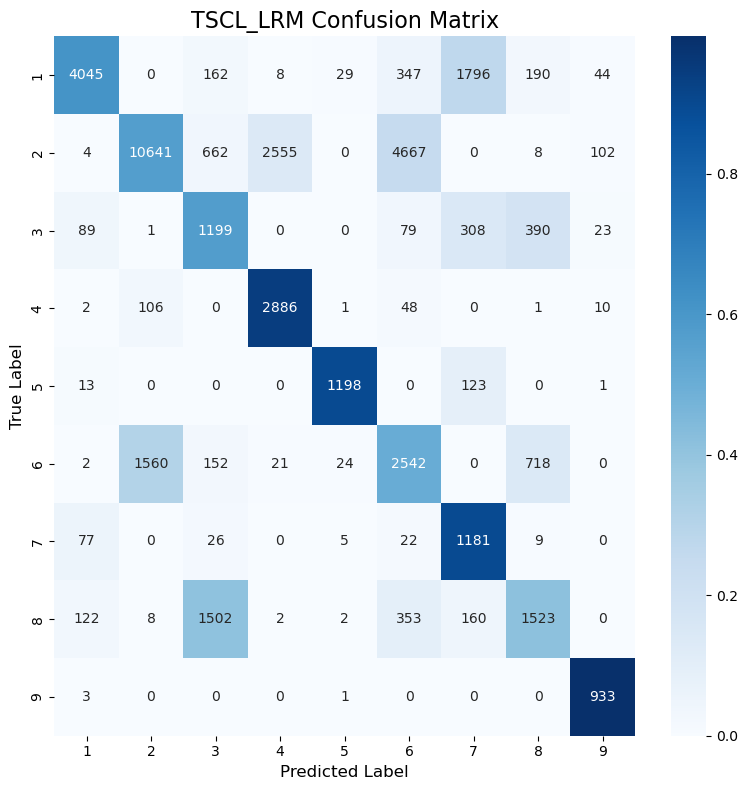

Classification Accuracy: 61.26%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


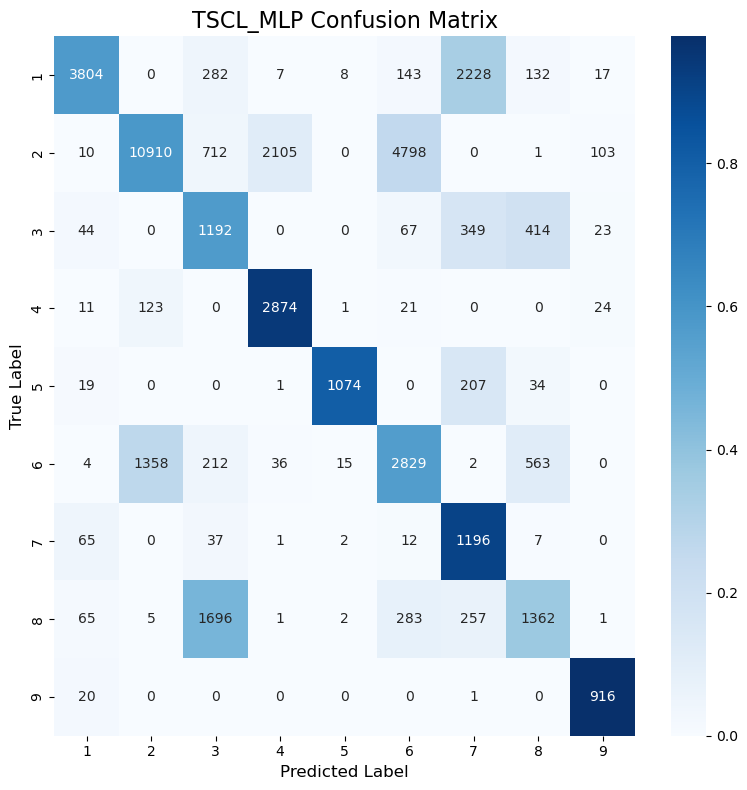

Classification Accuracy: 61.28%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


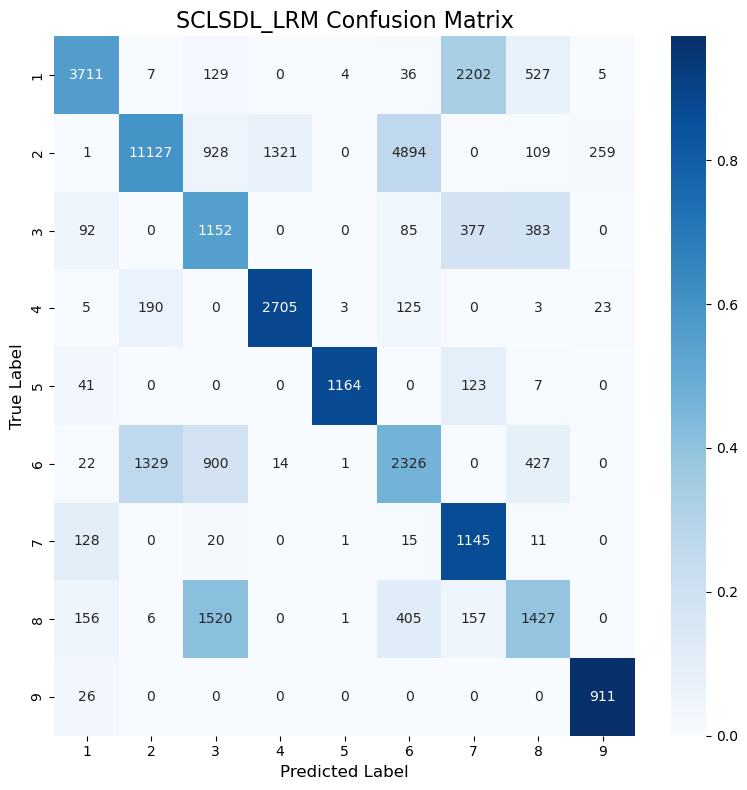

Classification Accuracy: 60.13%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


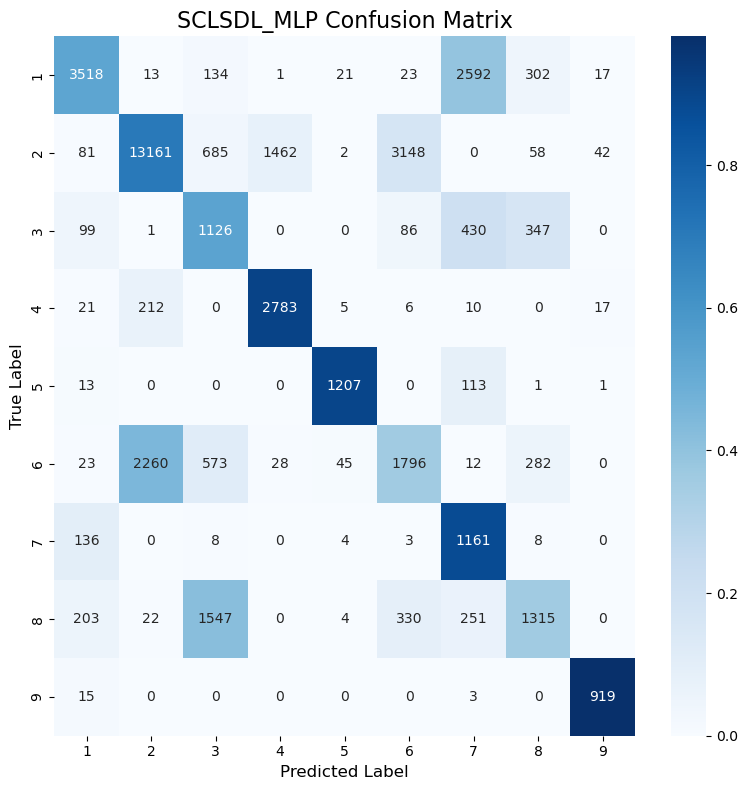

Classification Accuracy: 63.22%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          69.50
1    LRM (CAE)          57.15
2    MLP (CAE)          58.70
3     TSCL LRM          61.26
4     TSCL MLP          61.28
5  SCL_SDL LRM          60.13
6  SCL_SDL MLP          63.22

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          69.50
6  SCL_SDL MLP          63.22
4     TSCL MLP          61.28
3     TSCL LRM          61.26
5  SCL_SDL LRM          60.13
2    MLP (CAE)          58.70
1    LRM (CAE)          57.15
